# Chap02 - More PyMC

## 2.1 서론

- `PyMC` 구문과 디자인 패턴에 대해 알 수 있다.
- 베이지안 관점에서 시스템을 모델링 하는 방법을 알 수 있다.
- 베이지안 모델의 적합도 평가 및 데이터 시각화 기법을 알 수 있다.

### 2.1.1 부모와 자식 관계

> **부모변수**(Parent variable)는 다른 변수에 영항을 주는 변수다.

> **자식변수**(Child variable)는 다른 변수의 영향을 받는 즉, 부모변수에 종속된다.

어느 변수라도 부모변수가 될 수 있고, 동시에 자식변수가 될 수 있다.

In [12]:
import pymc as pm
import matplotlib

# matplotlib.rc('font', family='NanumGothic')  # linux
matplotlib.rc('font', family='AppleGothic')  # Mac

lambda_ = pm.Exponential('poisson_param', 1)
# 다음 변수 호출에 사용된다.
# lambda_는 data_generator의 부모변수다.
data_generator = pm.Poisson('data_generator', lambda_)
# data_generator는 data_plus_one의 부모변수다
data_plus_one = data_generator + 1

In [2]:
print("Children of 'lambda_': \n", lambda_.children)
print("\nParents of 'data_generator': \n", data_generator.parents)
print("\nChildren of 'data_generator': \n", data_generator.children)

Children of 'lambda_': 
 {<pymc.distributions.new_dist_class.<locals>.new_class 'data_generator' at 0x1109d4eb8>}

Parents of 'data_generator': 
 {'mu': <pymc.distributions.new_dist_class.<locals>.new_class 'poisson_param' at 0x1109d4fd0>}

Children of 'data_generator': 
 {<pymc.PyMCObjects.Deterministic '(data_generator_add_1)' at 0x1109d4f98>}


### 2.1.2 `PyMC` 변수

모든 `PyMC`변수는 `value` 속성을 가진다. 이 속성을 통해 변수의 **현재값**(random한 값)을 생성한다.

자식변수(child variable)의 값은 부모변수 값이 주어질 때 변경된다.

In [3]:
print('lambda_.value =', lambda_.value)
print('data_generator.value =', data_generator.value)
print('data_plus_one.value =', data_plus_one.value)

lambda_.value = 0.1434912493589856
data_generator.value = 0
data_plus_one.value = 1


`PyMC`은 `stochastic`과 `deterministic` 두 가지 변수를 가진다.
- `stochastic` 변수는 값이 정해지지 않은 변수로 Random(난수)이며 `Poisson, DiscreteUniform, Exponential` 클래스의 인스턴스가 있다.
- `deterministic` 변수는 고정된(?) 값이다. 

#### stochastic 변수 초기화

```python
some_variable = pm.DiscreteUniform('discrete_uni_var', 0, 4)
```

`0, 4`는 `DiscreteUniform`의 난수 하한선과 상한선이다. `name` arg는 분석 후반에 사후확률분포를 가져올 때 사용하므로 이름을 사용하는 것이 좋다.

In [4]:
# ??를 이용해 확인하기
??pm.DiscreteUniform

Init signature: pm.DiscreteUniform(*args, **kwds)
Docstring:     
D = DiscreteUniform(name, lower, upper, value=None, observed=False, size=1, trace=True, rseed=True, doc=None, verbose=-1, debug=False)

Stochastic variable with DiscreteUniform distribution.
Parents are: lower, upper.

Docstring of log-probability function:

    Discrete uniform log-likelihood.

    .. math::
        f(x \mid lower, upper) = \frac{1}{upper-lower}

    :Parameters:
      - `x` : [int] :math:`lower \leq x \leq upper`
      - `lower` : Lower limit.
      - `upper` : Upper limit (upper > lower).

    
File:           ~/miniconda3/envs/study/lib/python3.6/site-packages/pymc/distributions.py
Type:           StochasticMeta


In [5]:
some_variable = pm.DiscreteUniform('discrete_uni_var', 0, 4)
print('stochastic :', some_variable.value)

stochastic : 3


변수를 여러개를 랜덤하게 출력하고 싶을 경우 `size` keyword를 이용하여 독립적인 확률변수의 리스트가 만들어 진다.

In [6]:
betas = pm.Uniform('betas', 0, 1, size=10)
print('betas :', betas.value)
# ??pm.Uniform

betas : [ 0.52081194  0.43329867  0.30621726  0.0388115   0.79667311  0.74442242
  0.79641146  0.5080275   0.41892909  0.42708964]


#### `random()` 호출하기

`stochastic` 변수의 `random()` 메소드를 호출하여 새 난수값을 만들 수 있다.

In [7]:
lambda_1 = pm.Exponential("lambda_1", 1)
lambda_2 = pm.Exponential('lambda_2', 1)
tau = pm.DiscreteUniform('tau', lower=0, upper=10)

print("Initialized values...")
print("lambda_1.value = %.3f" % lambda_1.value)
print("lambda_2.value = %.3f" % lambda_2.value)
print("tau.value = %.3f" % tau.value, "\n")
print(lambda_1.random(), lambda_2.random(), tau.random())
print("After calling random() on the variables...")
print("lambda_1.value = %.3f" % lambda_1.value)
print("lambda_2.value = %.3f" % lambda_2.value)
print("tau.value = %.3f" % tau.value)

Initialized values...
lambda_1.value = 0.379
lambda_2.value = 0.022
tau.value = 4.000 

3.283817693531131 0.8791406669058468 7
After calling random() on the variables...
lambda_1.value = 3.284
lambda_2.value = 0.879
tau.value = 7.000


#### deterministic 변수

deterministic 변수는 아래와 같이 **데코레이터**를 이용해 정의해 줄 수 있다.

```python
@pm.deterministic
def some_deterministic_var(v1=v1, ):
    # type code here
```

In [8]:
type(lambda_1 + lambda_2)

pymc.PyMCObjects.Deterministic

In [9]:
# sample code : 1장 1.4 참고
import numpy as np

n_data_points = 5

@pm.deterministic
def lambda_(tau=tau, lambda_1=lambda_1, lambda_2=lambda_2):
    out = np.zeros(n_data_points)
    out[:tau] = lambda_1
    out[tau:] = lambda_2
    return out

위의 식에서 $\tau, \lambda_1, \lambda_2$를 안다면 $\lambda$를 알 수 있는 것은 당연한 사실이다. 따라서 $\lambda$는 deterministic 변수이다.

`deterministic` 데코레이터 내부에서 stochastic 변수는 stochastic 변수가 아니라 스칼라나 `numpy` 배열 처럼 작동한다. 

In [10]:
some_variable = pm.DiscreteUniform('discrete_uni_var', 0, 4)

@pm.deterministic
def some_deterministic(stoch=some_variable):  # 함수 작성 시 반드시 kwarg를 사용해야 한다. 
    # stoch.value**2 일 경우 AttributeError가 발생한다. 
    return stoch**2

### 2.1.3 모델에 관측 포함하기

예를 들어 $\lambda_1$에 대한 사전확률분포를 살펴보자

(0, 8)

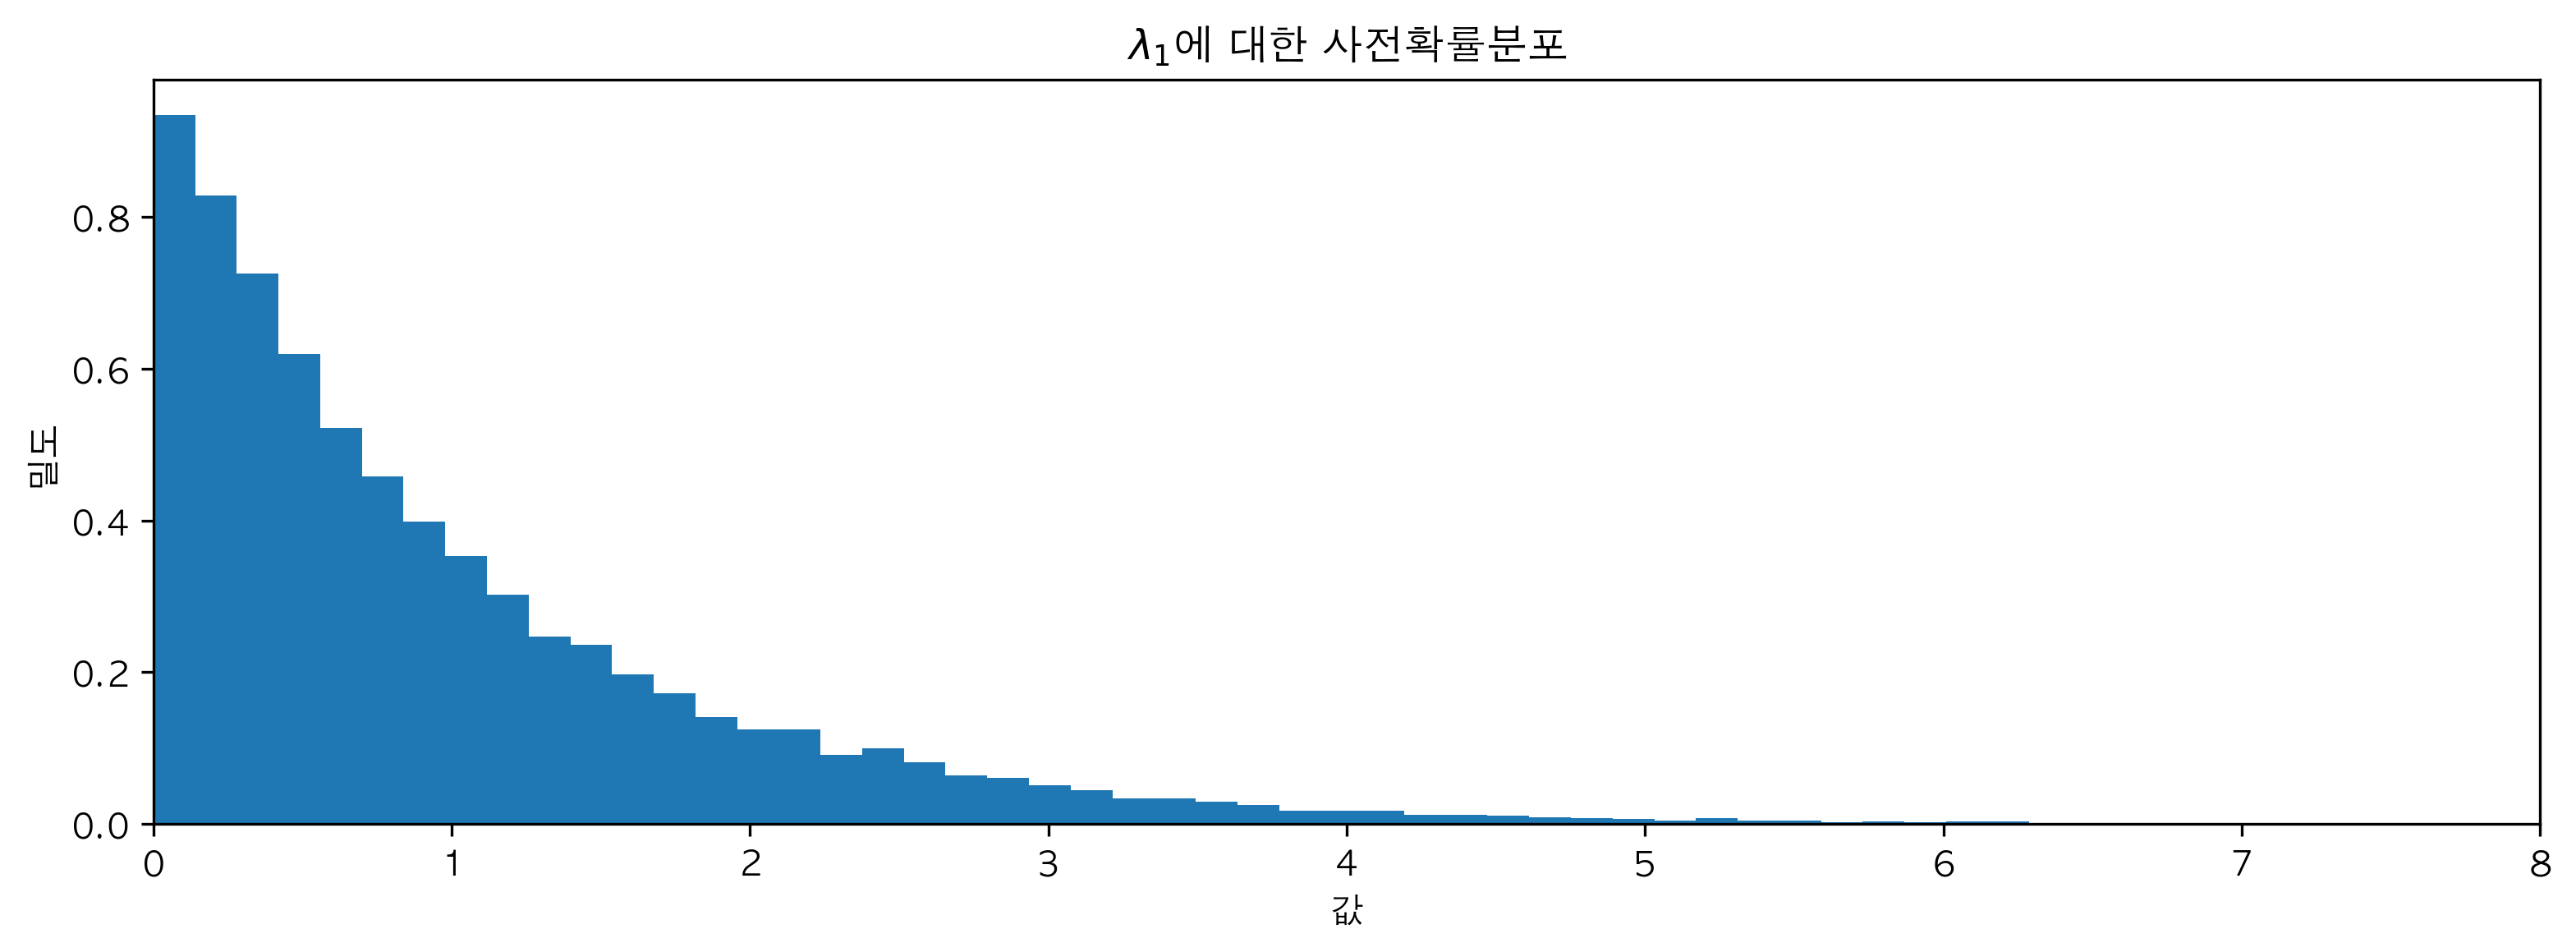

In [13]:
%matplotlib inline
from IPython.core.pylabtools import figsize
from matplotlib import pyplot as plt

figsize(12.5, 4)
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.dpi'] = 300

lambda_1 = pm.Exponential("lambda_1", 1)
samples = [lambda_1.random() for i in range(20000)]
plt.hist(samples, bins=70, density=True, histtype='stepfilled')
plt.title('$\lambda_1$에 대한 사전확률분포')
plt.xlabel('값')
plt.ylabel('밀도')
plt.xlim(0, 8)

사전확률분포를 알아보았으니, 데이터/증거/관측치 $X$를 모델에 포함시켜 보자.

`PyMC` 확률변수는 boolean을 받는 kwarg인 `observed`가 있다. 이 `observed`의 역할은 변수의 현재값을 고정하는 즉, 값을 변경 불가능하게 만든다.

In [14]:
data = np.array([10, 5])
fixed_variable = pm.Poisson('fxd', 1, value=data, observed=True)

print('value:', fixed_variable.value)
print("calling .random()")
fixed_variable.random()
print("value: ", fixed_variable.value)

value: [10  5]
calling .random()
value:  [10  5]


In [15]:
# sample code

data = np.array([10, 25, 15, 20, 35])
obs = pm.Poisson('obs', lambda_, value=data, observed=True)
print(obs.value)

[10 25 15 20 35]


### 2.1.4 마지막으로

1.4에서 문자메시지 예제 데이터를 통해 모델링을 했을 때, `pm.Model` 클래스로 만들었다. 

이러한 `Model` 클래스를 사용하여 변수를 하나의 단위로 분석할 수 있다.

In [16]:
# sample code
model = pm.Model([obs, lambda_, lambda_1, lambda_2, tau])
model

## 2.2 모델링 방법

베이지안 모델링을 시작할 때 분석할 **데이터가 어떻게 만들어졌는지** 생각해 보는 것이 좋다.

1장에서 보았던 문자 메시지 데이터에 대해 살펴보자.

1. 먼저, '개수 데이터를 나타내는 최고의 확률변수는 무엇인가?'에서 푸아송분포를 따른다고 가정 하였고, 이를 가지고 푸아송분포에서 표본으로 얻은 문자 메시지 개수를 모델링 한다.
2. '푸아송 분포를 위해 필요한 것은 무엇인가?'에 대해서는 푸아송분포는 모수 $\lambda$를 가진다.
3. 우리는 $\lambda$가 무엇인지 알지 못한다. $\lambda$가 **두 개** 있다고 가정하고 $\lambda$가 바뀌는 시점을 변환점 $\tau$라고 한다.
4. '이 두 $\lambda$에 대해 바람직한 확률분포는 무엇인가?' 에서 지수확률분포를 따른다고 가정한다.
5. 이 지수확률분포는 모수 $\alpha$를 가진다. 우리는 모수 $\alpha$를 알지 못한다. 우리가 추론하고자 하는 것은 $\lambda$ 이므로 $\alpha$의 모델링은 하지 않는다.
6. 또한, 우리는 $\tau$를 알지 못하므로, $\tau$는 전체 기간 동안 이산균등분포에서 나왔다고 가정한다.

이를 시각화하면 다음과 같다.

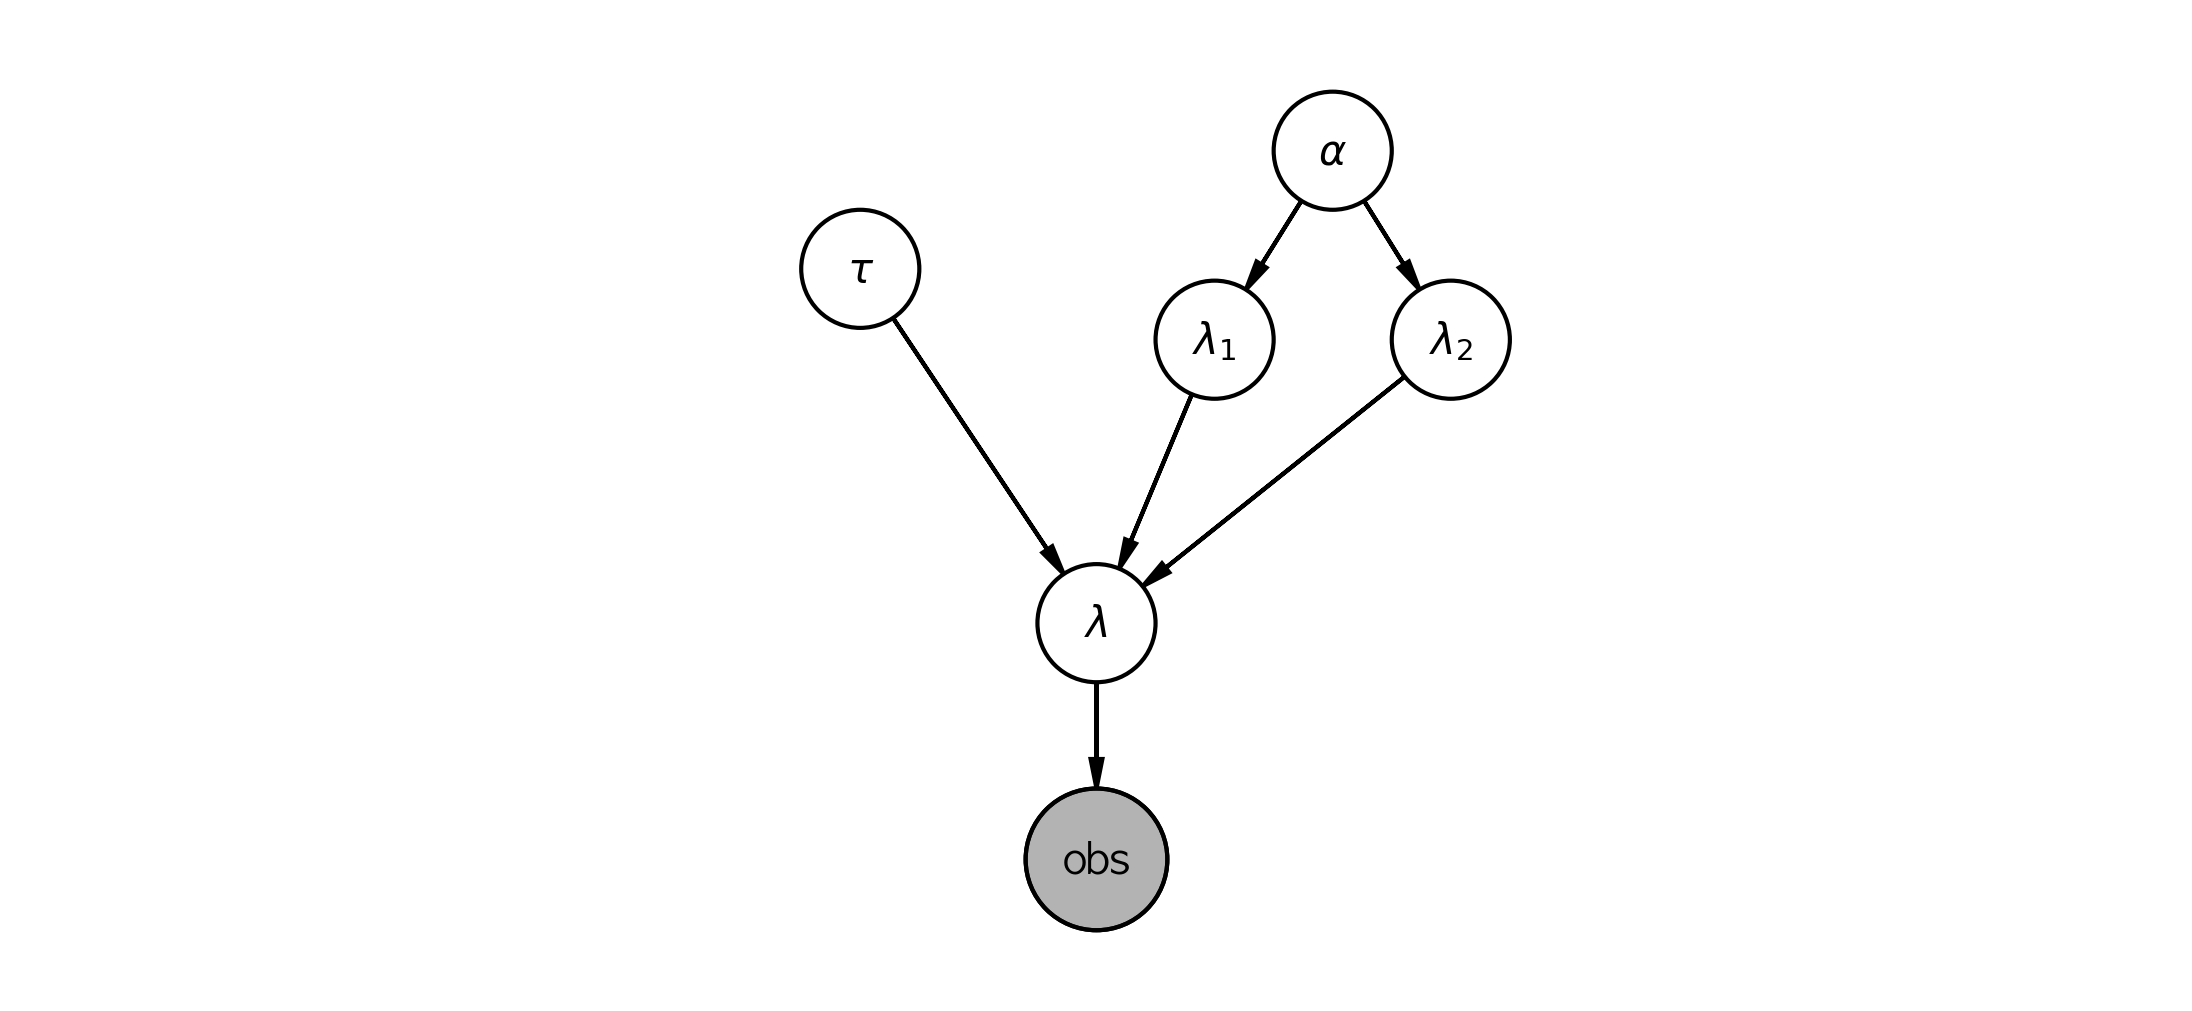

<Figure size 3600x1500 with 0 Axes>

In [17]:
import daft  # pip install daft

pgm = daft.PGM([9, 4], origin=[.5,.5])
pgm.add_node(daft.Node("tau", r"$\tau$", 4.0, 3.5))
pgm.add_node(daft.Node("alpha", r"$\alpha$", 6, 4.0))
pgm.add_node(daft.Node("lambda1", r"$\lambda_1$", 5.5, 3.2,))
pgm.add_node(daft.Node("lambda2", r"$\lambda_2$", 6.5, 3.2))
pgm.add_node(daft.Node("lambda", r"$\lambda$", 5.0, 2.0))
pgm.add_node(daft.Node("obs", "obs", 5.0, 1.0, 1.2, observed=True))



pgm.add_edge("tau", "lambda")
pgm.add_edge("alpha", "lambda1")
pgm.add_edge("alpha", "lambda2")
pgm.add_edge("lambda1", "lambda")
pgm.add_edge("lambda2", "lambda")

pgm.add_edge("lambda", "obs")
pgm.render()
plt.figure( figsize=(12,5) )
plt.show()

### 2.2.1 같은 스토리, 다른 결말

위의 6가지 단계를 반대로 뒤집어 재해석 하면 데이터셋의 실현 가능성을 시뮬레이션할 수 있다. 

다음과 같이 6가지 단계를 반대로 뒤집어 각 단계별로 살펴보자 

1) `DiscreteUniform(0, 80)` 에서 표본을 추출하여 변화 시점인 $\tau$를 명시한다.

In [18]:
??pm.rdiscrete_uniform

Signature: pm.rdiscrete_uniform(lower, upper, size=None)
Source:   
@randomwrap
def rdiscrete_uniform(lower, upper, size=None):
    """
    Random discrete_uniform variates.
    """
    return np.random.randint(lower, upper + 1, size)
File:      ~/miniconda3/envs/study/lib/python3.6/site-packages/pymc/distributions.py
Type:      function


In [19]:
tau = pm.rdiscrete_uniform(0, 80)
print(tau)

27


2) $Exp(\alpha)$ 분포에서 $\lambda_1$과 $\lambda_2$를 뽑는다.

In [20]:
??pm.rexponential

Signature: pm.rexponential(beta, size=None)
Source:   
@randomwrap
def rexponential(beta, size=None):
    """
    Exponential random variates.
    """

    return np.random.exponential(1. / beta, size)
File:      ~/miniconda3/envs/study/lib/python3.6/site-packages/pymc/distributions.py
Type:      function


In [21]:
alpha = 1./20.
lambda_1, lambda_2 = pm.rexponential(alpha, 2)
print(lambda_1, lambda_2)

0.490854077273 9.55014902943


3) $\tau$ 이전 며칠 동안 $\lambda = \lambda_1$이고, $\tau$ 이후 며칠 동안 $\lambda = \lambda_2$ 이다.

In [22]:
# ??np.r_
lambda_ = np.r_[lambda_1*np.ones(tau), lambda_2*np.ones(80-tau)]
print(lambda_)

[ 0.49085408  0.49085408  0.49085408  0.49085408  0.49085408  0.49085408
  0.49085408  0.49085408  0.49085408  0.49085408  0.49085408  0.49085408
  0.49085408  0.49085408  0.49085408  0.49085408  0.49085408  0.49085408
  0.49085408  0.49085408  0.49085408  0.49085408  0.49085408  0.49085408
  0.49085408  0.49085408  0.49085408  9.55014903  9.55014903  9.55014903
  9.55014903  9.55014903  9.55014903  9.55014903  9.55014903  9.55014903
  9.55014903  9.55014903  9.55014903  9.55014903  9.55014903  9.55014903
  9.55014903  9.55014903  9.55014903  9.55014903  9.55014903  9.55014903
  9.55014903  9.55014903  9.55014903  9.55014903  9.55014903  9.55014903
  9.55014903  9.55014903  9.55014903  9.55014903  9.55014903  9.55014903
  9.55014903  9.55014903  9.55014903  9.55014903  9.55014903  9.55014903
  9.55014903  9.55014903  9.55014903  9.55014903  9.55014903  9.55014903
  9.55014903  9.55014903  9.55014903  9.55014903  9.55014903  9.55014903
  9.55014903  9.55014903]


4) $\tau$ 이후 며칠동안 $Poi(\lambda_1)$에서 표본추출하고, $Poi(\lambda_2)$에서 표본추출한다.

In [23]:
# ??pm.rpoisson

In [24]:
data = pm.rpoisson(lambda_)
print(data)

[ 0  0  0  1  0  1  0  1  1  0  0  0  2  2  1  0  0  1  0  0  0  0  1  1  3
  0  0 12  6 13 17 11  9 10 11  7  9 14  9 10  6  8 10  6 12  8 15 11 11  6
  6 12 13 10  9  6  6  7  9  8 12 10  5 14  6 10  5 14  7 14 10 11  9  8  8
  8  8  6 11 12]


5) 가상의 데이터셋을 그린다.

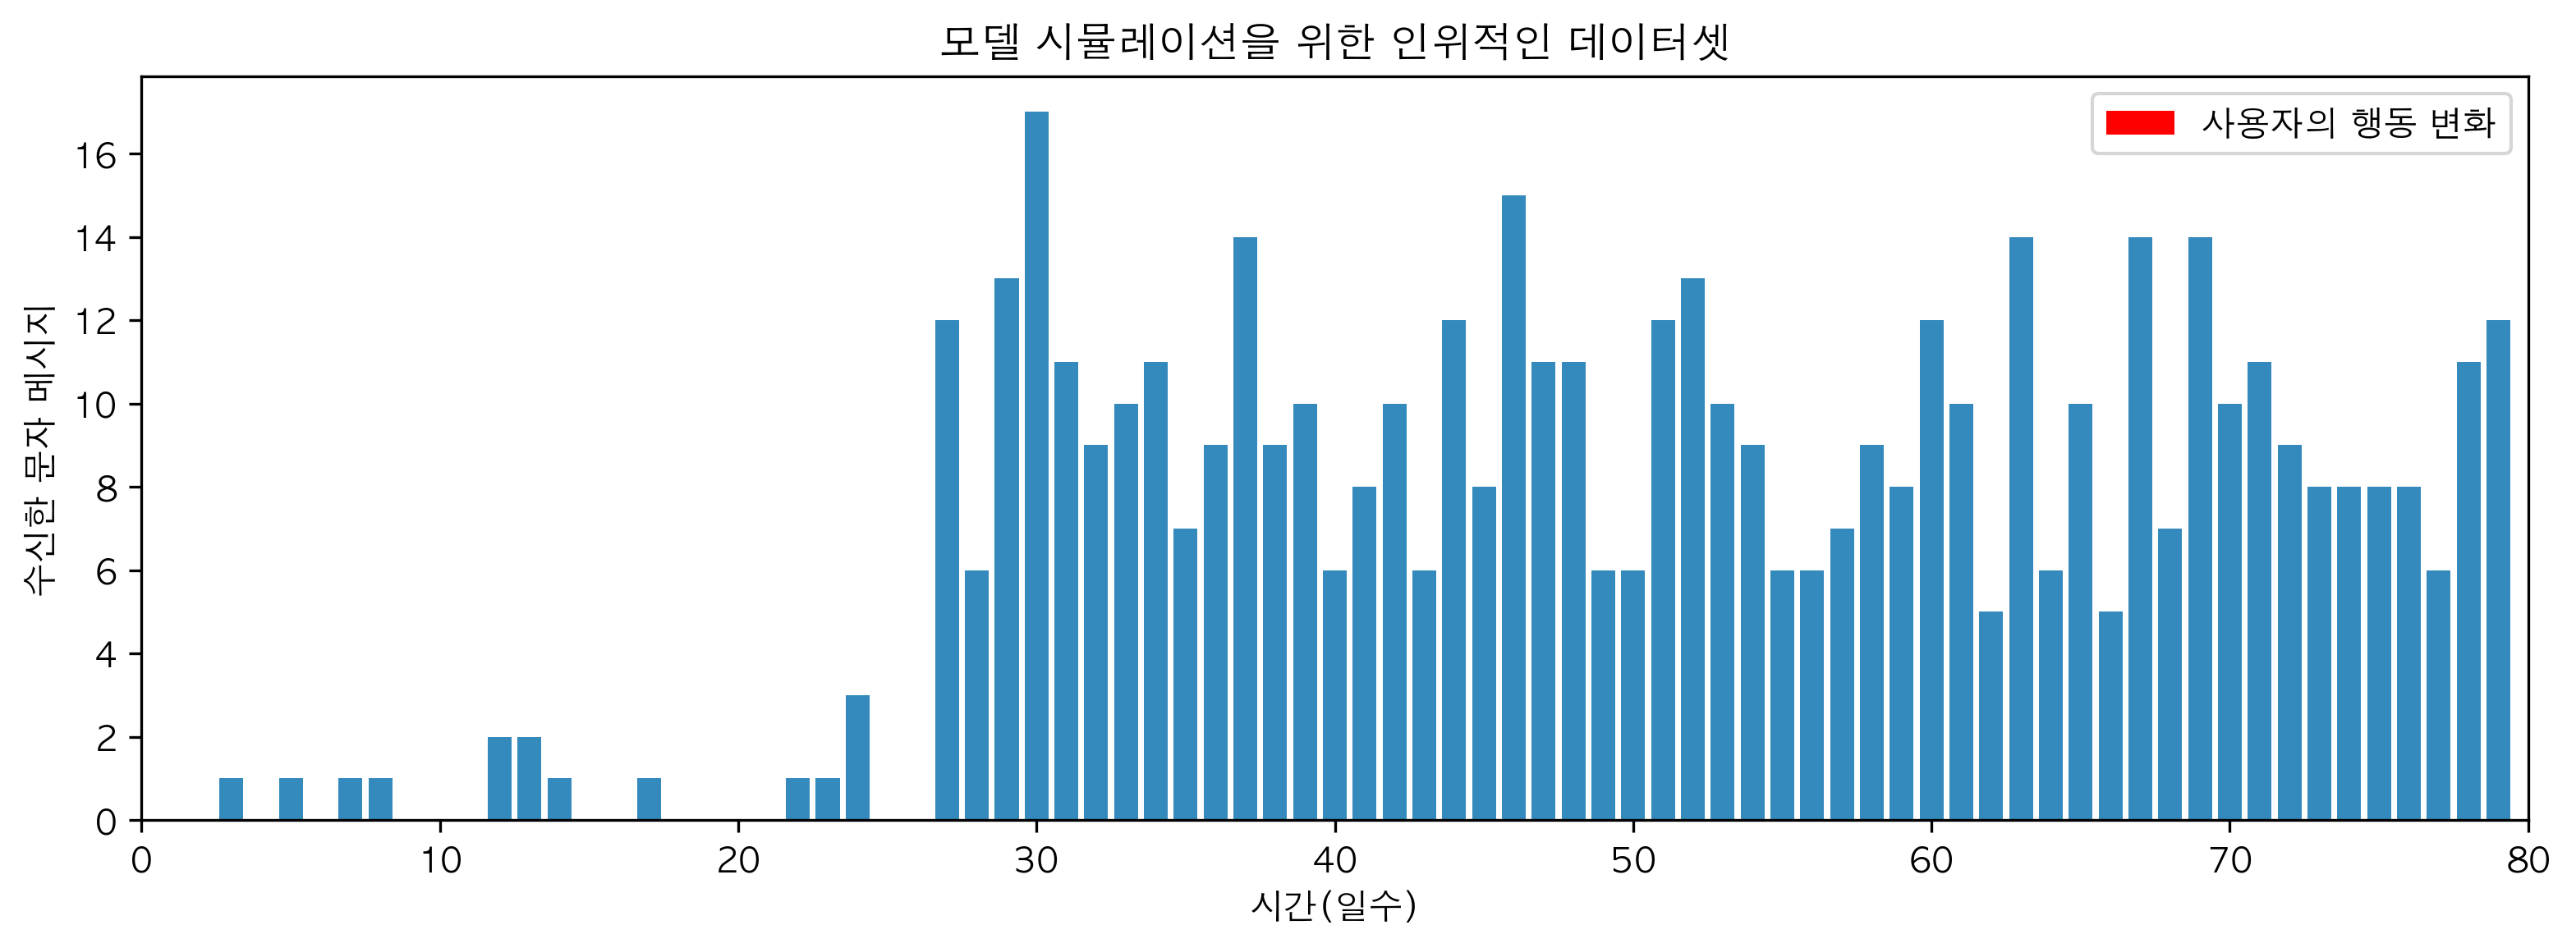

In [25]:
plt.bar(np.arange(80), data, color='#348ABD')
plt.bar(tau-1, data[tau-1], color='r', label='사용자의 행동 변화')
plt.xlabel('시간(일수)')
plt.ylabel('수신한 문자 메시지')
plt.title('모델 시뮬레이션을 위한 인위적인 데이터셋')
plt.xlim(0, 80)
plt.legend();

위에 그래프는 1장에서 보았던 결과와는 많이 다르다. 위의 데이터는 임의의 값을 가지고 시뮬레이션한 결과이며, `PyMC`모듈을 이용해 이러한 값 $(\lambda_i, \tau)$를 찾도록 설계되어있다. 

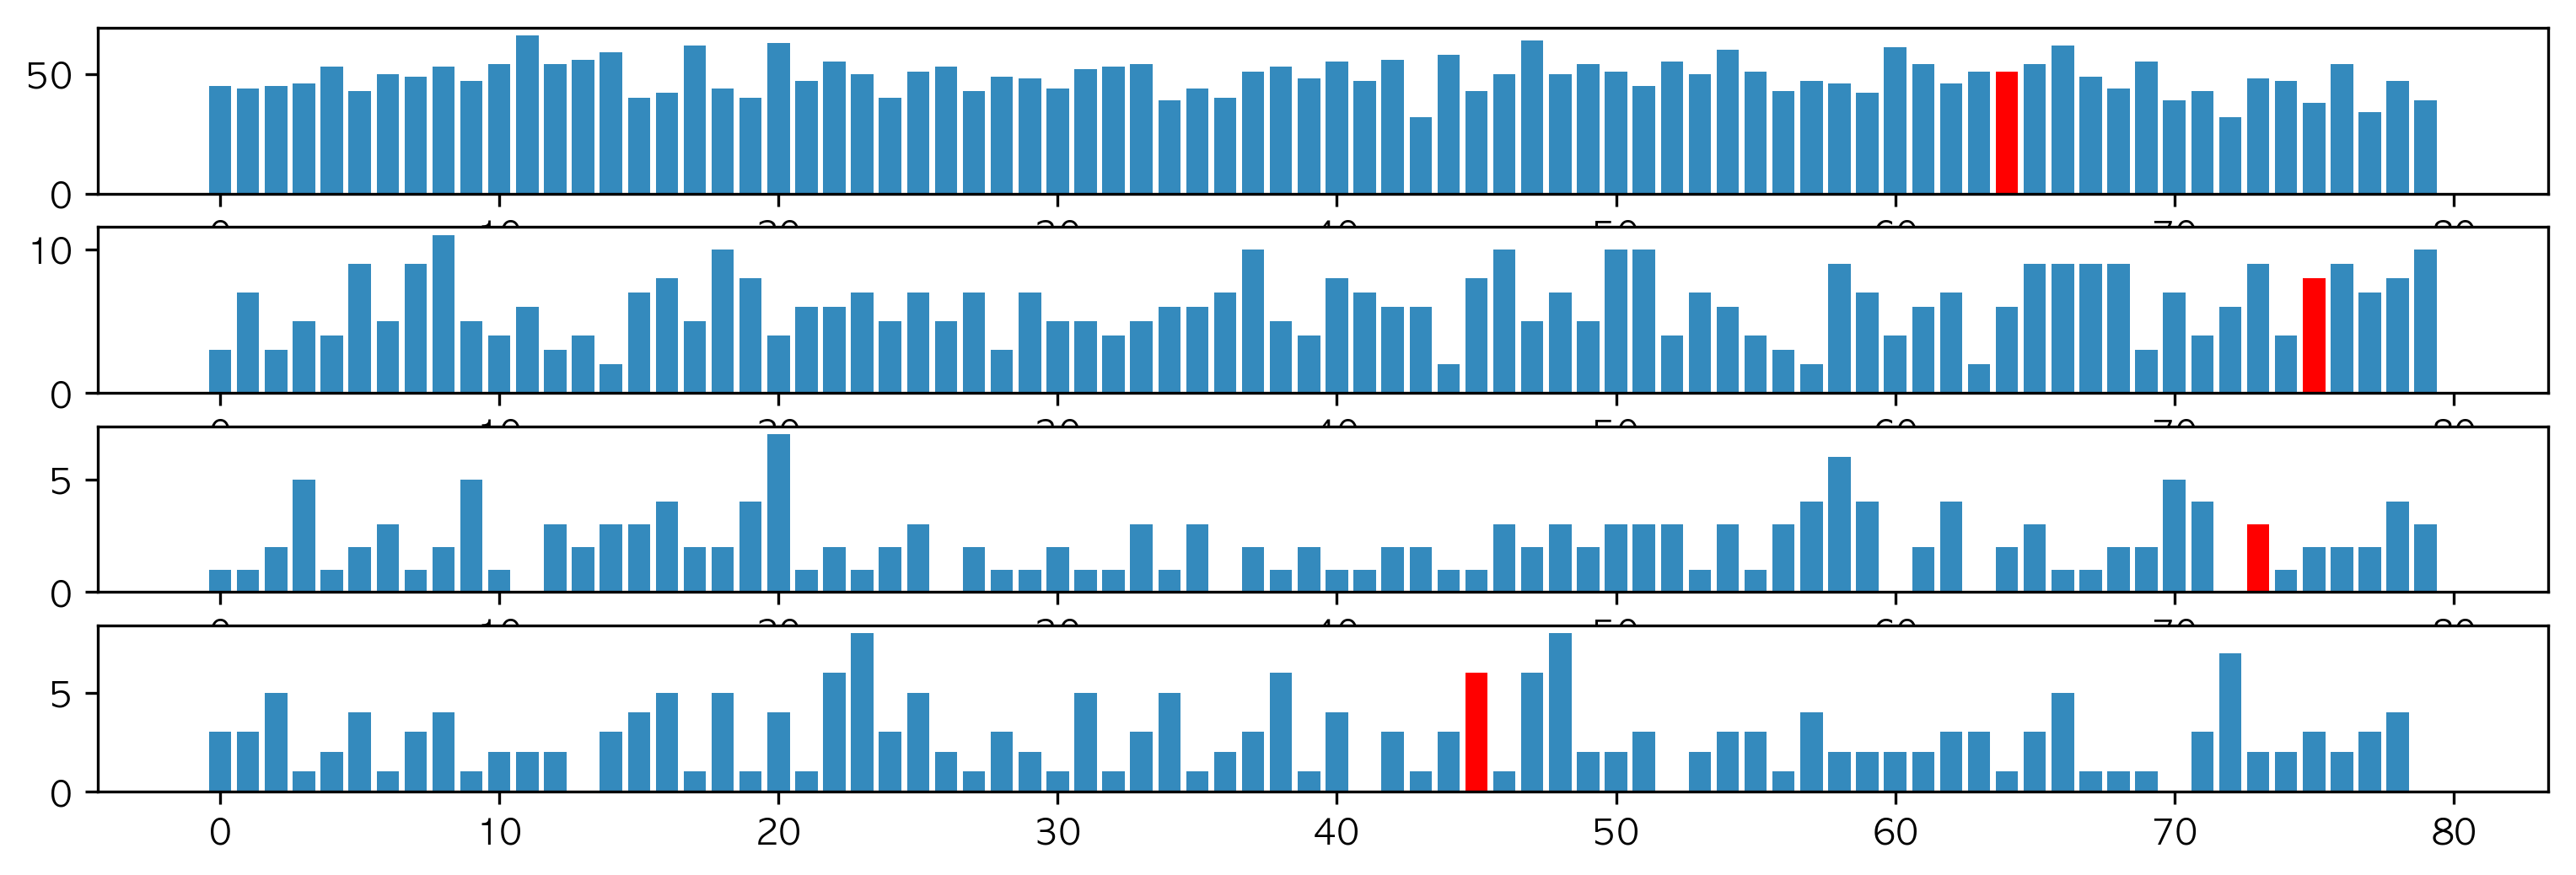

In [26]:
def plot_artificial_sms_dataset():
    tau = pm.rdiscrete_uniform(0, 80)
    alpha = 1./20.
    lambda_1, lambda_2 = pm.rexponential(alpha, 2)
    data = np.r_[pm.rpoisson(lambda_1, tau), pm.rpoisson(lambda_1, 80-tau)]
#     figsize(12.5, 5)
    plt.bar(np.arange(80), data, color='#348ABD')
    plt.bar(tau-1, data[tau-1], color='r', label='사용자의 행동 변화')
#     plt.xlabel('시간(일수)')
#     plt.ylabel('수신한 문자 메시지')
#     plt.title('모델 시뮬레이션을 위한 인위적인 데이터셋')
    
    
for i in range(4):
    plt.subplot(4, 1, i+1)
#     plt.xlabel('시간(일수)')
#     plt.ylabel('수신한 문자 메시지')
    plot_artificial_sms_dataset()

### 2.2.2 예제: 베이지안 A/B 테스트

A/B 테스트는 서로 다른 두 가지 방법 간의 효과의 차이를 밝히기 위한 통계적 디자인 패턴이다. 

> 예를 들어 어느 웹사이트 디자인이 더 많은 **전환율**(conversion)을 내는지 알고 싶어한다. 웹 개발자는 방문객의 일부는 A 사이트로 이동시키고, 나머지 방문객은 B 사이트로 이동시켜, 두 사이트의 전환율을 분석한다. 

A/B 테스트의 핵심은 그룹 간의 차이점이 단 하나뿐이라는 점이다. 따라서 측정값의 의미있는 변화가 바로 차이로 연결될 수 있다.

사후실험분석은 보통 **평균차이검정**(difference of means test)이나 **비율차이검정**(difference of proportion test)와 같은 **가설검정**(hypothesis test)라는 것을 사용한다. 

이번 장에서는 베이지안적으로 이 문제를 해결하는 방법에 대해 알아보자.

### 2.2.3 간단한 예제

위의 웹 개발 예제를 계속 살펴보자. 우선 A 사이트 분석에 초점을 맞춰 A 사이트에 노출된 사용자가 전환할 확률 $P_A$가 있다고 가정하자. 

A 사이트가 $N$명에게 노출되었고, $n$명이 전환했다고 가정하면, $P_A = \frac{n}{N}$ 이라고 결론 내릴지도 모른다. 하지만 **관측된 빈도** $\frac{n}{N}$이 반드시 $P_A$와 같은 것은 아니다. **관측된 빈도**와 사건의 **실제 빈도** 간에는 차이가 있다. 실제 빈도는 사건이 일어날 확률로 해석될 수 있으며, 이는 반드시 관측된 빈도와 같은 것은 아니다.
> 예를 들어 주사위를 던져 1이 나올 실제 확률은 $\frac{1}{6}$ 이지만, 주사위를 여섯 번 굴려서 1을 한번도 관측하지 못할 수도 있다(관측된 빈도).

우리는 노이즈와 복잡성(complexities)때문에 실제 빈도를 알지 못하므로 관측된 데이터로 실제 빈도를 **추론**해야 한다. 이것을 베이지안 통계를 사용하여 적절한 사전확률 및 관측된 데이터를 사용하여 실제 빈도의 추정값을 추론한다.위의 예제 같은 경우, 알고있는 $N$(총 방문자 수)과 $n$(전환한 사람 수)를 사용하여 $P_A$가 얼마인지 추정하고자 한다.

베이지안 모델을 설정하려면 사전확률분포를 할당해야 한다. $P_A$에 대한 확신이 뚜렷하지 않으므로, 지금은 $P_A$를 $[0, 1]$에 대한 균등분포로 가정하자.

In [27]:
# import pymc as pm

# 모수는 Uniform 범위 내이다.
p = pm.Uniform('p', lower=0, upper=1)
print(p.value)

0.4126697284034585


이 예제에서 $P_A = 0.05$, A 사이트에 노출된 사용자 수 $N=1,500$라고 가정하자. 사용자가 구매를 했는지 안했는지 여부를 시뮬레이션 할 것이다. $N$번 시행하여 이를 시뮬레이션하기 위해 **베르누이분포**(Bernoulli distribution, Y/N와 같이 두 가지 상황만 일어나는 경우에 적용)를 사용한다. 베르누이분포는 이진확률변수(0 또는 1만 가능한)이고, 위의 예제의 관측치 또한 이진(전환/비전환)이므로 적합하다.

$X \sim Berp(p)$이면 $X$는 $p$의 확률로 1이고, $1-p$의 확률로 0이다. 우리는 실제 $P_A$를 알지 못하지만, 이것을 사용하여 가상의 데이터를 시뮬레이션한다.

In [28]:
# 상수 설정
p_true = 0.05  # 실제로는 이 값은 미지수이다.
N = 1500

# Berp(0.05)로 부터 N개의 베르누이 확률변수를 표본추출한다.
# 각 확률변수가 1일 확률은 0.05다.
# 이것은 데이터 생성 단계
occurrences = pm.rbernoulli(p_true, N)

print(occurrences)  # True=1, False=0
print(occurrences.sum())
# print(type(occurrences))

[False False  True ..., False False  True]
86


In [29]:
# occurrences.mean은 n/N이다.
print('A 사이트에서 관측된 빈도는 얼마인가 {:.4f}'.format(occurrences.mean()))
print('실제 빈도와 같은가? %s' % (occurrences.mean() == p_true))

A 사이트에서 관측된 빈도는 얼마인가 0.0573
실제 빈도와 같은가? False


관측된 데이터를 `PyMC`의 `observed`변수에 합쳐 추론 알고리즘을 실행한다.

In [30]:
# 베르누이 관측치를 포함한다.
obs = pm.Bernoulli('obs', p, value=occurrences, observed=True)

# 3장에서 설명
mcmc = pm.MCMC([p, obs])
mcmc.sample(20000, 1000)

 [-----------------100%-----------------] 20000 of 20000 complete in 1.0 sec

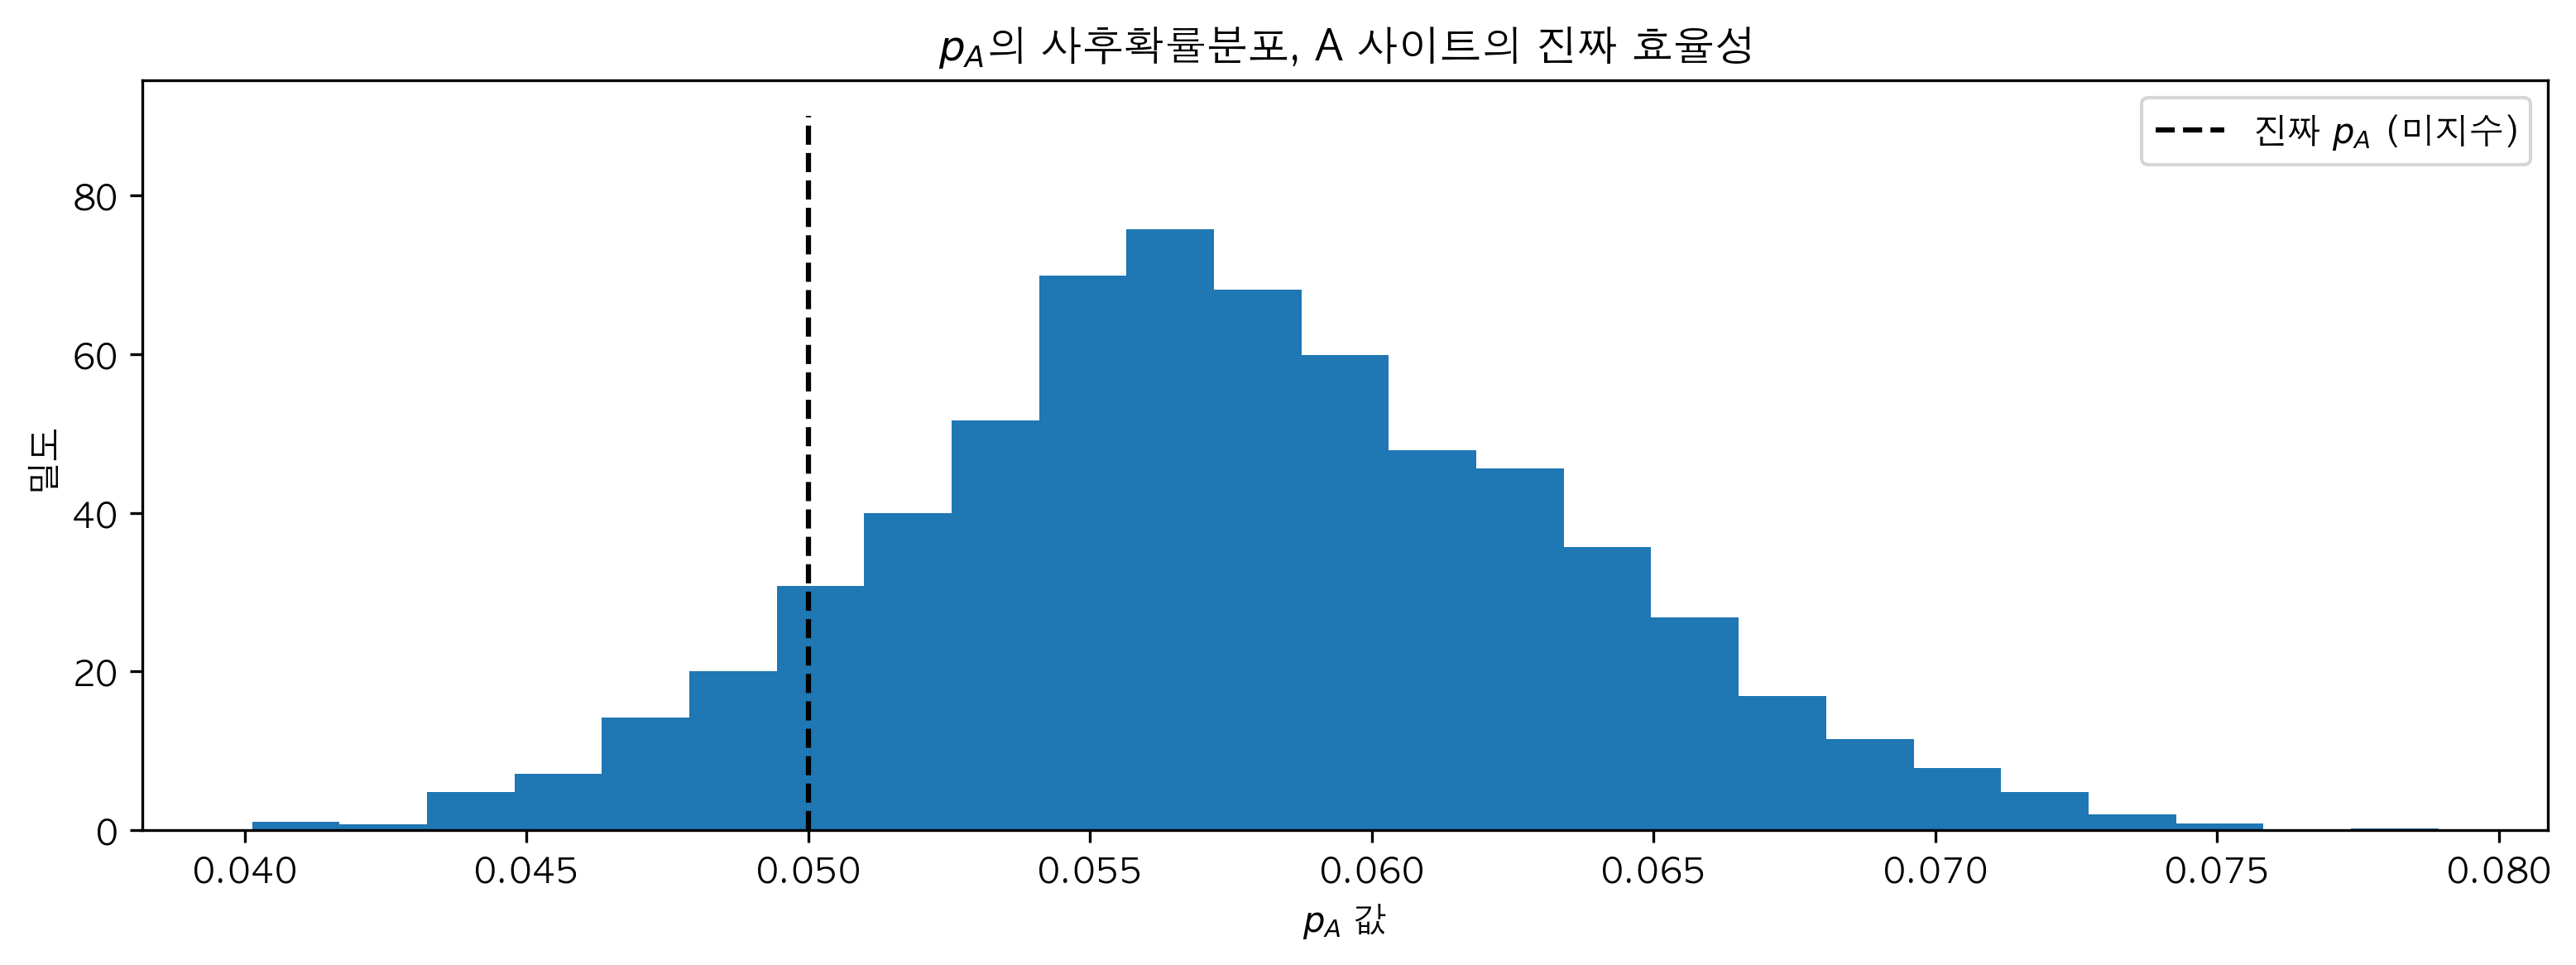

In [31]:
figsize(12.5, 4)
plt.title("$p_A$의 사후확률분포, A 사이트의 진짜 효율성")
plt.vlines(p_true, 0, 90, linestyle="--", label="진짜 $p_A$ (미지수)")
plt.hist(mcmc.trace("p")[:], bins=25, histtype="stepfilled", density=True)
plt.xlabel("$p_A$ 값")
plt.ylabel("밀도")
plt.legend();

### 2.2.4 A와 B를 묶어 보기

B 사이트의 데이터로 비슷한 분석을 수행하면 $P_B$의 사후확률분포를 알 수 있다. 우리가 정말로 알고싶은 것은 $P_A$와 $P_B$간의 **차이**이다. $P_A, P_B$ 그리고 $\delta = P_A - P_B$를 추론해보자. 

`PyMC`의 `deterministic` 변수를 사용하여 이를 추론할 수 있다. $P_B=0.04$ $\delta = P_A-P_B = 0.01$로 가정하자. 그리고 $N_B = 750$이라 하자.

In [32]:
figsize(12, 4)

# 다음 둘은 미지수다.
true_p_A = 0.05
true_p_B = 0.04

# 표본의 크기는 다르지만 베이지안 분석에서는 문제가 되지 않는다.
N_A = 1500
N_B = 750

# 관측치를 생성한다.
observations_A = pm.rbernoulli(true_p_A, N_A)
observations_B = pm.rbernoulli(true_p_B, N_B)
print('Obs from Site A:', observations_A[:30].astype(int), '...')
print('Obs from Site B:', observations_B[:30].astype(int), '...')

Obs from Site A: [0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...
Obs from Site B: [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0] ...


In [33]:
print(observations_A.mean())
print(observations_B.mean())

0.0526666666667
0.0386666666667


In [34]:
# pmc 모델 설정. P_A와 P_B는 Uniform 사전확률로 가정한다.
p_A = pm.Uniform('p_A', 0, 1)
p_B = pm.Uniform('p_B', 0, 1)

# deterministic delta 함수 정의. 
# delta = p_A - p_B 이며, 우리가 알고자 하는 값이다.
@pm.deterministic
def delta(p_A=p_A, p_B=p_B):
    return p_A - p_B

# 관측치 설정. 이 경우 관측 데이터셋이 두 개 있다.
obs_A = pm.Bernoulli('obs_A', p_A, value=observations_A, observed=True)
obs_B = pm.Bernoulli('obs_B', p_B, value=observations_B, observed=True)

# 3장 설명 예정
mcmc = pm.MCMC([p_A, p_B, delta, obs_A, obs_B])
mcmc.sample(25000, 5000)

 [-----------------100%-----------------] 25000 of 25000 complete in 1.8 sec

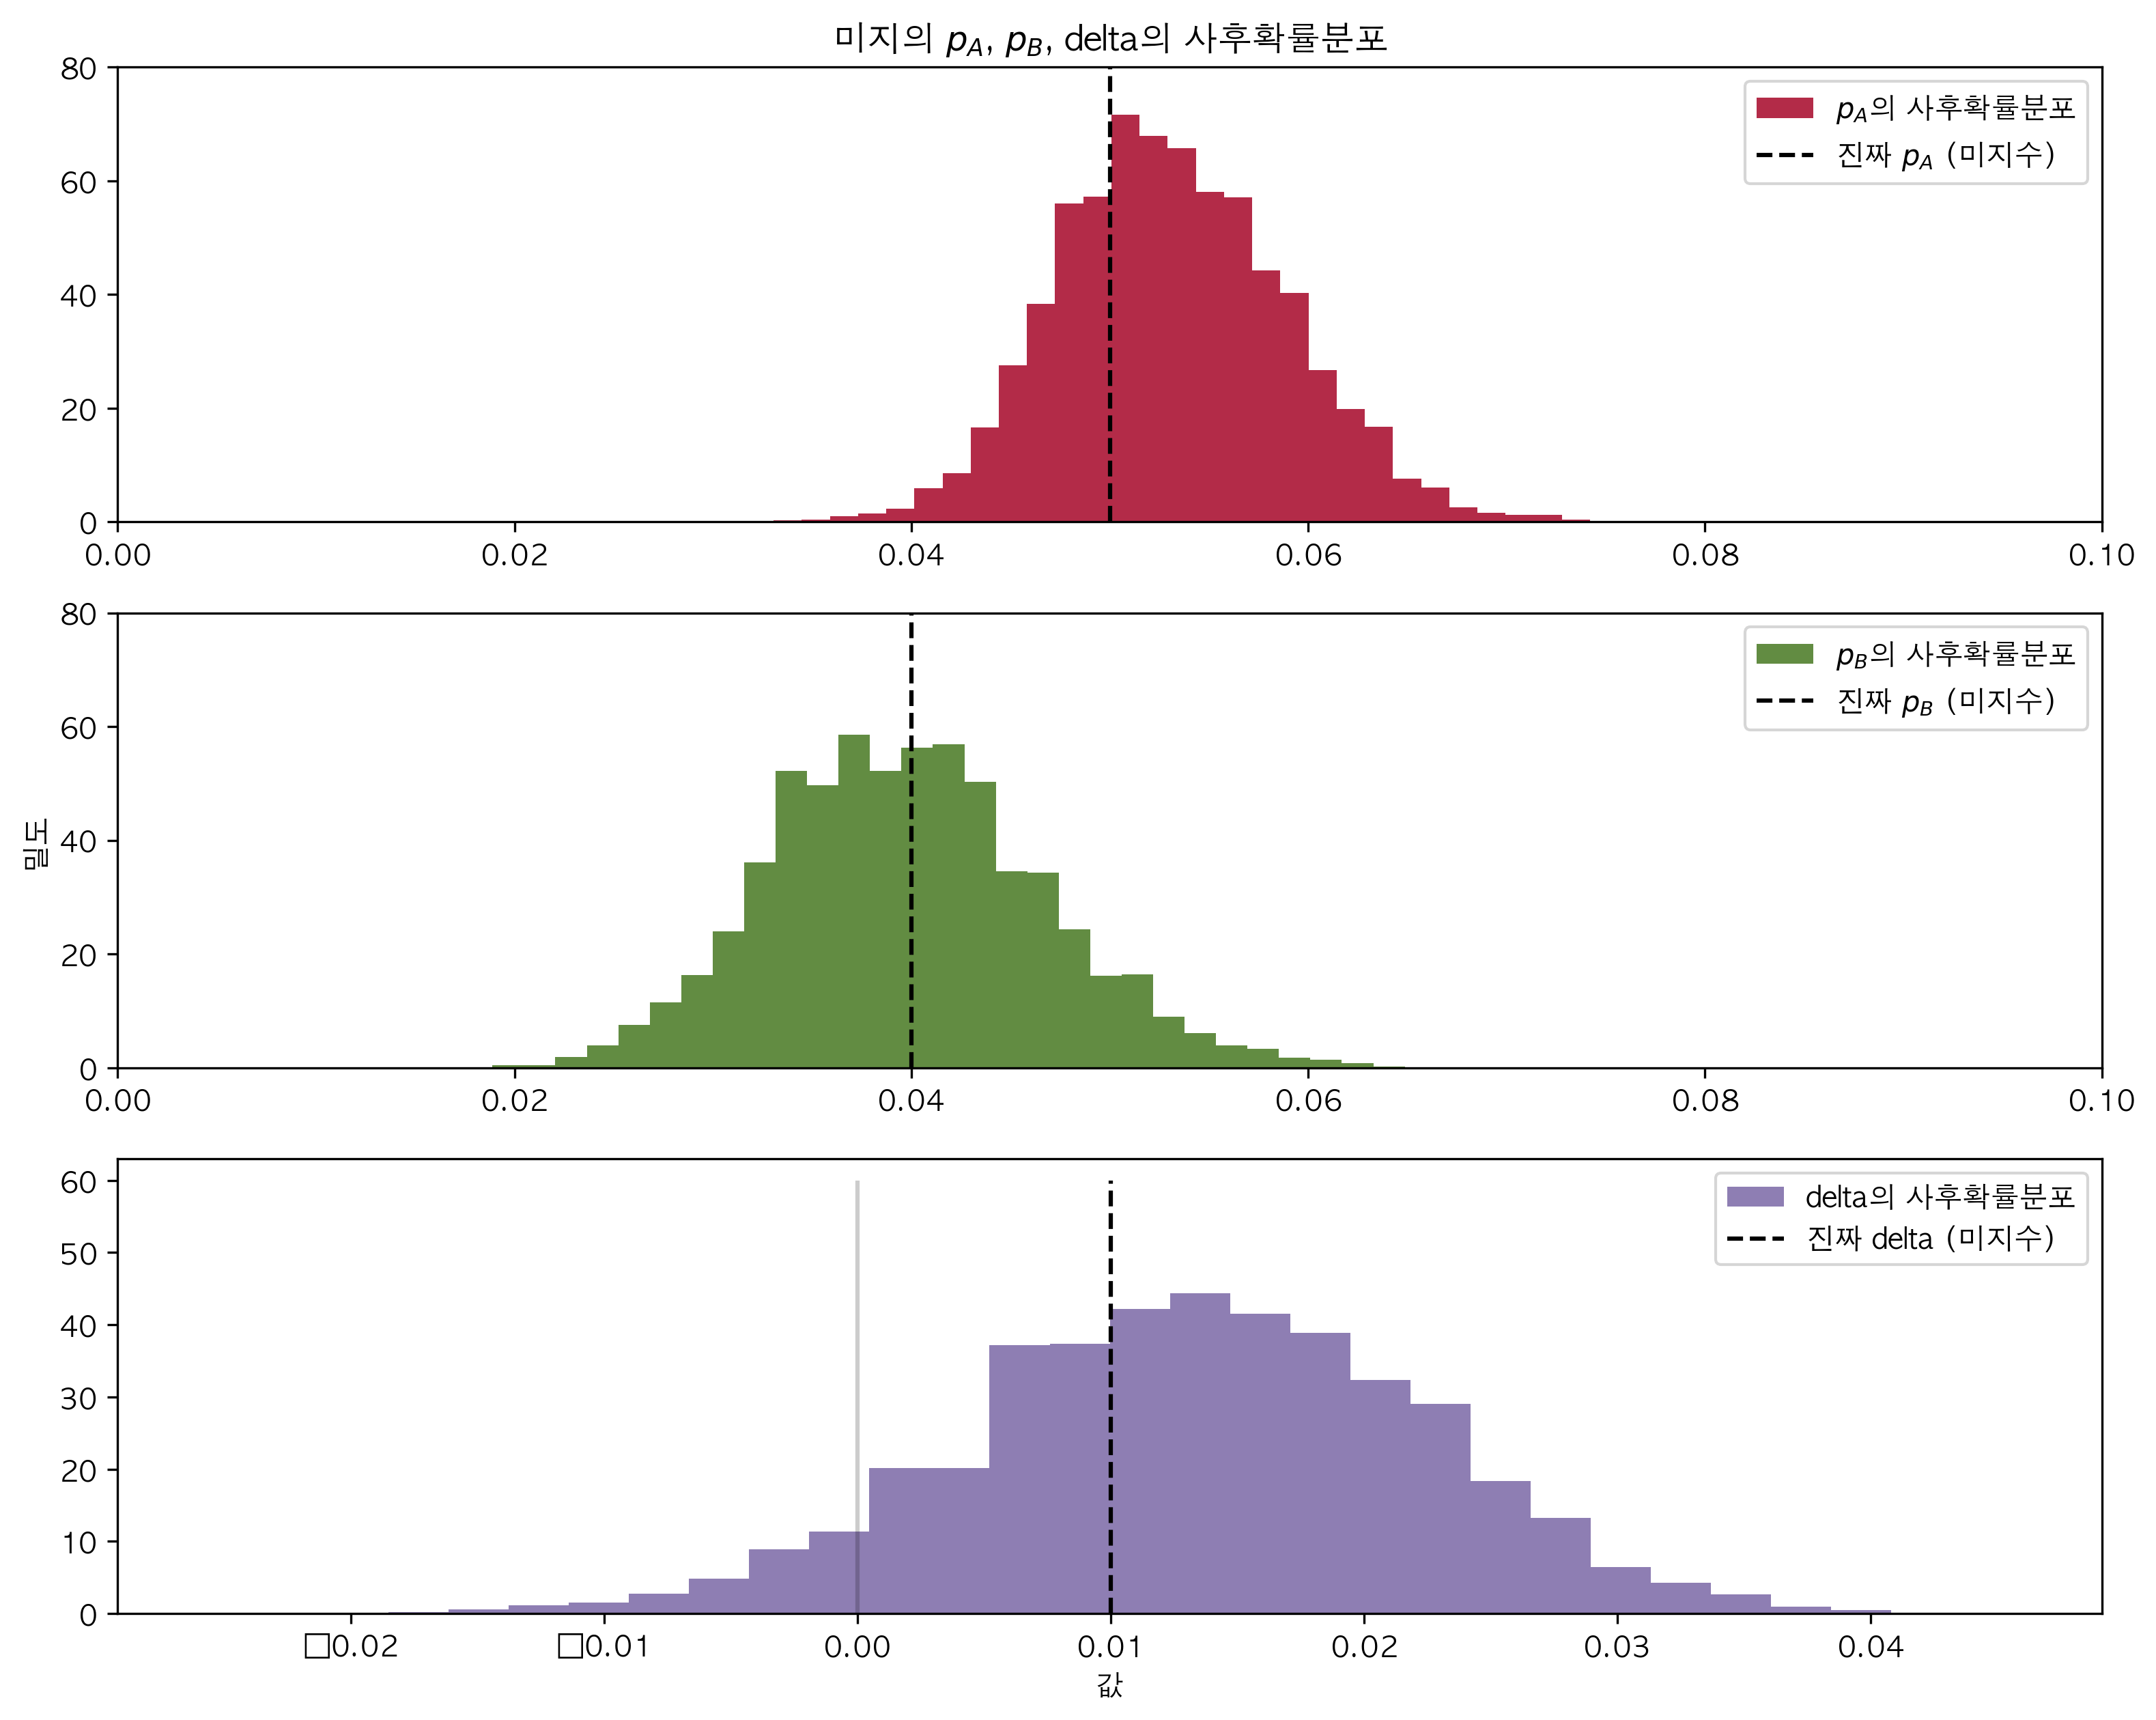

In [35]:
p_A_samples = mcmc.trace("p_A")[:]
p_B_samples = mcmc.trace("p_B")[:]
delta_samples = mcmc.trace("delta")[:]

figsize(12.5, 10)

# 사후확률분포의 히스토그램
ax = plt.subplot(311)
plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="$p_A$의 사후확률분포", color="#A60628", density=True)
plt.vlines(true_p_A, 0, 80, linestyle="--", label="진짜 $p_A$ (미지수)")
plt.legend(loc="upper right")
plt.title("미지의 $p_A$, $p_B$, delta의 사후확률분포")
plt.ylim(0,80)

ax = plt.subplot(312)
plt.xlim(0, .1)
plt.hist(p_B_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="$p_B$의 사후확률분포", color="#467821", density=True)
plt.vlines(true_p_B, 0, 80, linestyle="--", label="진짜 $p_B$ (미지수)")
plt.ylabel("밀도")
plt.legend(loc="upper right")
plt.ylim(0,80)

ax = plt.subplot(313)
plt.hist(delta_samples, histtype='stepfilled', bins=30, alpha=0.85,
         label="delta의 사후확률분포", color="#7A68A6", density=True)
plt.vlines(true_p_A - true_p_B, 0, 60, linestyle="--", label="진짜 delta (미지수)")
plt.vlines(0, 0, 60, color="black", alpha=0.2)
plt.xlabel("값")
plt.legend(loc="upper right");

N_B < N_A 이므로 $P_B$의 사후확률분포가 더 평평한데, 이는 $P_A$와 달리 $P_B$의 실제 값에 대한 확신이 부족하다는 것을 의미한다.

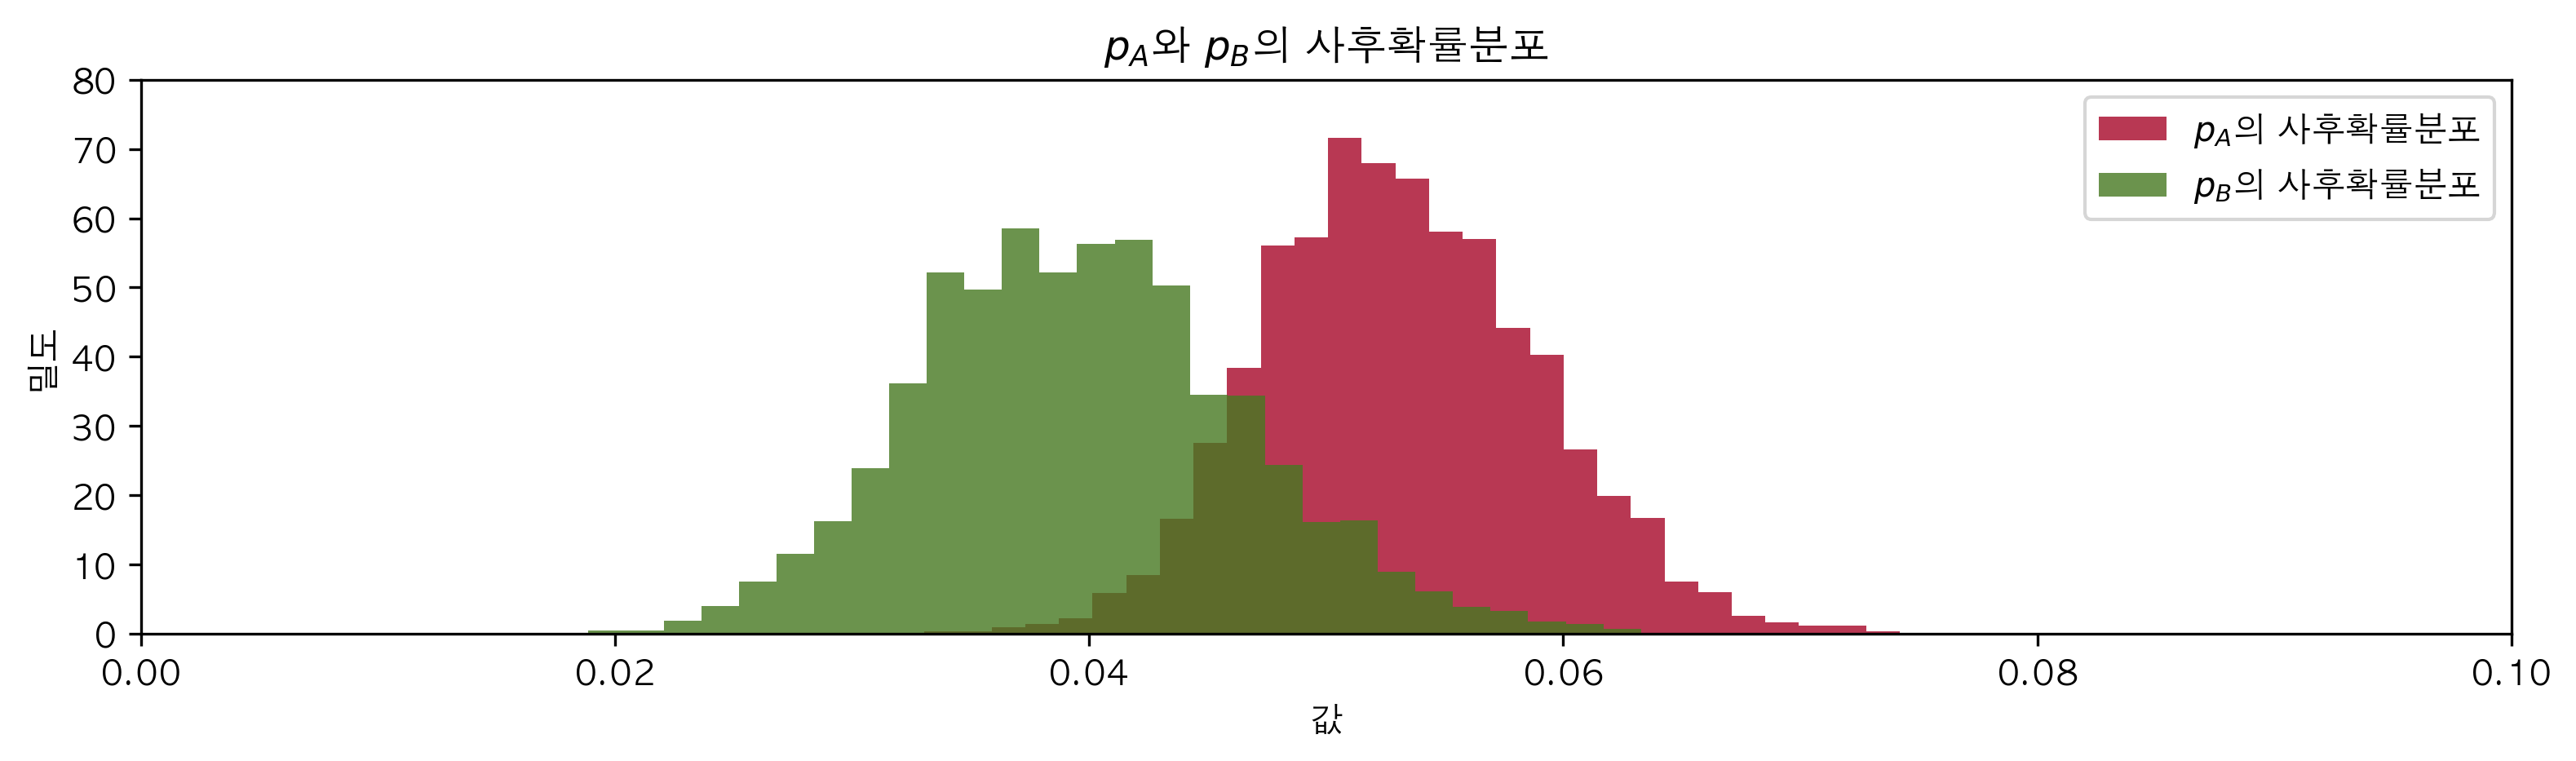

In [36]:
figsize(12.5, 3)
# 사후확률분포의 히스토그램
plt.xlim(0, .1)
plt.hist(p_A_samples, histtype='stepfilled', bins=30, alpha=0.80,
         label="$p_A$의 사후확률분포", color="#A60628", density=True)
plt.hist(p_B_samples, histtype='stepfilled', bins=30, alpha=0.80,
         label="$p_B$의 사후확률분포", color="#467821", density=True)
plt.legend(loc="upper right")
plt.xlabel("값")
plt.ylabel("밀도")
plt.title("$p_A$와 $p_B$의 사후확률분포")
plt.ylim(0,80);

위의 그림에서 delta($\delta$)의 사후확률분포 대부분이 $\delta = 0$ 이상임을 확인할 수 있다. 이것은 A사이트의 응답이 B사이트보다 낫다는 것을 의미한다. 이 추론이 부정확할 확률은 다음과 같이 계산할 수 있다.

In [37]:
# 0이하 표본의 개수를 센다. delta = P_A - P_B 이므로
# 0 이하 영역은 A 사이트가 B 사이트보다 나쁠 확률을 의미한다.
print('A 사이트가 B 사이트보다 나쁠 확률: %.3f' % (delta_samples < 0).mean())
print('A 사이트가 B 사이트보다 나을 확률: %.3f' % (delta_samples > 0).mean())

A 사이트가 B 사이트보다 나쁠 확률: 0.070
A 사이트가 B 사이트보다 나을 확률: 0.930


*2.2.5 생략*

### 2.2.6 이항분포 - Binomial distribution

이항분포는 두 개의 모수, $N$과 $p$를 가진다.

- $N$ : 양의 정수로 시행의 수 또는 가능한 사건의 경우의 수를 의미한다. 
- $p$ : 한 번 시행했을 때 사건이 일어날 확률이다. 

$$
P(X=k)=\left( \begin{matrix} N \\ k \end{matrix} \right)p^k (1-p)^{-k}
$$

만약, $X$가 $p$와 $N$을 모수로 가진 이항확률변수 $X \sim Bin(N,p)$라면 $X$는 $N$번의 시행($0 \le X \le N$)에서 발생하는 사건의 수다. $p$가 클수록 ($0 \le p \le 1$) 사건이 일어날 가능성이 커진다. 

$$
E(X) = np
$$
$$
Var(X) = np(1-p)
$$

베르누이 확률변수 $X_1, X_2, \dots , X_N$이 있다면 $Z=X_1 + X_2 + \cdots + X_N$은 모수가 $N$과 $p$인 이항분포를 따른다.

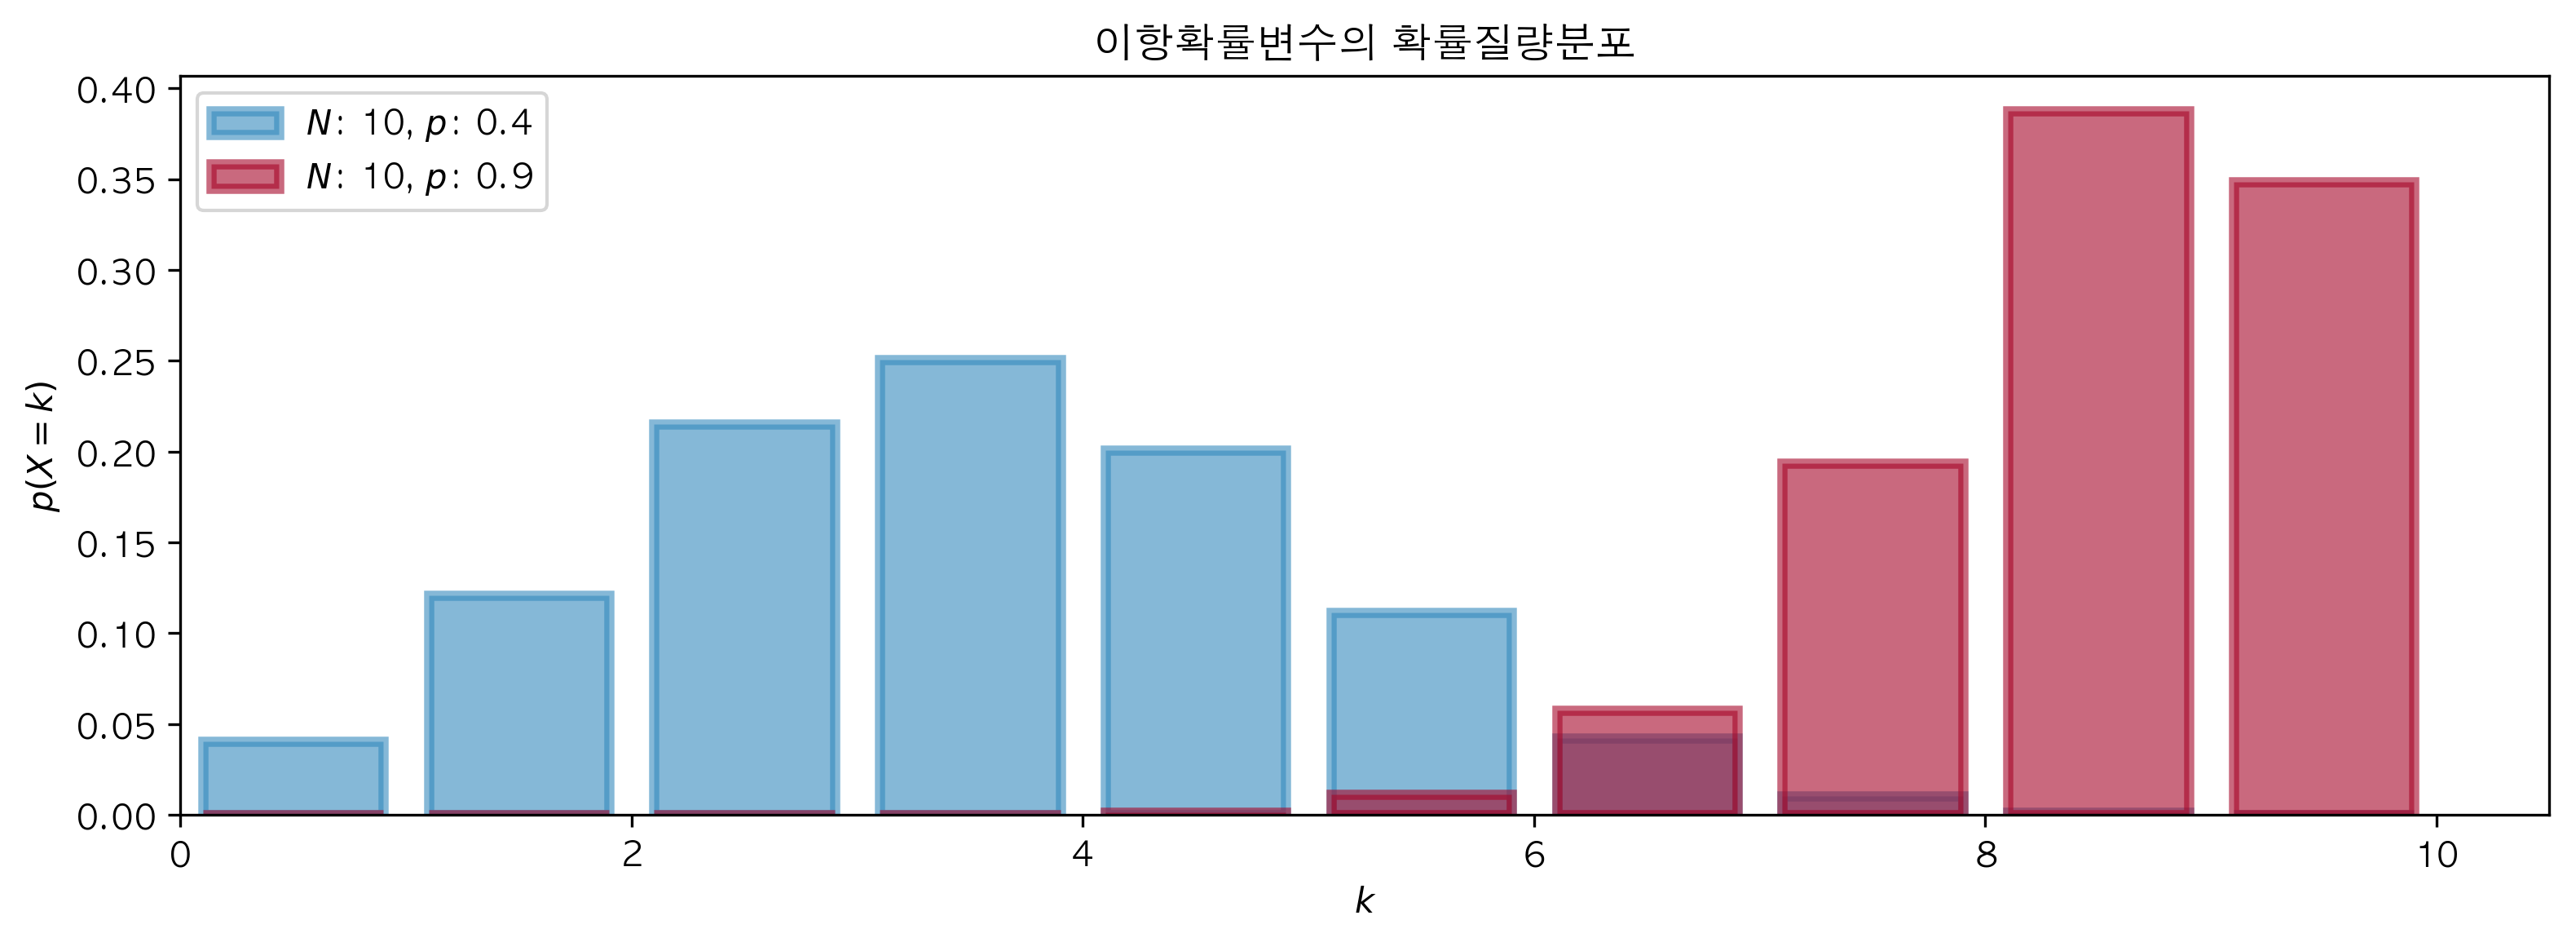

In [38]:
figsize(12.5, 4)

import scipy.stats as stats
binomial = stats.binom

parameters = [(10, .4), (10, .9)]
colors = ['#348ABD', '#A60628']

for i in range(2):
    N, p = parameters[i]
    _x = np.arange(N + 1)
    plt.bar(_x - 0.5, binomial.pmf(_x, N, p), color=colors[i], edgecolor=colors[i], 
            alpha=0.6, label='$N$: %d, $p$: %.1f' % (N, p), linewidth=3)
    
    plt.legend(loc='upper left')
    plt.xlim(0, 10.5)
    plt.xlabel('$k$')
    plt.ylabel('$p(X=k)$')
    plt.title('이항확률변수의 확률질량분포')

### 2.2.7 예제: 학생들의 부정행위

위에서 살펴본 이항분포를 사용하여 학생들이 시험 중에 부정행위를 저지르는 빈도를 구하는 예제를 살펴보자. 

- $N$ : 시험을 응시한 총 학생수
- $X$ : 부정행위를 한 학생 수
- $p$ : 부정행위자의 비율

위에서 주어진 $N$, $p$에 대한 일부 정해진 사전분포, 관찰된 데이터 X를 알면 $p$의 사후확률분포를 얻을 수 있다.

> 학생들은 인터뷰할 때 각자 숨겨둔 동전을 하나 던진다. 인터뷰하는 사람은 모른다. 동전의 앞면이 나온 학생은 
정직하게 대답한다. 동전의 뒷면이 나온 학생은(몰래) 동전을 다시 던져 앞면이 나오면 “네, 부정행위를 했습니다
”라고 대답하고, 뒷면이 나오면 “부정행위를 하지 않았습니다”라고 대답하는 것에 동의한다. 이런 방법을 사용하
면 인터뷰하는 사람은 “예”라는 답변이 부정행위를 인정한 진술의 결과인지 아니면 두 번째 동전 던지기에서 앞
면이 나온 결과인지 모른다. 그래서 프라이버시는 지켜지고 연구자는 정직한 답변을 받는다.

부정행위에 대해 학생 100명을 조사한다고 가정하자. 우리는 부정행위자의 비율인 $p$를 찾으려 한다. 이를 $PyMC$에서 모델링하는 방법이 몇가지 있다. $p$에 대해 전혀 모르므로 $p$의 사전확률로 `Uniform(0, 1)`을 부여한다.

In [39]:
# import pymc as pm

N = 100
p = pm.Uniform('freq_cheating', 0, 1)
print(p.value)

0.23050410081848938


학생 100명에게 베르누이 확률변수를 할당한다. 1은 부정행위, 0은 부정행위를 하지 않았다는 것을 의미한다.

In [40]:
true_answers = pm.Bernoulli('truths', p, size=N)
print(true_answers.value)

[False False False False False  True False False False False False False
 False False  True False False  True  True  True False False False  True
  True  True False False False False False False False False False False
 False  True False False False False False False False False  True False
 False False False  True False False False  True False  True False  True
  True False False False  True False False False False False False False
  True False False False False False False False  True False False False
  True False False False  True False False False False False False False
 False False False False]


이제 각 학생이 시행하는 첫 번째 동전 던지기이다. $p = \frac{1}{2}$를 사용해 베르누이 확률변수 100개를 표본추출하여 이 단계를 다시 모델링 할 수 있다. 1은 앞면, 0은 뒷면이다.

In [41]:
first_coin_flips = pm.Bernoulli('first_flips', 0.5, size=N)
print(first_coin_flips.value)

[False  True  True False False False  True  True  True  True  True False
 False  True False  True  True False False False False False  True  True
 False False  True  True  True False  True False False  True False False
 False False False  True  True False False False False  True  True False
 False  True  True  True  True False  True  True  True  True False False
  True False False False False False False  True  True False False False
  True False False False  True  True  True False False  True  True False
 False False False False False False False  True False False False False
  True False False False]


처음 동전 던지기에서 뒤면이 나온 학생은 두 번째 동전 던지기를 시행한다.

In [42]:
second_coin_flips = pm.Bernoulli('second_flips', 0.5, size=N)

이러한 변수를 사용해서 "예"라는 답변이 관측된 비율의 결과추정치를 얻을 수 있다. `PyMC`의 `deterministic` 변수를 사용하여 비율을 얻을 수 있다.

In [43]:
@pm.deterministic
def observed_proportion(t_a=true_answers, fc=first_coin_flips, sc=second_coin_flips):
    observed = fc * t_a + (1-fc) * sc
    return observed.sum() / float(N)

print('observed_proportion:', observed_proportion.value)

observed_proportion: 0.36


In [44]:
X = 35

observations = pm.Binomial('obs', N, observed_proportion, observed=True, value=X)

model = pm.Model([p, true_answers, first_coin_flips, second_coin_flips, observed_proportion, observations])

mcmc = pm.MCMC(model)
mcmc.sample(40000, 15000)

 [-----------------100%-----------------] 40000 of 40000 complete in 7.5 sec

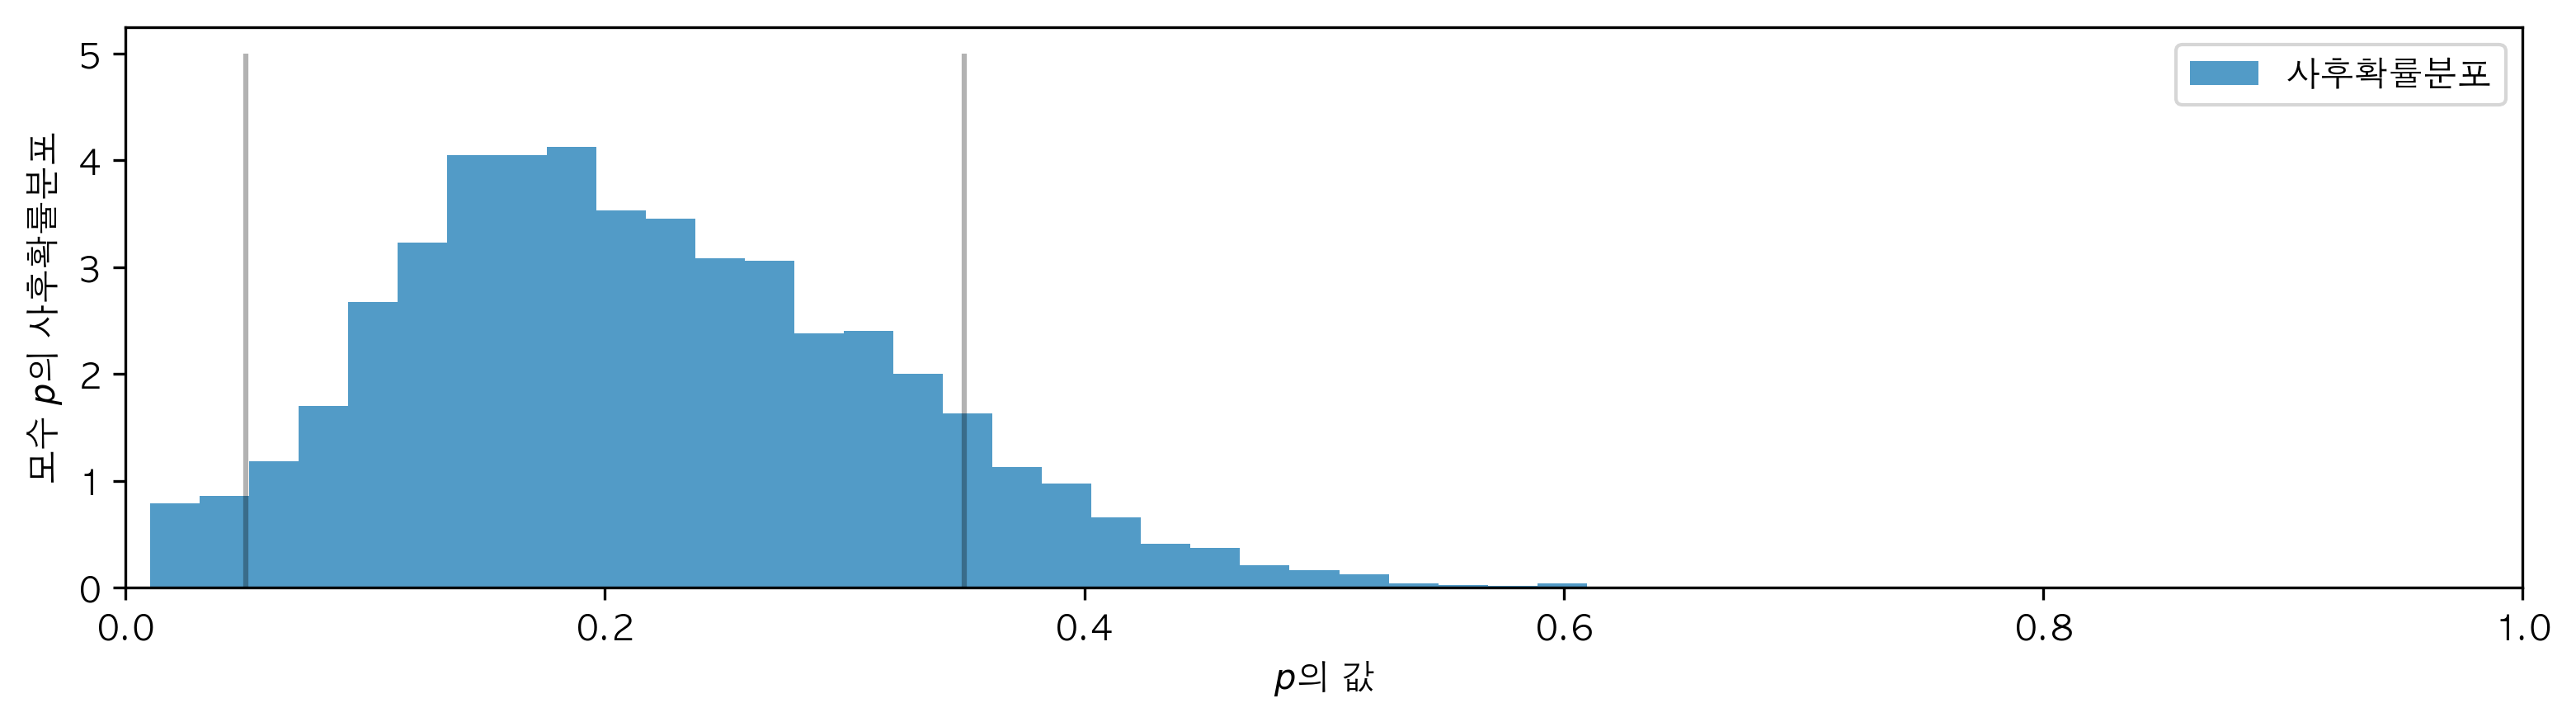

In [45]:
figsize(12.5, 3)

p_trace = mcmc.trace("freq_cheating")[:]
plt.hist(p_trace, histtype="stepfilled", density=True, alpha=0.85, 
         bins=30,label="사후확률분포", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.3)
plt.xlim(0, 1)
plt.xlabel("$p$의 값")
plt.ylabel("밀도")
plt.ylabel("모수 $p$의 사후확률분포")
plt.legend();

### 2.2.8 PyMC 대안 모델

$p$값이 주어진다면 학생들이 "예"(부정행위)라고 대답할 확률을 다음과 같이 구할 수 있다.

$$
P(\text{"yes"})=\begin{cases} =P(\text{Heads on first coin})P(\text{cheater})+P(\text{Tails on first coin})P(\text{Heads on second coin}) \\ =\frac { 1 }{ 2 } p+\frac { 1 }{ 2 } \frac { 1 }{ 2 }  \\ =\frac { p }{ 2 } +\frac { 1 }{ 4 }  \end{cases}
$$

따라서, $p$를 알고 있다면 우리는 한 학생이 "예"라고 대답할 확률을 안다. 

In [46]:
p = pm.Uniform('freq_cheating', 0, 1)

# p_skewed = 0.5*p + 0.25
@pm.deterministic
def p_skewed(p=p):
    return 0.5*p + 0.25

만약 "예"라고 말하는 학생의 `p_skewed`확률을 알고 있으며, 학생수가 $N=100$이라면 "예"라는 답변의 수는 모수가 $N$과 `p_skewed`인 이항확률변수가 된다.

위에서 $X=35$라고 했으므로 `pm.Binomial`에서 `value=35, observed=True`를 입력했다.

In [47]:
yes_responses = pm.Binomial('number_cheaters', 100, p_skewed, value=35, observed=True)
print(yes_responses.value)

35


In [48]:
model = pm.Model([yes_responses, p_skewed, p])
mcmc.sample(25000, 2500)

 [-----------------100%-----------------] 25000 of 25000 complete in 4.8 sec

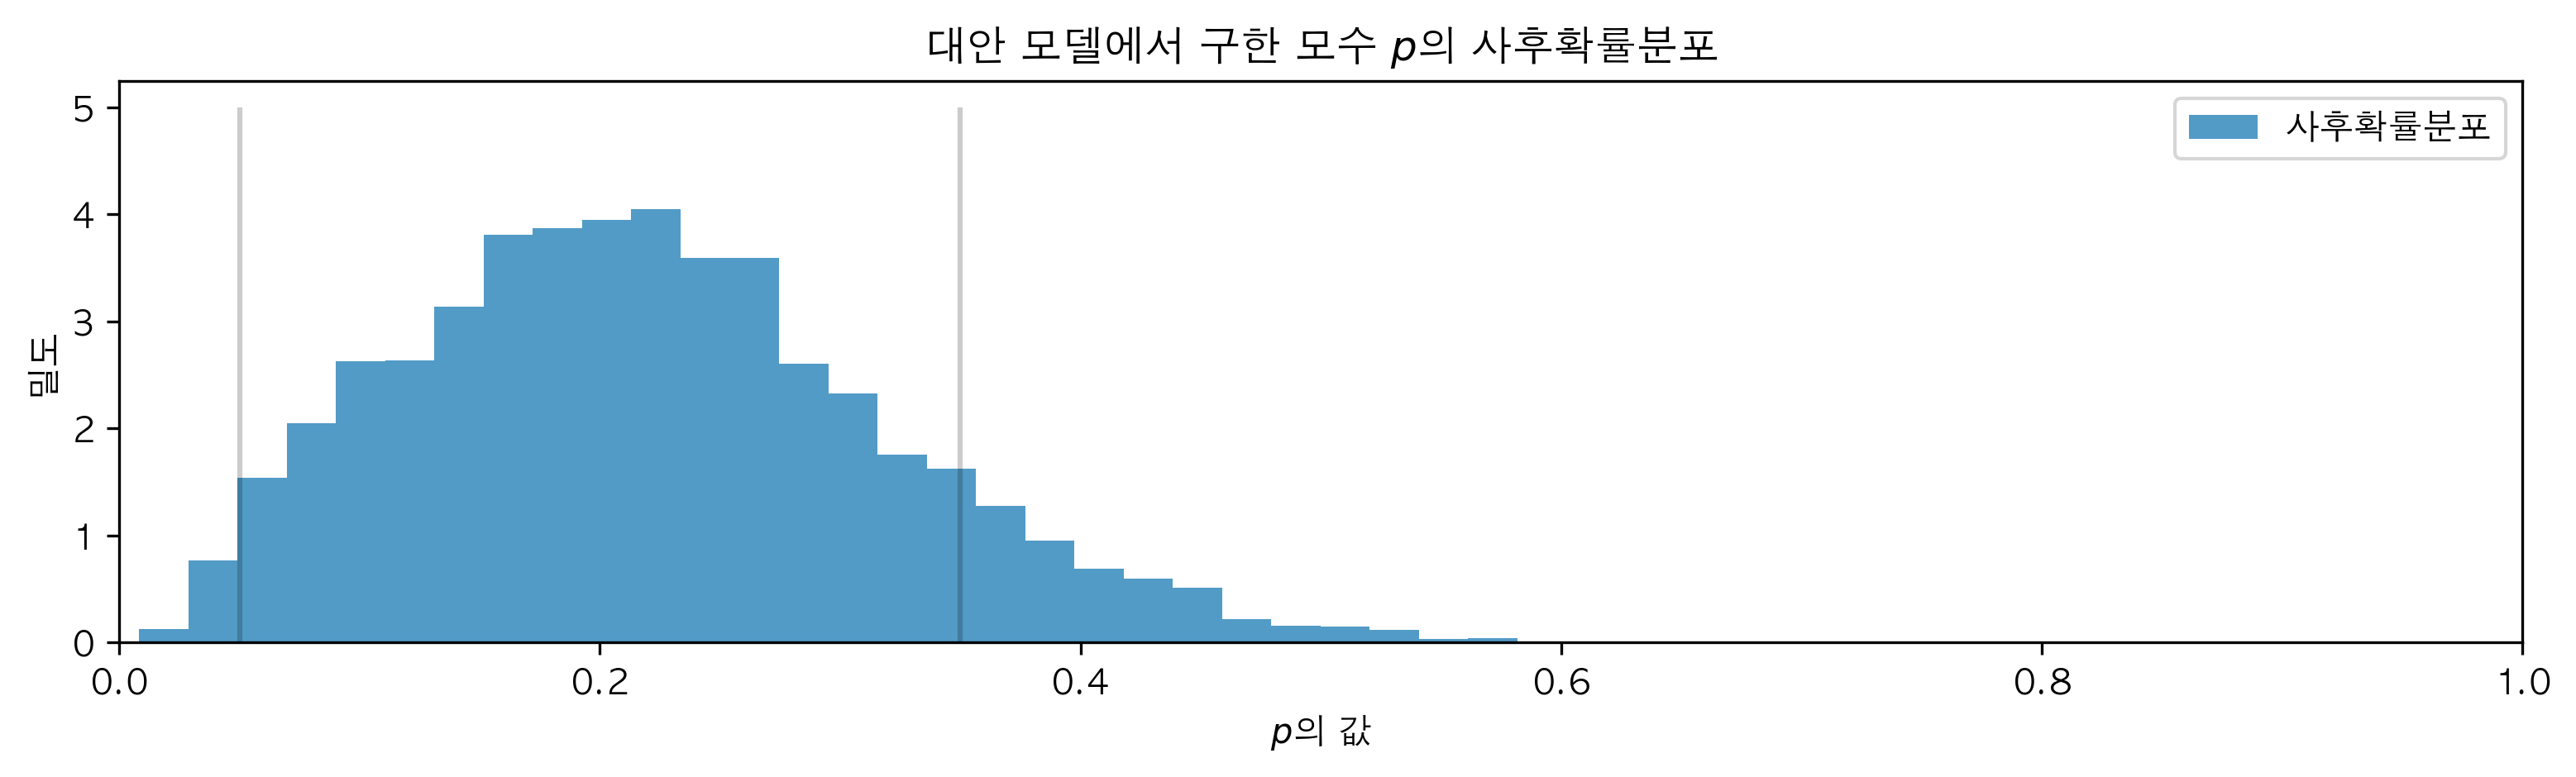

In [49]:
figsize(12.5, 3)
p_trace = mcmc.trace("freq_cheating")[:]
plt.hist(p_trace, histtype="stepfilled", density=True, alpha=0.85, 
         bins=30,label="사후확률분포", color="#348ABD")
plt.vlines([.05, .35], [0, 0], [5, 5], alpha=0.2)
plt.xlim(0, 1)
plt.xlabel("$p$의 값")
plt.ylabel("밀도")
plt.title("대안 모델에서 구한 모수 $p$의 사후확률분포")
plt.legend();

### 2.2.9 더 많은 PyMC 기법들

#### Tip: Lambda 클래스를 가진 더 가벼운 deterministic 변수들

작은 함수에 대해 @pm.deterministic 데코레이션을 사용하여 `deterministic`함수를 작성하는 것이 귀찮을 때가 있다.  이를 `pm.Lambda` 함수를 이용해 단순화할 수 있다.

In [50]:
N = 10
beta = pm.Normal('coefficients', 0, 1, size=(N, 1))
x = np.random.randn(N, 1)
linear_combination = pm.Lambda('Lambda_func', lambda x=x, beta=beta: np.dot(x.T, beta))
print(linear_combination.value)

[[ 0.66473626]]


#### Tip: PyMC 배열 변수

In [51]:
N = 10

x = np.empty(N, dtype=object)  # array([None, ..., None])
for i in range(0, N):
    x[i] = pm.Exponential('x_%i' % i, (i+1)**2)
    
for val in x:
    print(val.value)

0.7016152914731364
0.3790838282983336
0.10357197352486747
0.047150184475512946
0.01881960552164347
0.05009818489629428
0.0064888345166183485
0.010618522718717759
0.02044549057832275
0.005781784112080235


### 2.2.10 예제: 우주 왕복선 챌린저호 참사

> 1986년 1월 28일 미국 우주 왕복선 프로그램의 25번째 비행이 참사로 끝났다. 우주 왕복선 챌린저호의 로켓 부
스터 중 하나가 이륙 후 바로 폭발하면서 승무원 일곱 명이 모두 사망했다. 대통령 직속 사고조사단은 이 사고가
로켓 부스터에 연결된 O링(O-ring)의 결함으로 발생했고, 이 결함은 O링을 외부 온도를 포함하여 많은 요인에
너무 민감하게 반응하도록 만들었기 때문(이런 디자인이 잘못된 디자인)이었다고 결론지었다. 이전 24번의 비행
에서 23번째 비행 시 O링의 결함에 대한 데이터는 유용했다(하나는 바다에서 잃어버렸다). 그리고 이러한 데이
터는 챌린저호 발사를 진행하는 저녁에 논의되었으나, 안타깝게도 손상 사고가 발생했던 7번째 비행에 해당하는
데이터만 중요하게 고려되었고, 이는 명백한 경향이 없는 것으로 생각되었다.

Temp (F), O-Ring failure?
[[ 66.   0.]
 [ 70.   1.]
 [ 69.   0.]
 [ 68.   0.]
 [ 67.   0.]
 [ 72.   0.]
 [ 73.   0.]
 [ 70.   0.]
 [ 57.   1.]
 [ 63.   1.]
 [ 70.   1.]
 [ 78.   0.]
 [ 67.   0.]
 [ 53.   1.]
 [ 67.   0.]
 [ 75.   0.]
 [ 70.   0.]
 [ 81.   0.]
 [ 76.   0.]
 [ 79.   0.]
 [ 75.   1.]
 [ 76.   0.]
 [ 58.   1.]]


Text(0.5,1,'우주왕복선 O링의 결함 대 기온')

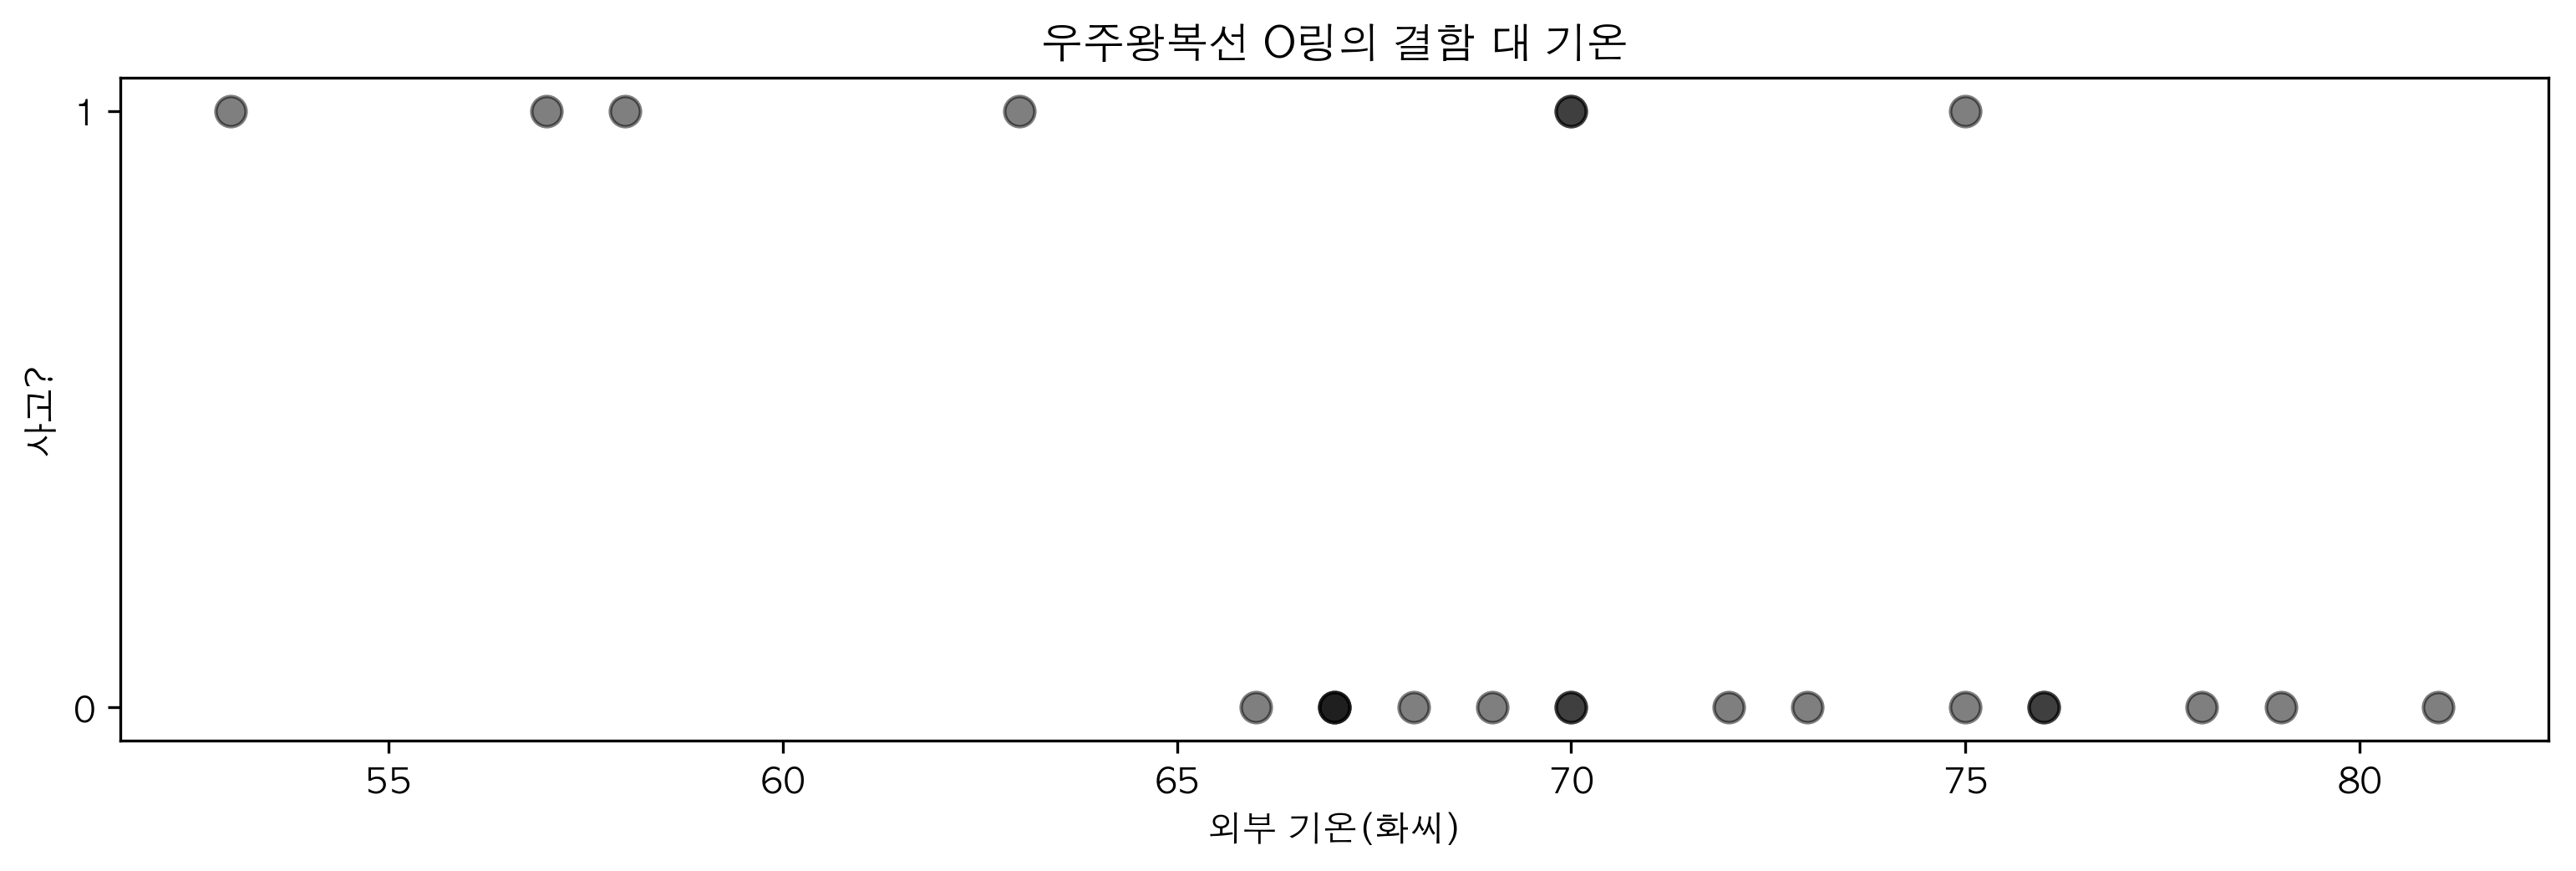

In [52]:
figsize(12.5, 3.5)

np.set_printoptions(precision=3, suppress=True)
challenger_data = np.genfromtxt('./data/challenger_data.csv', skip_header=1,
                                usecols=[1, 2], missing_values='NA', delimiter=',')
# NA값을 버린다.
challenger_data = challenger_data[~np.isnan(challenger_data[:, 1])]

# 기온 함수로 그린다(1열)
print('Temp (F), O-Ring failure?')
print(challenger_data)

plt.scatter(challenger_data[:, 0], challenger_data[:, 1], 
            s=75, color="k", alpha=0.5)
plt.yticks([0, 1])
plt.ylabel("사고?")
plt.xlabel("외부 기온(화씨)")
plt.title("우주왕복선 O링의 결함 대 기온")

외부 온도가 낮아질수록 사고가 발생할 **확률**이 증가한다. 기온과 발생한 사고 사이에 엄격한 구분이 보이지 않으므로 확률을 모델링하려고 한다. 

> "온도 t에서 손실 사고의 확률은 얼마인가?"

위의 질문에 답하기 위해서는 $p(t)$라는 온도 함수가 필요하다. 이 함수값의 범위는 $0$과 $1$사이고, 온도가 높아지면 1부터 0까지 변한다. 이러한 함수 중 **로지스틱함수**(logistic function)다.

$$
p(t) = \frac{1}{1+e^{\beta t}}
$$

위의 함수에서 $\beta$는 확신이 없는 변수다. $\beta = 1, 3, -5$에  대해 작성함 함수를 그림으로 나타내보자.

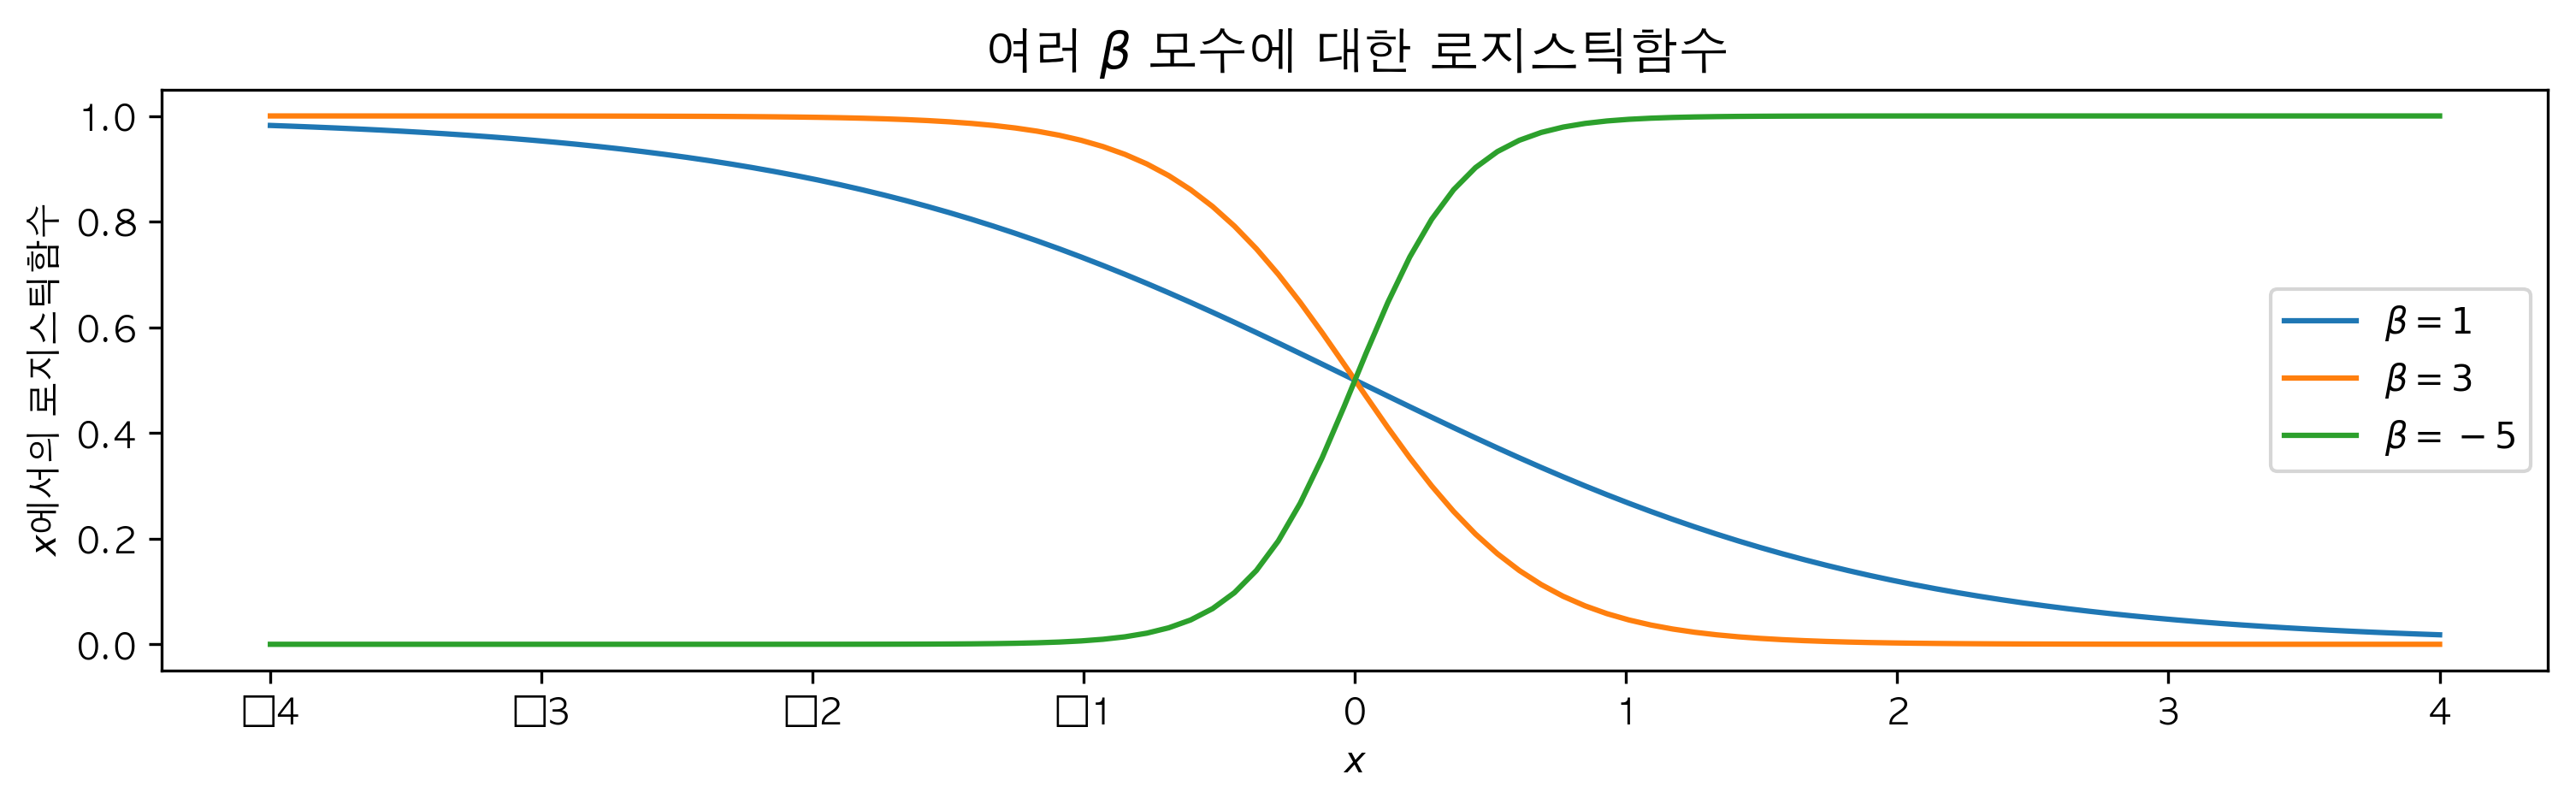

In [53]:
figsize(12, 3)

def logistic(x, beta):
    return 1.0 / (1.0 + np.exp(beta * x))

x = np.linspace(-4, 4, 100)
plt.plot(x, logistic(x, 1), label=r"$\beta = 1$")
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$")
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$")
plt.xlabel("$x$")
plt.ylabel("$x$에서의 로지스틱함수")
plt.title("여러 $\\beta$ 모수에 대한 로지스틱함수", fontsize=14)
plt.legend();

위의 로지스틱함수에서 확률은 $0$ 근처에서만 변하지만, 챌린저호 데이터에서 확률은 화씨 $65~70$도 근처에서 변한다. 따라서 로지스틱함수에 **편향**(bias)를 추가해야 한다.

$$
p(t) = \frac{1}{1+e^{\beta t + \alpha}}
$$

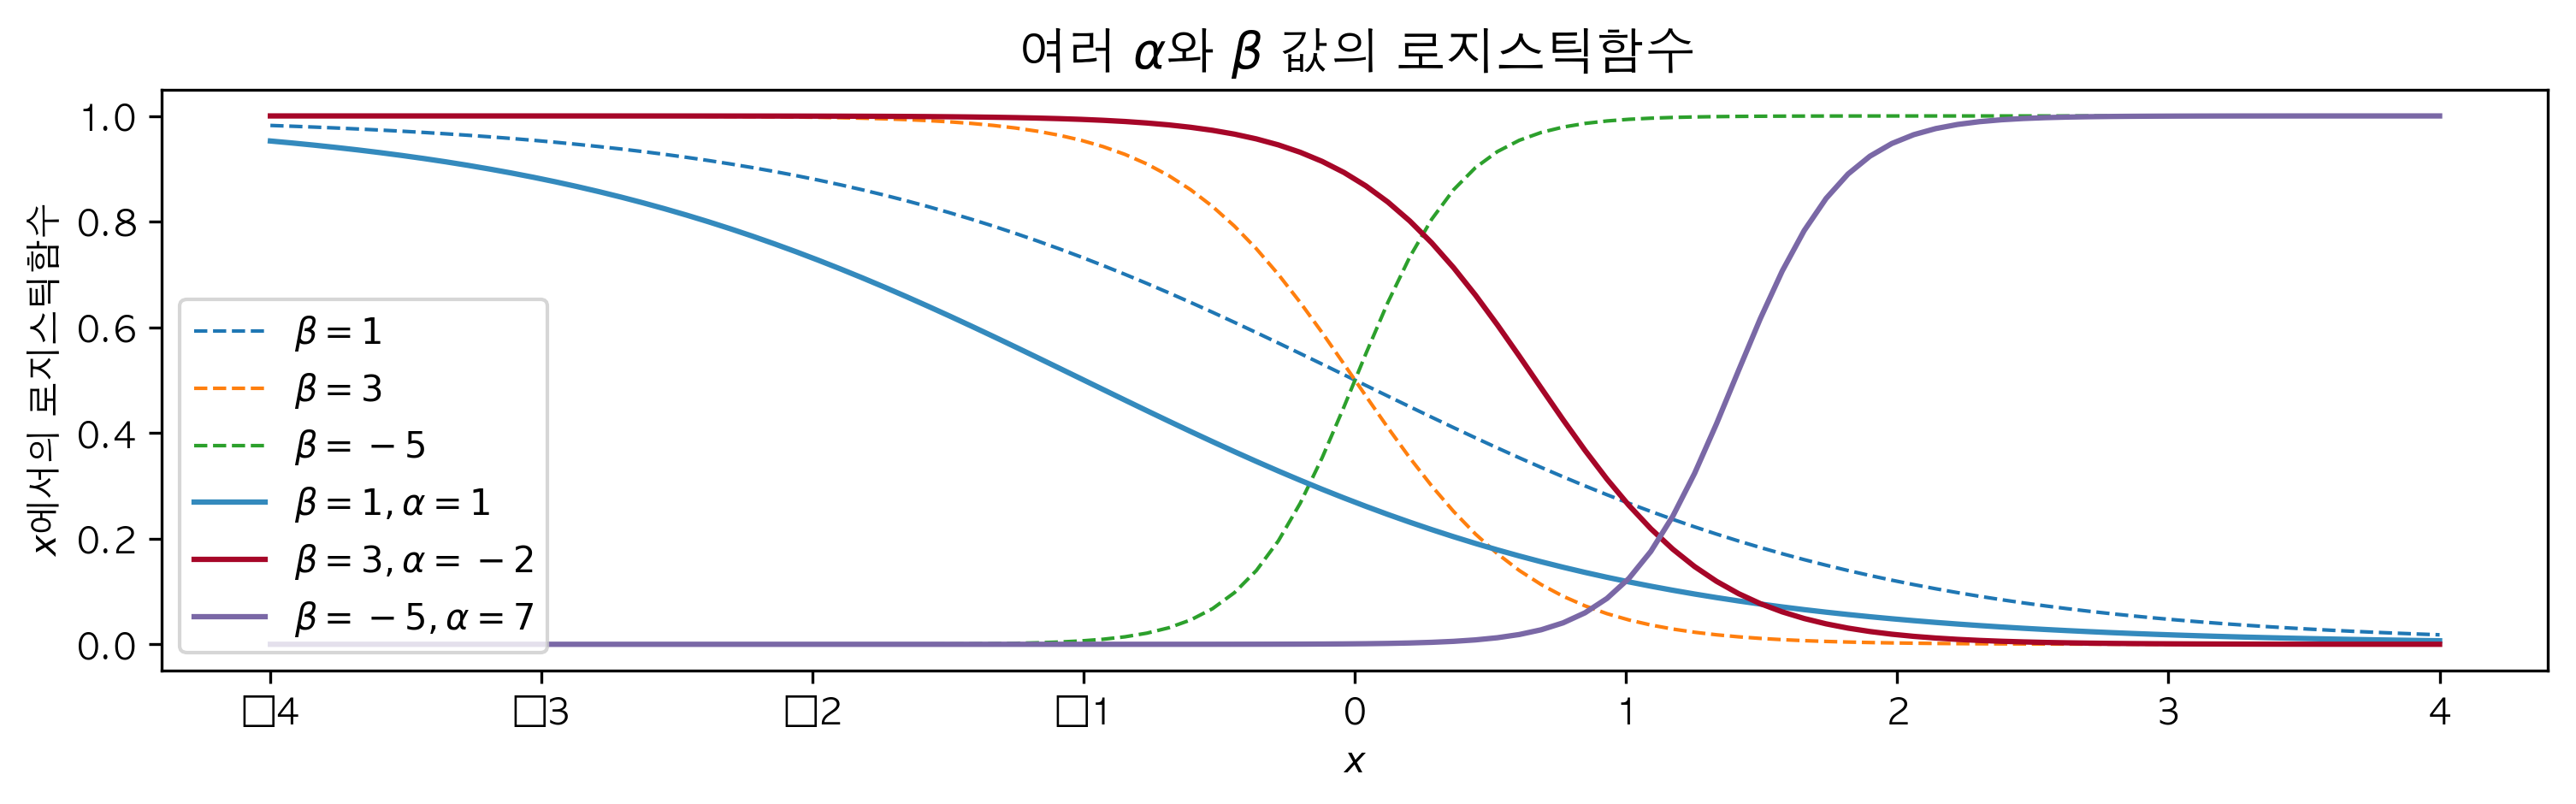

In [55]:
def logistic(x, beta, alpha=0):
    return 1.0 / (1.0 + np.exp(np.dot(beta, x) + alpha))

x = np.linspace(-4, 4, 100)

plt.plot(x, logistic(x, 1), label=r"$\beta = 1$", ls="--", lw=1)
plt.plot(x, logistic(x, 3), label=r"$\beta = 3$", ls="--", lw=1)
plt.plot(x, logistic(x, -5), label=r"$\beta = -5$", ls="--", lw=1)
plt.plot(x, logistic(x, 1, 1), label=r"$\beta = 1, \alpha = 1$", color="#348ABD")
plt.plot(x, logistic(x, 3, -2), label=r"$\beta = 3, \alpha = -2$", color="#A60628")
plt.plot(x, logistic(x, -5, 7), label=r"$\beta = -5, \alpha = 7$", color="#7A68A6")
plt.title("여러 $\\alpha$와 $\\beta$ 값의 로지스틱함수", fontsize=14)
plt.xlabel("$x$")
plt.ylabel("$x$에서의 로지스틱함수")
plt.legend(loc="lower left");

### 2.2.11 정규분포

정규확률변수는 $X \sim N(\mu, \frac{1}{\tau})$로 나타내며 두 개의 모수, 즉 평균을 나타내는 $\mu$와 **정밀도**를 나타내는 $\tau$를 가진다. 

확률변수 $N(\mu, \frac{1}{\tau})$의 확률밀도함수는 다음과 같다.

$$
f(x|\mu, \tau) = \sqrt{\frac{\tau}{2\pi}}\exp{\left( -\frac{\tau}{2\pi} (x-\mu)^{2} \right)} 
$$

Text(0.5,1,'정규확률변수 세 개에 대한 확률분포')

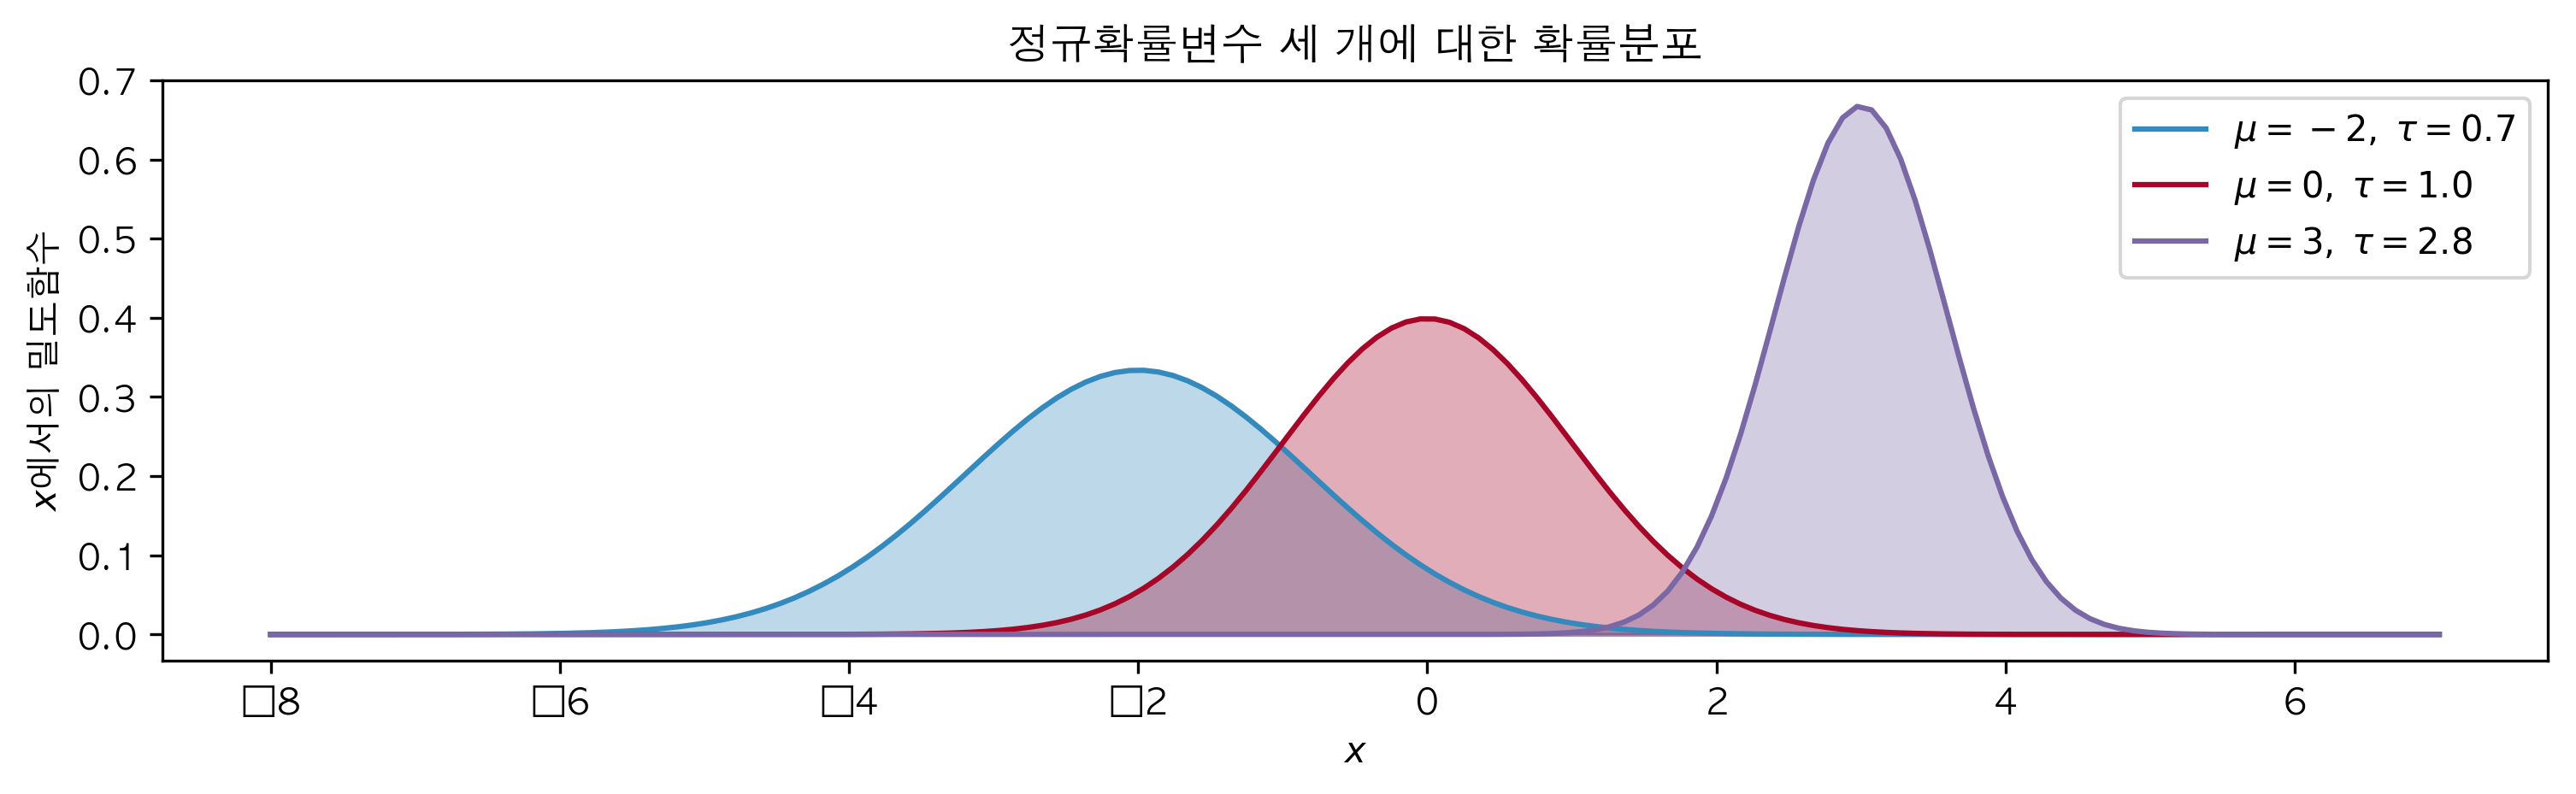

In [56]:
import scipy.stats as stats

nor = stats.norm
x = np.linspace(-8, 7, 150)
mu = (-2, 0, 3)
tau = (.7, 1, 2.8)
colors = ['#348ABD', '#A60628', '#7A68A6']
parameters = zip(mu, tau, colors)

for _mu, _tau, _color in parameters:
    plt.plot(x, nor.pdf(x, _mu, scale=1. / np.sqrt(_tau)),
             label="$\mu = %d,\;\\tau = %.1f$" % (_mu, _tau), color=_color)
    plt.fill_between(x, nor.pdf(x, _mu, scale=1. / np.sqrt(_tau)), color=_color, alpha=.33)
    
plt.legend(loc="upper right")
plt.xlabel("$x$")
plt.ylabel("$x$에서의 밀도함수")
plt.title("정규확률변수 세 개에 대한 확률분포")

정규확률변수는 임의의 실수를 가질 수 있지만, 변수는 상대적으로 $\mu$에 가까울 가능성이 매우 크다. 정규분포의 기대값은 그것의 모수 $\mu$와 같다. 분산은 $\tau$의 역수와 같다.

$$
E\left[ { X }|{ \mu }, \tau \right] = \mu
$$

$$
Var\left( { X }|{ \mu }, \tau \right) = \frac{1}{\tau}
$$

In [57]:
# import pymc as pm

temperature = challenger_data[:, 0]
D = challenger_data[:, 1]  # 검출되었는가, 아닌가?

# 'value' 주목!
beta = pm.Normal('beta', 0, 0.001, value=0)
alpha = pm.Normal('alpha', 0, 0.001, value=0)

@pm.deterministic
def p(t=temperature, alpha=alpha, beta=beta):
    return 1.0 / (1 + np.exp(beta * t + alpha))

우리는 $p$라는 확률을 가지고 있지만(로지스틱 함수), 이 확률을 어떻게 관찰된 데이터에 연결할 수 있을까? 이때 앞에서 살펴본 베르누이 확률변수를 사용할 수 있다.

$$
\text{Defect Incident}, D_i \sim \text{Ber}\left( p(t_i) \right), \quad i=1, \dots , N
$$

$p(t)$는 로지스틱함수이고, $t_i$는 관측한 온도다. 위의 코드에서 `beta=0, alpha=0`으로 설정한 이유는 사전확률 p(t)에 평등한(?) 확률 값을 설정하기 위함이다.

In [58]:
p.value

array([ 0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,  0.5,
        0.5])

In [59]:
# 베르누이 확률변수를 통해 확률과 관측치를 연결한다.
observed = pm.Bernoulli('bernoulli_obs', p, value=D, observed=True)

model = pm.Model([observed, beta, alpha])

map_ = pm.MAP(model)
map_.fit()
mcmc = pm.MCMC(model)
mcmc.sample(120000, 100000, 2)

/Users/cjh/miniconda3/envs/study/lib/python3.6/site-packages/scipy/optimize/optimize.py:1933: RuntimeWarning: invalid value encountered in absolute
  tmp2 = numpy.abs(tmp2)


 [-----------------100%-----------------] 120000 of 120000 complete in 7.3 sec

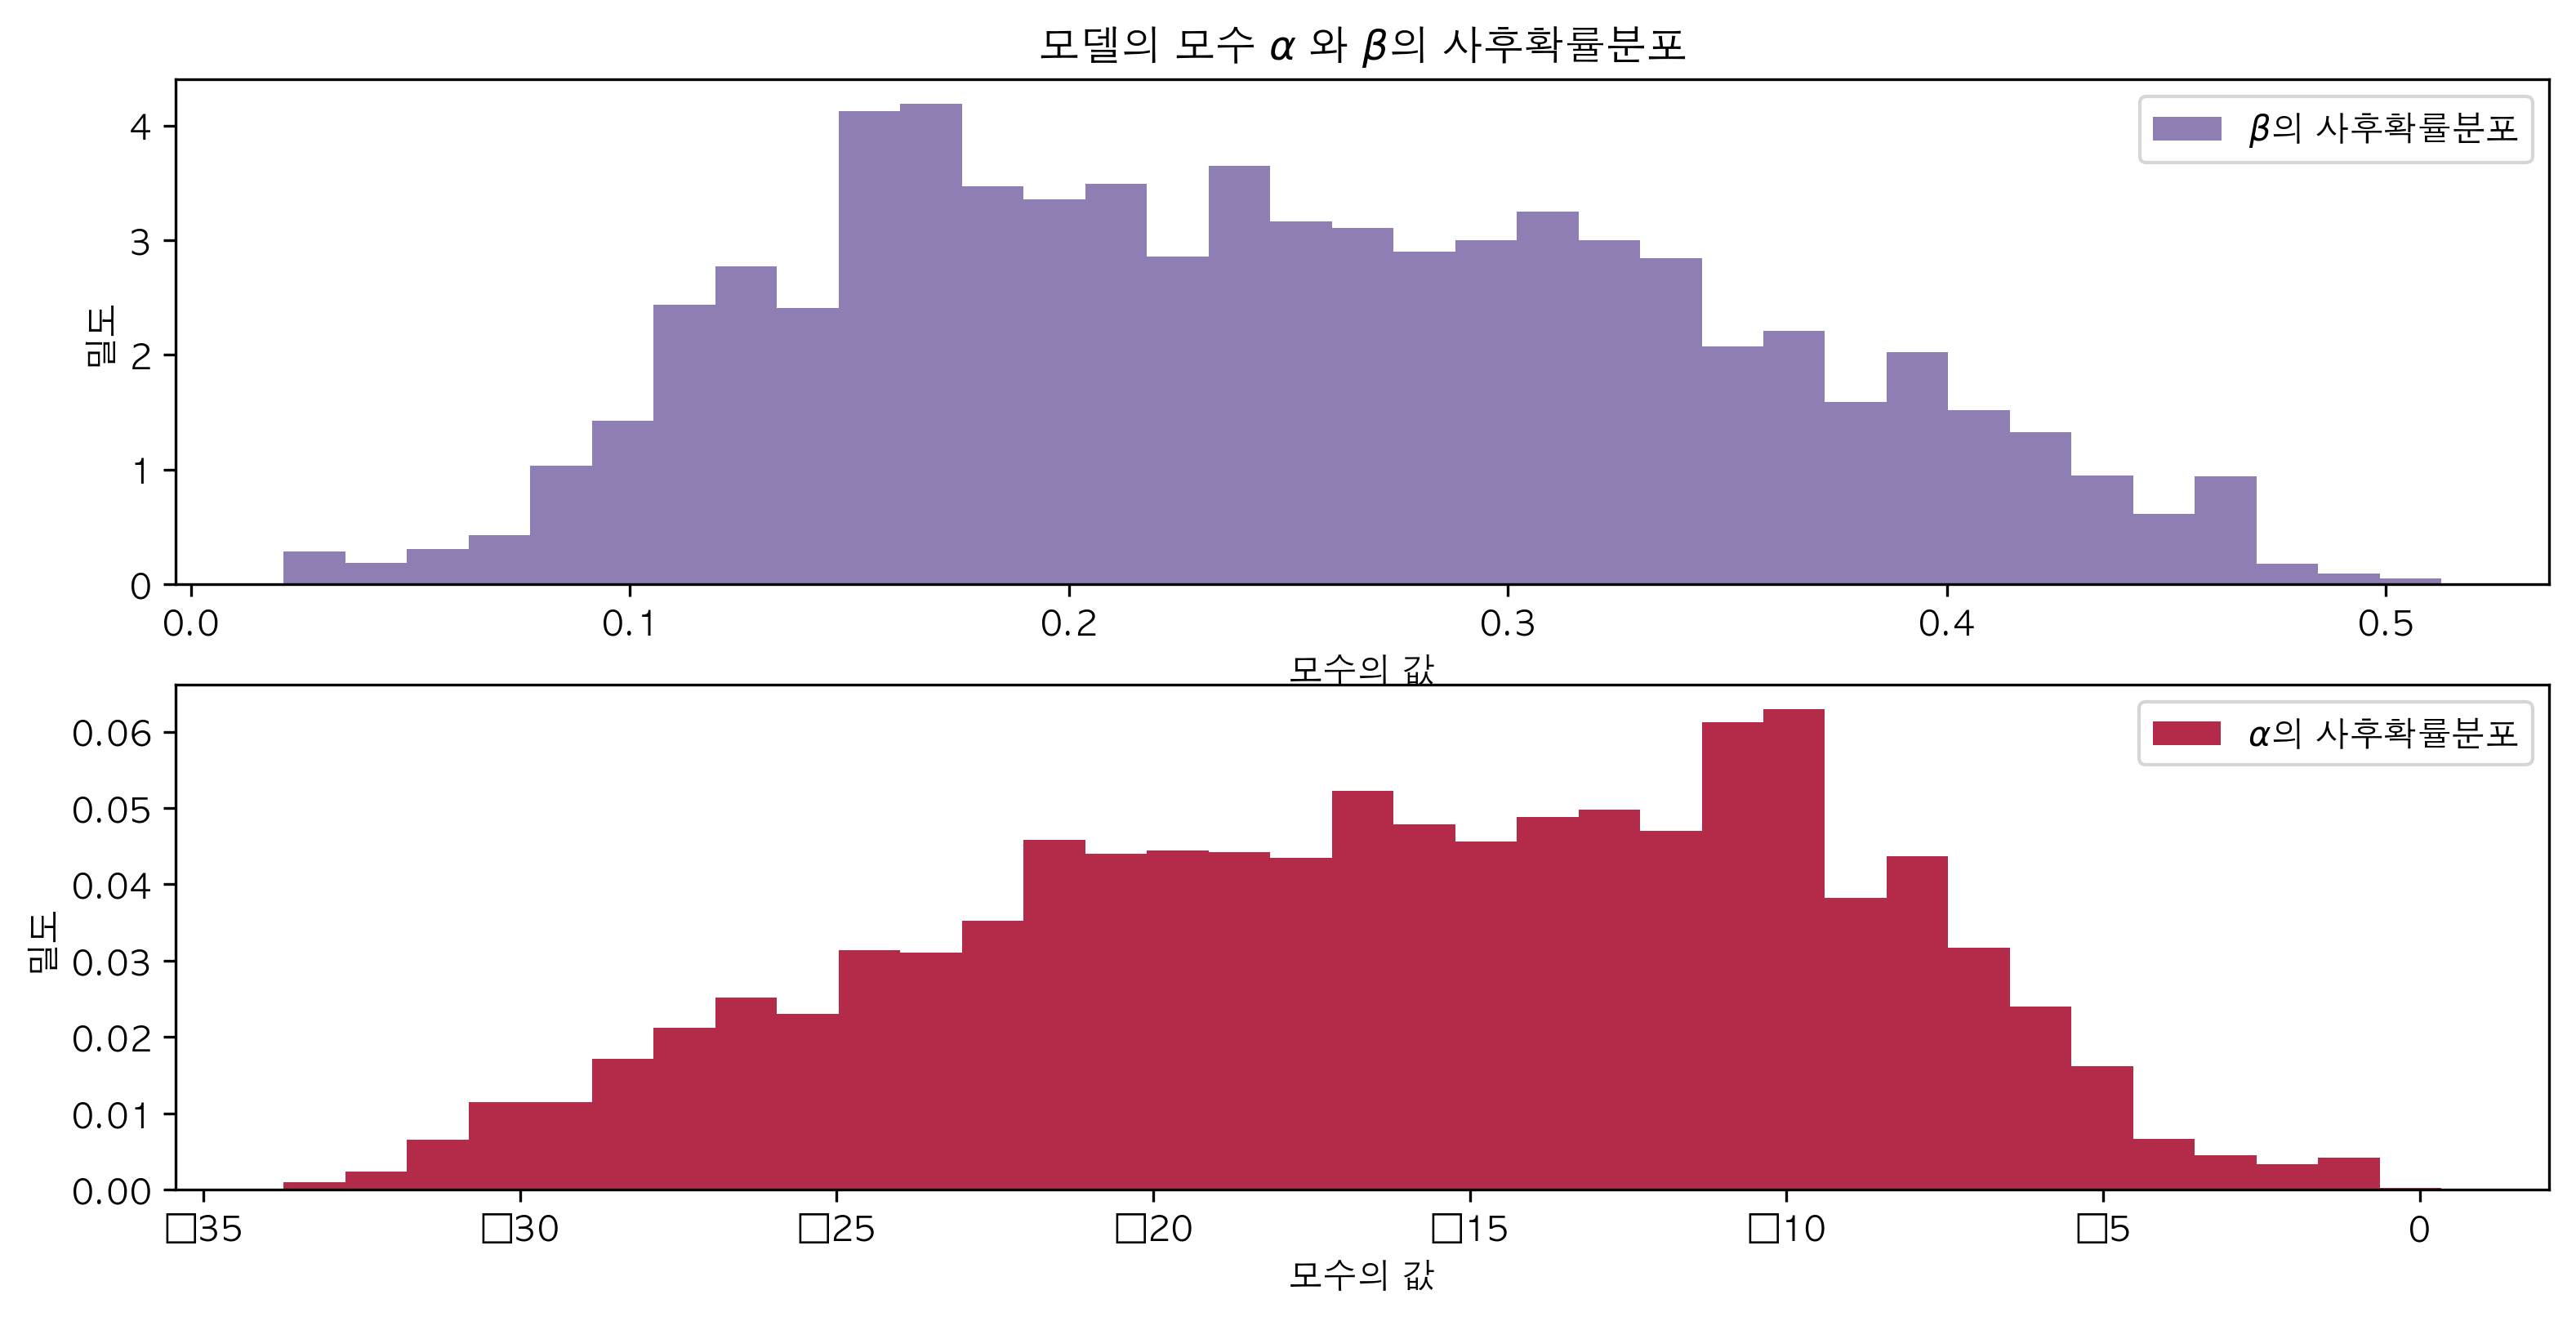

In [60]:
alpha_samples = mcmc.trace('alpha')[:, None]  # 1차원으로 만듦
beta_samples = mcmc.trace('beta')[:, None]

figsize(12.5, 6)

# 표본의 히스토그램
plt.subplot(211)
plt.title(r"모델의 모수 $\alpha$ 와 $\beta$의 사후확률분포")
plt.hist(beta_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"$\beta$의 사후확률분포", color="#7A68A6", density=True)
plt.xlabel("모수의 값")
plt.ylabel("밀도")
plt.legend()

plt.subplot(212)
plt.hist(alpha_samples, histtype='stepfilled', bins=35, alpha=0.85,
         label=r"$\alpha$의 사후확률분포", color="#A60628", density=True)
plt.xlabel("모수의 값")
plt.ylabel("밀도")
plt.legend();

$\beta$의 모든 표본값은 $0$보다 크다. 사후확률이 $0$주변에 집중되었다면 $\beta = 0$을 의심할 것이며, 이것은 온도가 결함의 확률에 아무런 영향을 주지 않는다는 것을 의미한다.

다음으로 온도의 특별한 값에 대한 **기대확률**(expected probability)을 구해보자. 사후확률분포에서 구한 모든 표본에 대해 평균을 내어 $p(t_i)$의 추정값을 구한다.

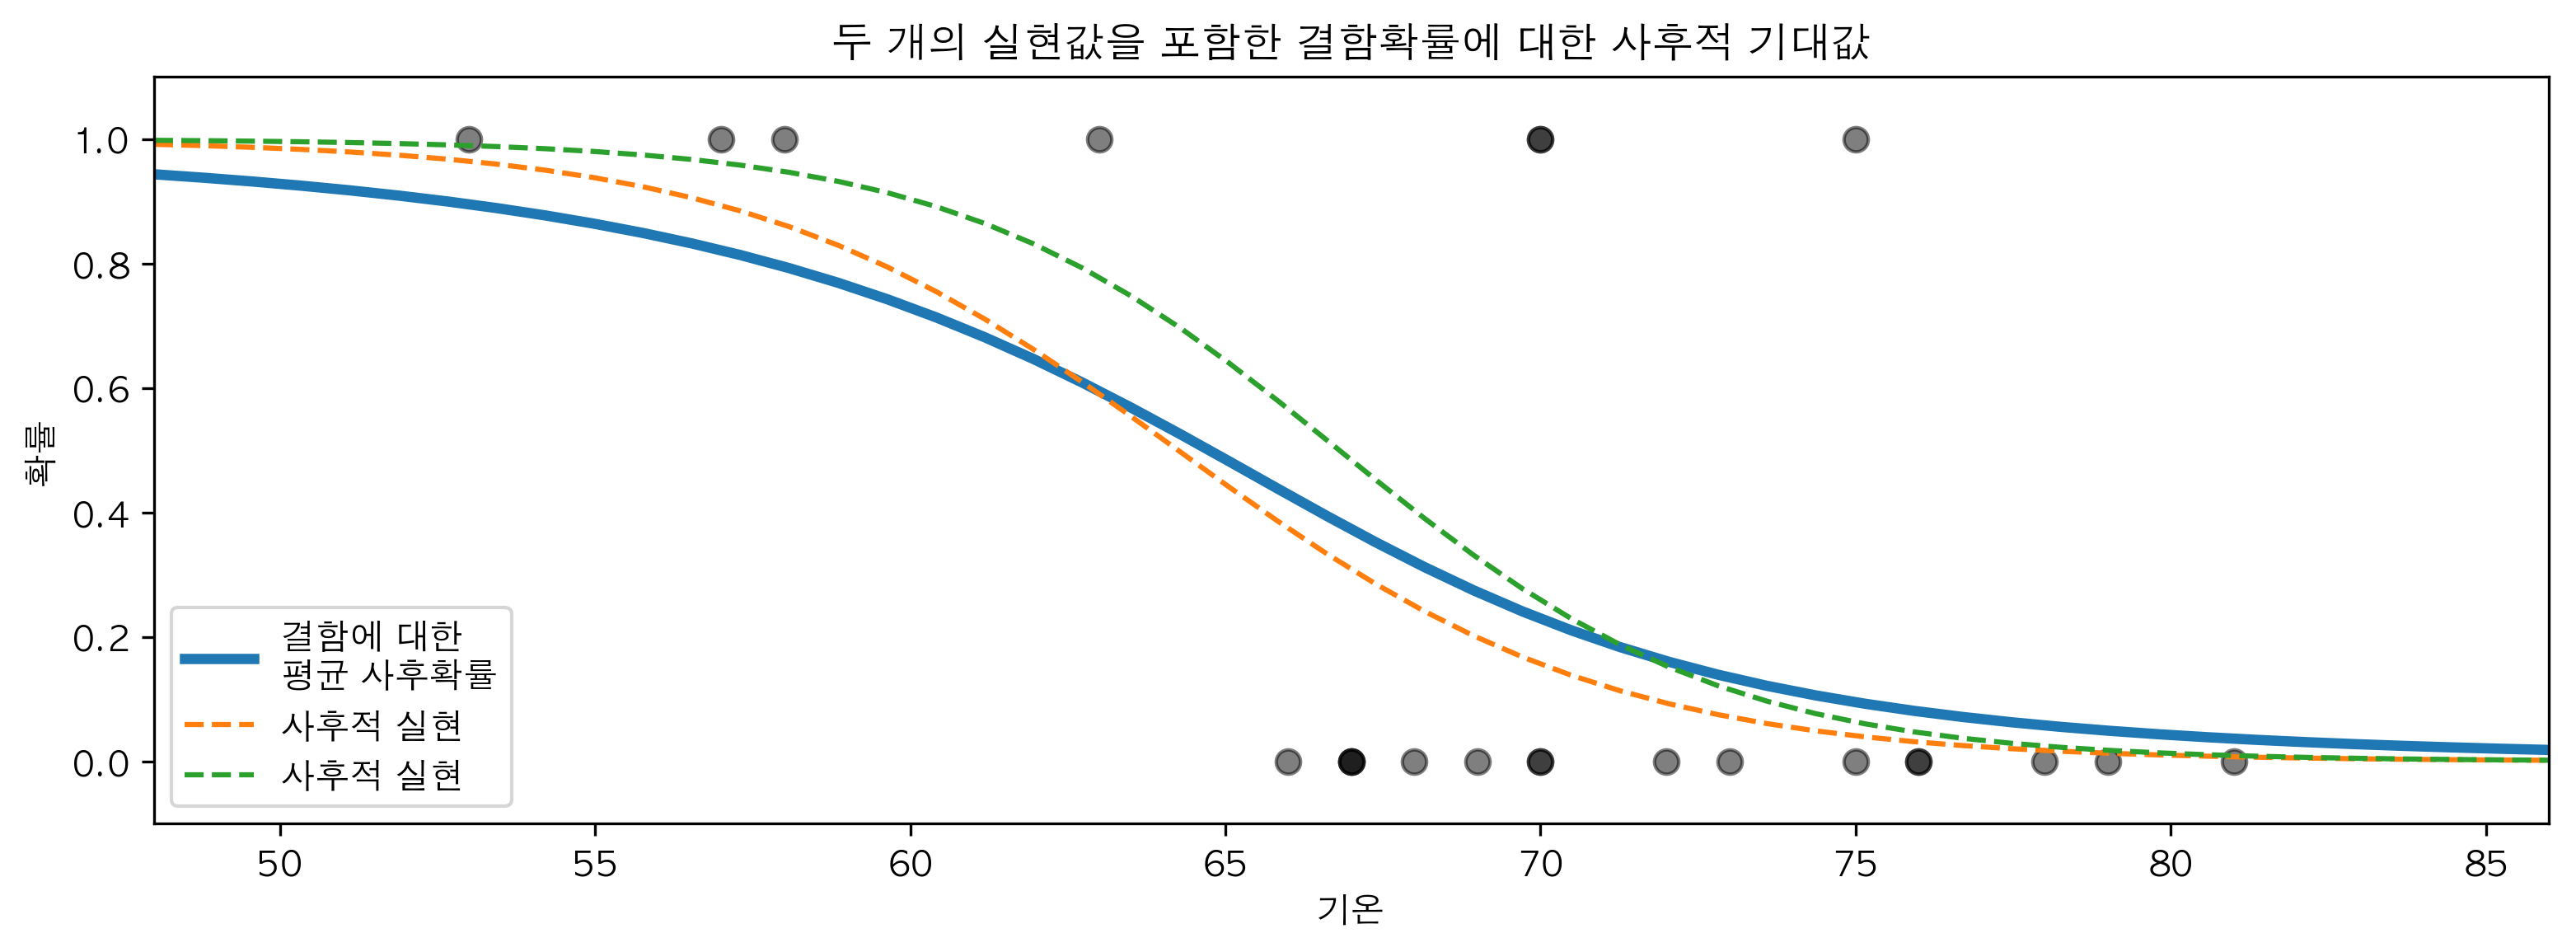

In [61]:
t = np.linspace(temperature.min()-5, temperature.max()+5, 50)[:, None]
p_t = logistic(t.T, beta_samples, alpha_samples)
mean_prob_t = p_t.mean(axis=0)

figsize(12.5, 4)

plt.plot(t, mean_prob_t, lw=3, label="결함에 대한 \n평균 사후확률")
plt.plot(t, p_t[0, :], ls="--", label="사후적 실현")
plt.plot(t, p_t[-2, :], ls="--", label="사후적 실현")  # = p_t[9998, :]
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.title("두 개의 실현값을 포함한 결함확률에 대한 사후적 기대값")
plt.legend(loc="lower left")
plt.ylim(-0.1, 1.1)
plt.xlim(t.min(), t.max())
plt.ylabel("확률")
plt.xlabel("기온");

다음으로는 
> 결함확률에 대해 어떤 온도에서 가장 확신이 없는가?

에대해 각온도에 대한 기대값과 그에 연관된 95% 신뢰구간(credible intervals, CI)을 그려보자.

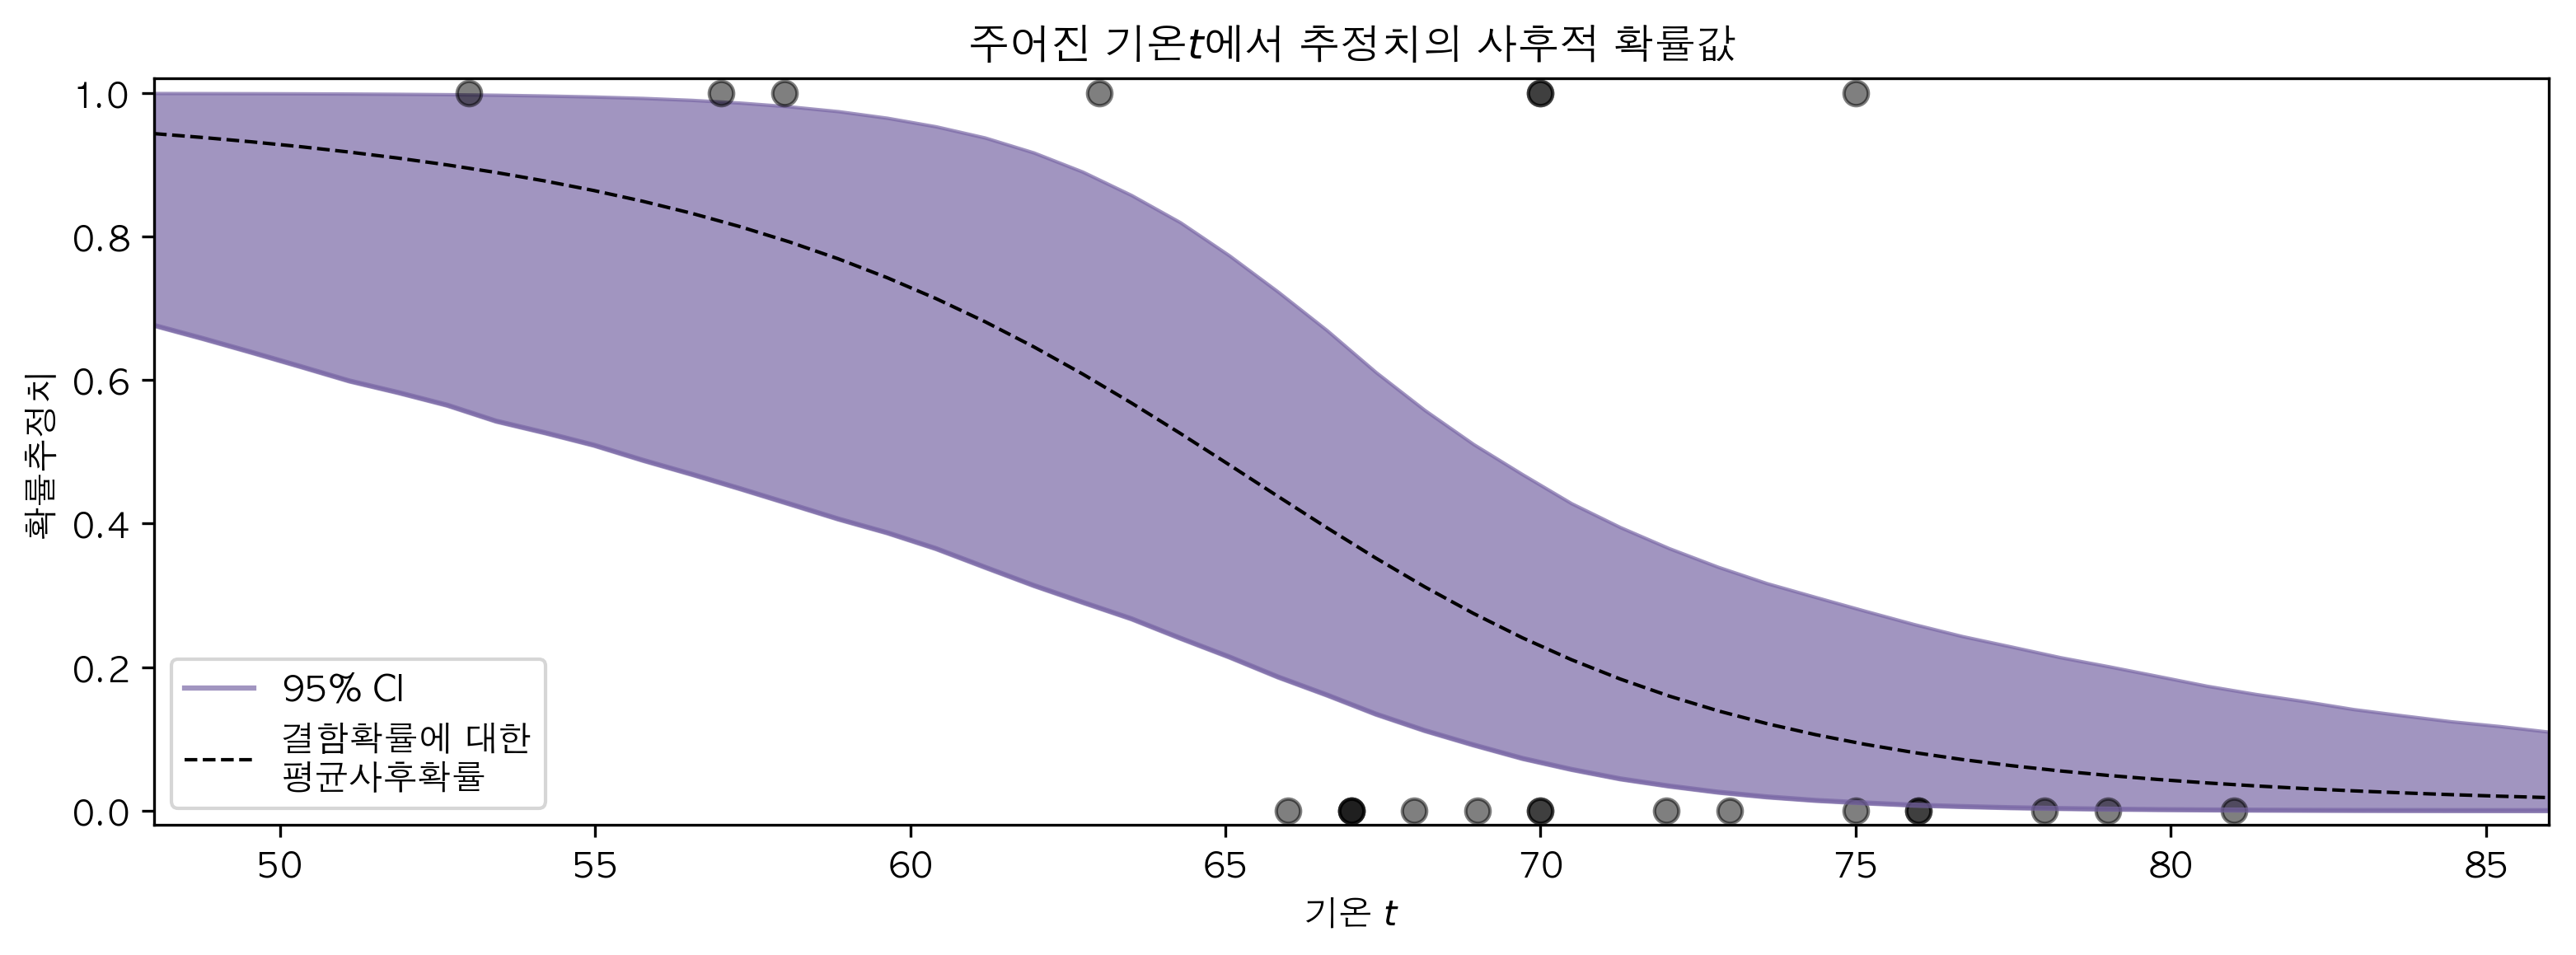

In [62]:
from scipy.stats.mstats import mquantiles

# 신뢰구간을 위해 맨 아래부터 상위 2.5% 퀀타일(quantile)을 벡터화한다.
qs = mquantiles(p_t, [0.025, 0.975], axis=0)

plt.fill_between(t[:, 0], *qs, alpha=0.7,color="#7A68A6")

plt.plot(t[:, 0], qs[0], label="95% CI", color="#7A68A6", alpha=0.7)

plt.plot(t, mean_prob_t, lw=1, ls="--", color="k",
         label="결함확률에 대한\n평균사후확률")

plt.xlim(t.min(), t.max())
plt.ylim(-0.02, 1.02)
plt.legend(loc="lower left")
plt.scatter(temperature, D, color="k", s=50, alpha=0.5)
plt.xlabel("기온 $t$")

plt.ylabel("확률추정치")
plt.title("주어진 기온$t$에서 추정치의 사후적 확률값");

보라색으로 칠해진 95% **신뢰구간**을 나타낸다. 예를 들어 65도에서 0.25 ~ 0.75 사이에 결함확률이 있다고 95% 확신할 수 있다. 

60도에 가까워질수록 CI가 넓어진다. 이것은 60~65도 주변에서 더 많은 O링을 테스트하여 그 범위 내에서 더 나은 확률을 추정해야 한다.

### 2.2.12 챌린저호 참사 당일에는 무슨 일이 일어났는가?

캘린저호 참사 당일 외부 온도는 화씨 31도 였다. 31도에서의 결함이 발생할 사후확률분포를 살펴보자.

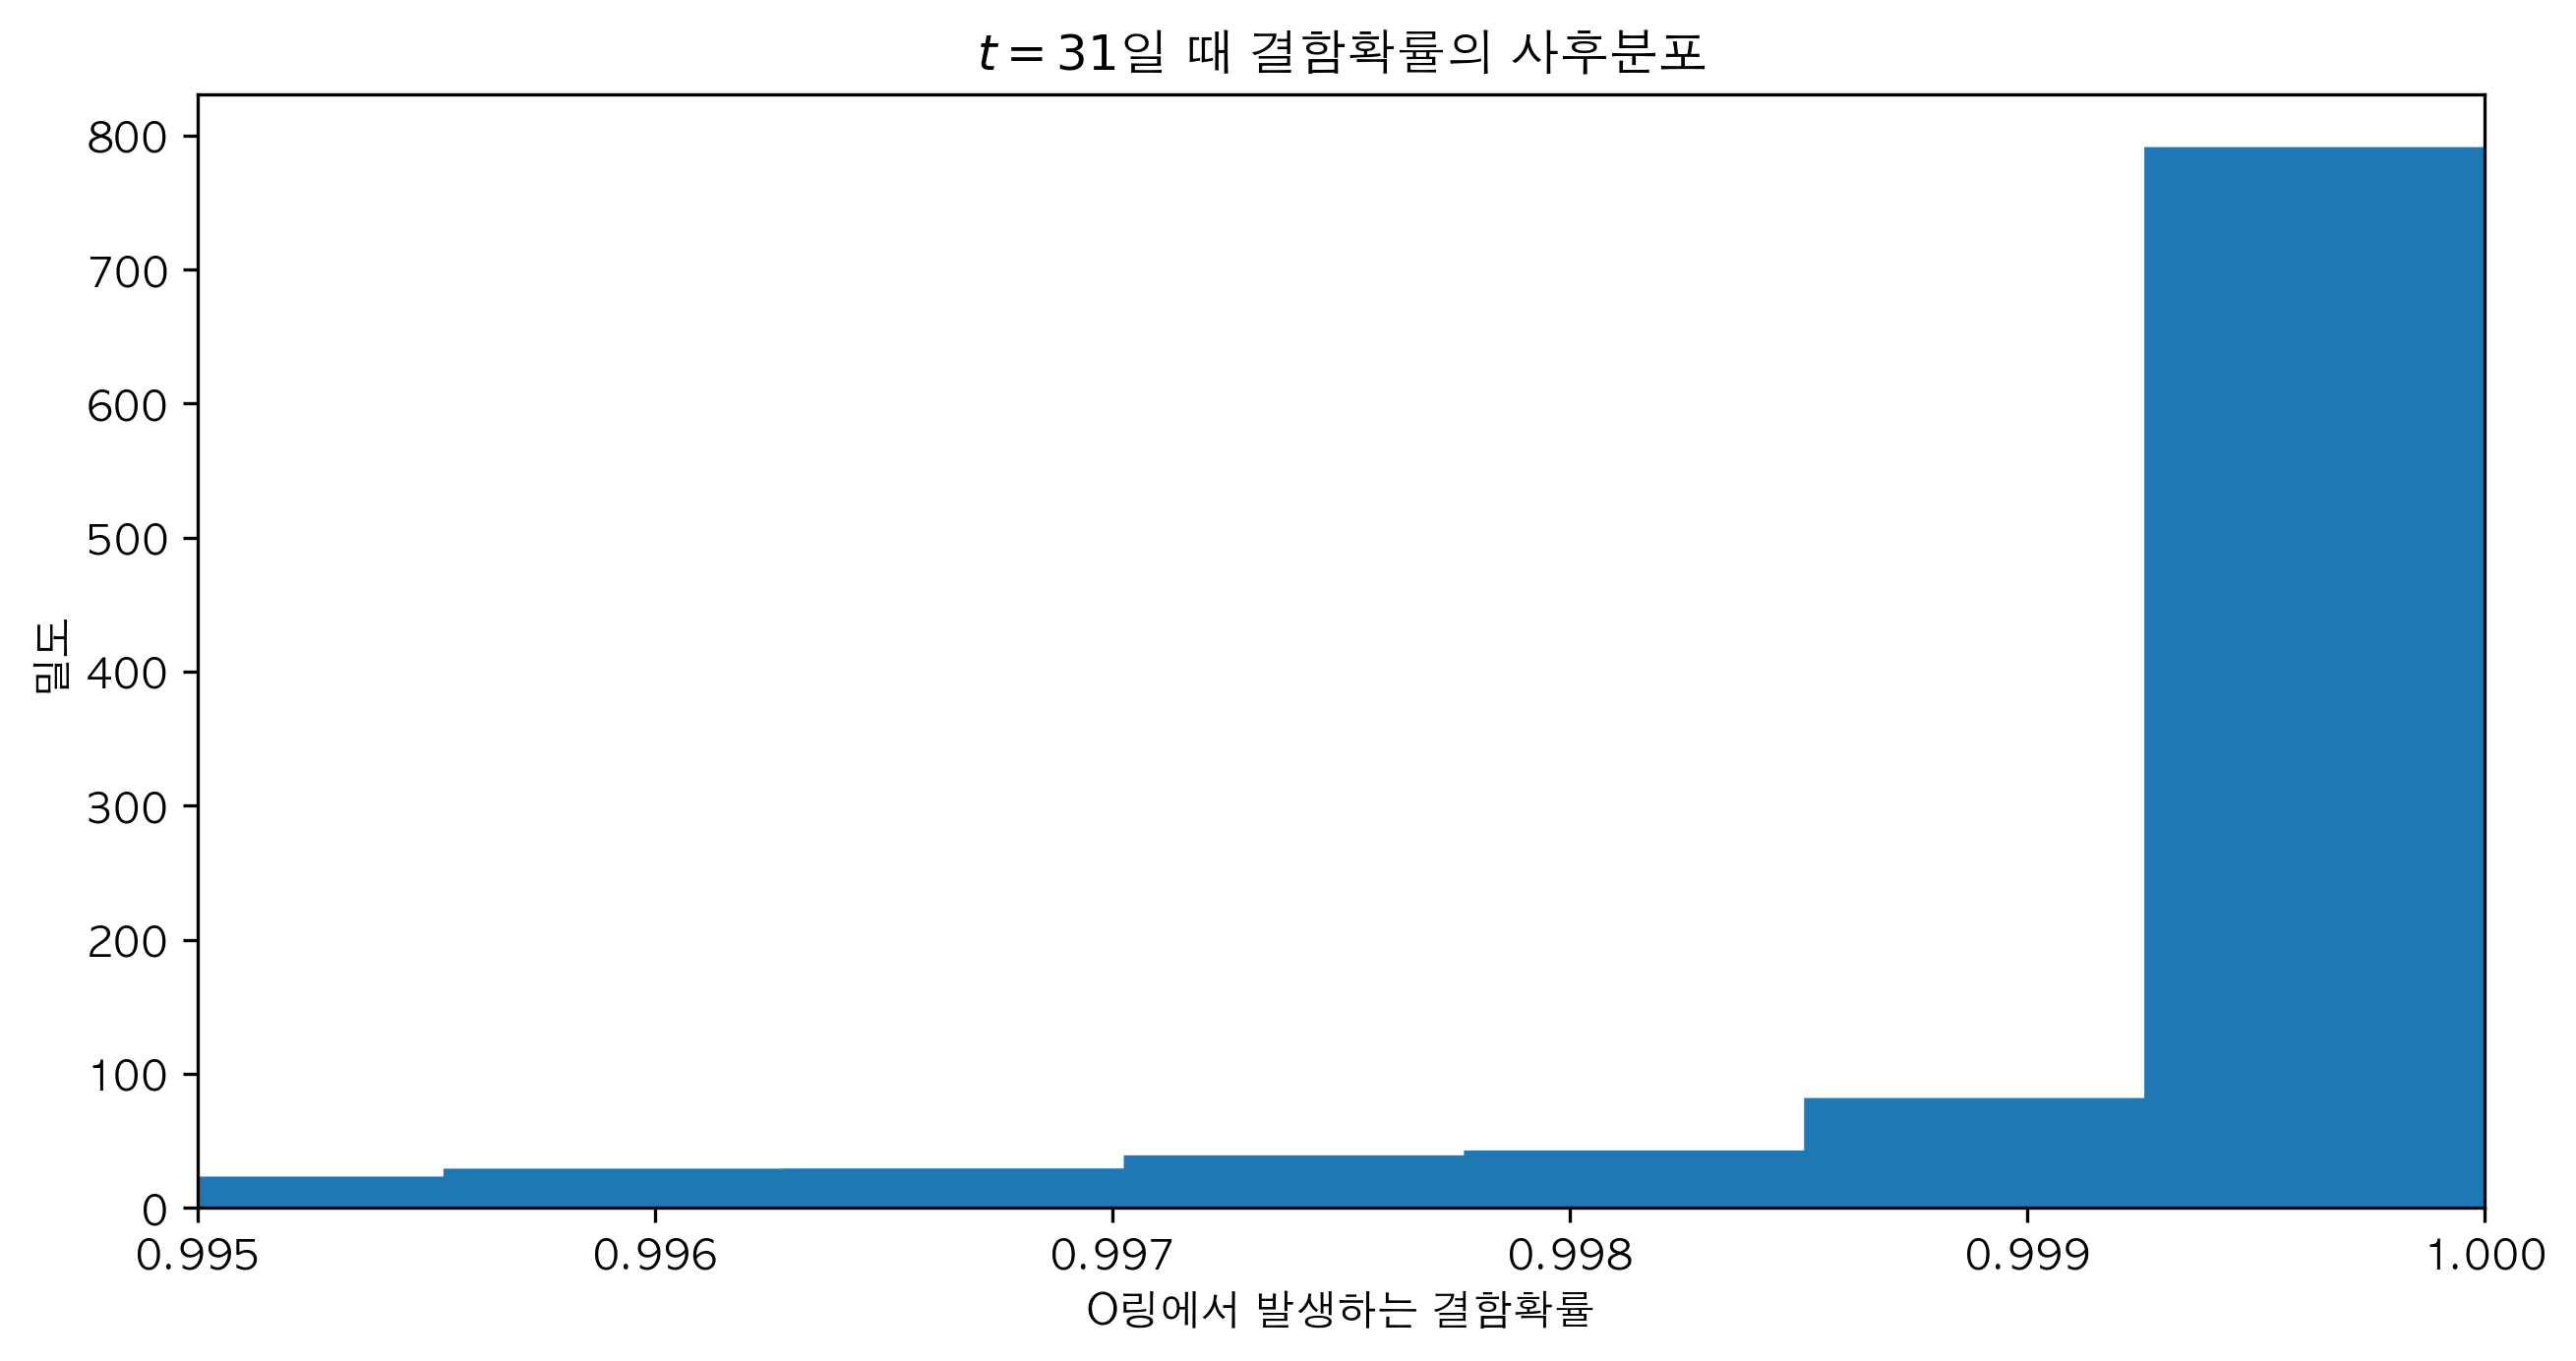

In [63]:
figsize(10, 5)

prob_31 = logistic(31, beta_samples, alpha_samples)

plt.xlim(0.995, 1)
plt.hist(prob_31, bins=1000, density=True, histtype='stepfilled')
plt.title("$t = 31$일 때 결함확률의 사후분포")
plt.ylabel("밀도")
plt.xlabel("O링에서 발생하는 결함확률");

## 2.3 우리의 모델이 적절한가?

위에서 살펴본 모델링에서 $p(t)$에 대해 로지스틱함수를 선택했고, 특정 사전확률을 선택했다. 만약 다른 함수 및 다른 사전확률을 선택한다면 다른 결과가 나올 것이다. 여기서 어떻게 우리가 선택한 모델이 괜찮은 모델인지 알 수 있을까?

#### 우리의 모델이 부적절한지 아닌지 어떻게 테스트할 수 있는가?

한 가지 방법은 관측 데이터(즉, **고정된** 확률변수)와 우리가 시뮬레이션하는 인위적인 데이터셋을 비교하는 것이다. 이렇게 비교하는 근거는 시뮬레이션된 데이터셋이 관측된 데이터셋과 통계적으로 유사해 보이지 않는다면 우리의 모델은 관측된 데이터를 정확하게 나타내지 못할 수 있기 때문이다.

2.2.1 에서 살펴본 문자 메시지에 대해 가상 데이터셋을 시뮬레이션 했다. 이 때 사전확률에서 값들을 표본추출했다(즉, 데이터에 맞지 않는 모델에서 표본추출하였다). 그 결과 데이터셋은 관측된 데이터셋과 거의 유사하지 않았다.

챌린저호 예제에서는 그럴듯한 데이터셋을 만들기 위해 사후확률분포에서 표본을 추출해야 한다. 

In [64]:
# simulated_data = pm.Bernoulli('simulation_data', p)  # ?? 왜 있는거지?

simulated = pm.Bernoulli('bernoulli_sim', p)
N = 10000

mcmc = pm.MCMC([simulated, alpha, beta, observed])
mcmc.sample(N)

 [-----------------100%-----------------] 10000 of 10000 complete in 1.3 sec

시뮬레이션 배열의 형태: (10000, 23)


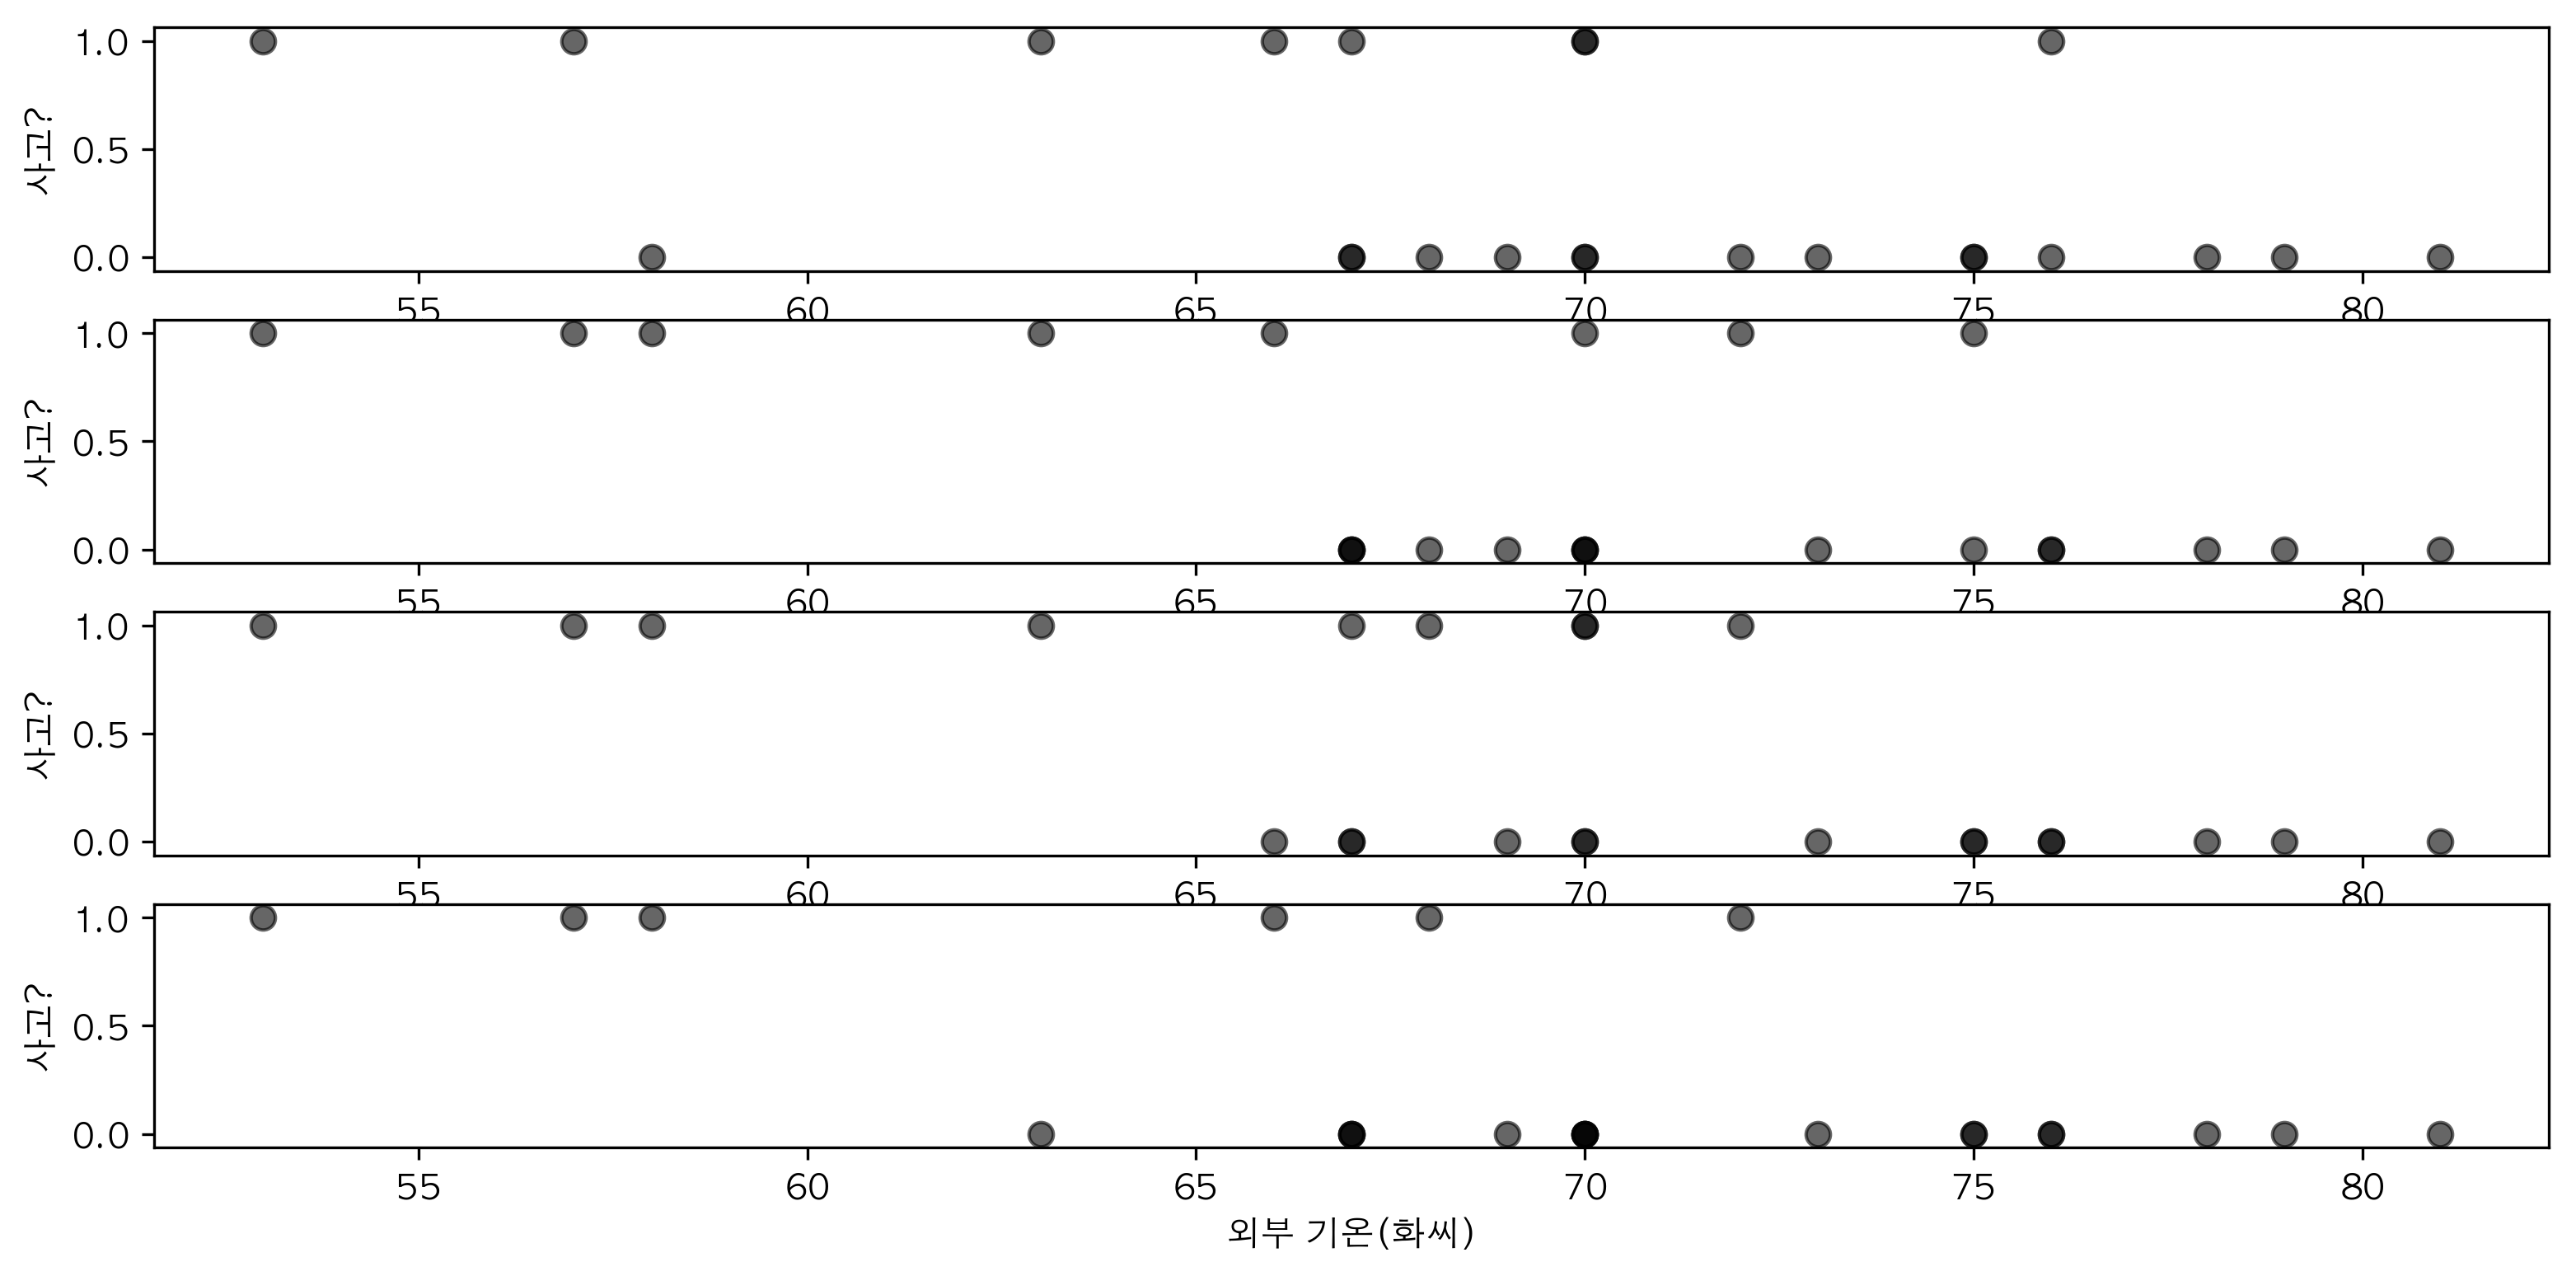

In [65]:
figsize(12.5, 5)

simulations = mcmc.trace("bernoulli_sim")[:].astype(int)
print("시뮬레이션 배열의 형태:", simulations.shape)
# plt.title("사후확률분포의 모수를 사용한 시뮬레이션 데이터셋")

figsize(12.5, 6)
for i in range(4):
    ax = plt.subplot(4, 1, i + 1)
   
    plt.scatter(temperature, simulations[1000 * i, :], 
                color="k", s=50, alpha=0.6)
    plt.ylabel("사고?")

    plt.xlabel("외부 기온(화씨)")

### 2.3.1 분리도표

위의 가상의 데이터셋을 이용하여 분리도표를 그려보자.

**분리도표**(separation plots)는 사용자가 비교하고 싶은 서로 다른 모델을 그래프로 비교한다.

각 모델에 대해 사후확률 시뮬레이션이 특정 온도일 때 값이 1인 횟수의 비율을 계산해보자. 즉, 반환된 모든 시뮬레이션의 평균, $P \text{(Defect=1 | t)}$를 계산한다. 이것을 통해 가상 데이터셋의 각 데이터에서 결함의 사후확률을 얻을 수 있다.

In [78]:
posterior_probability = simulations.mean(axis=0)

print("관측  | 시뮬레이션된 결함배열                 | 결함의 사후확률                     | 실제결함 ")
for i in range(len(D)):
    print ("%s   | %s| %.2f                            | %d" 
           % (str(i).zfill(2),str(simulations[:10,i])[:-1] + "...]".ljust(12),posterior_probability[i], D[i]))

관측  | 시뮬레이션된 결함배열                 | 결함의 사후확률                     | 실제결함 
00   | [1 1 0 0 1 1 0 0 0 0...]        | 0.46                            | 0
01   | [1 1 0 0 0 0 1 0 0 0...]        | 0.21                            | 1
02   | [0 1 0 0 0 1 0 0 0 1...]        | 0.27                            | 0
03   | [0 0 0 0 0 1 0 1 0 0...]        | 0.32                            | 0
04   | [1 0 0 0 0 1 1 1 0 1...]        | 0.39                            | 0
05   | [0 0 0 0 0 0 0 0 0 0...]        | 0.13                            | 0
06   | [0 0 0 1 0 1 0 0 0 0...]        | 0.11                            | 0
07   | [0 0 0 0 0 0 0 0 0 0...]        | 0.21                            | 0
08   | [1 1 1 1 1 0 1 1 1 1...]        | 0.89                            | 1
09   | [1 0 0 0 0 1 0 1 1 1...]        | 0.65                            | 1
10   | [1 0 0 0 0 0 0 0 0 1...]        | 0.22                            | 1
11   | [0 0 0 0 0 0 0 0 0 0...]        | 0.04                            | 0
12 

In [80]:
x = np.argsort(posterior_probability)
print("Posterior Probability of Defect | Realized Defect")
for i in range(len(D)):
    print("%.2f                            | %d" % (posterior_probability[ix[i]], D[ix[i]]))

Posterior Probability of Defect | Realized Defect
0.02                            | 0
0.02                            | 0
0.04                            | 0
0.05                            | 0
0.06                            | 0
0.07                            | 0
0.07                            | 1
0.11                            | 0
0.13                            | 0
0.21                            | 0
0.21                            | 1
0.22                            | 0
0.22                            | 1
0.27                            | 0
0.32                            | 0
0.39                            | 0
0.39                            | 0
0.39                            | 0
0.46                            | 0
0.65                            | 1
0.86                            | 1
0.89                            | 1
0.95                            | 1


Text(258.167,0.5,'예측')

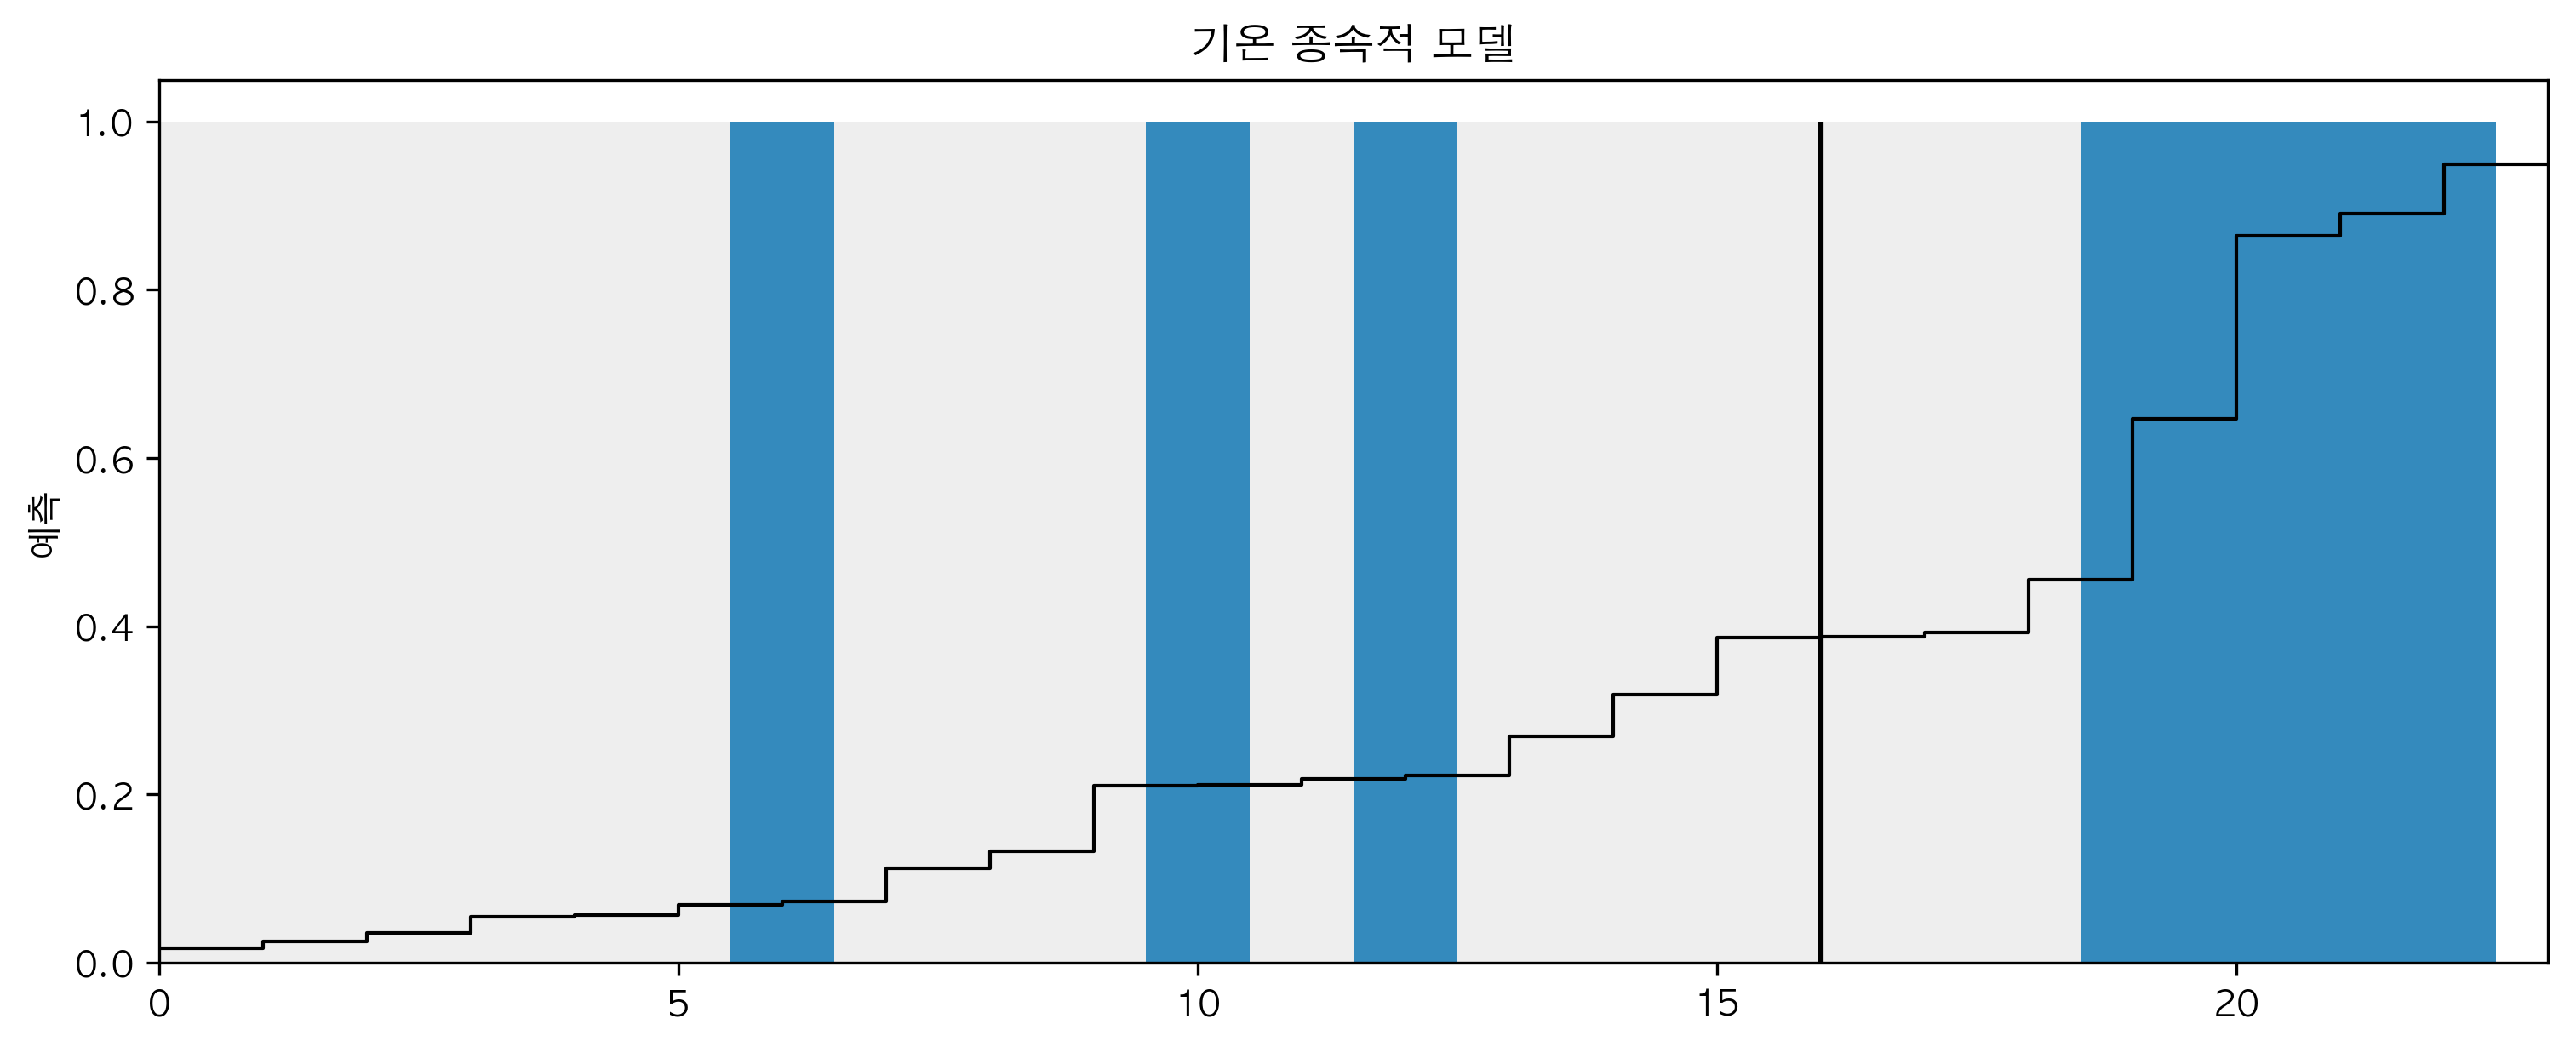

In [84]:
from separation_plot import separation_plot

figsize(10, 4)
separation_plot(posterior_probability, D)
plt.title('기온 종속적 모델')
plt.ylabel('예측')

위의 그래프에서 계단형태의 그래프는 정렬된 확률이다. 파란색 막대는 결함(1)을 나타내고, 빈공간은 무결함(0)을 나타낸다. 확률이 높아질수록 더욱 많은 결함이 발생하는 것을 알 수 있다. 위의 그림은 사후확률이 클수록 더 많은 결함이 발생한다는 것을 의미한다. 

위의 분리도표를 아래의 다른 모델의 분리도표와 비교해보자.

- **퍼펙트 모델** : 결함이 발생하면 사후확률을 1, 없다면 사후확률을 0으로 설정한다.
- **완전한 랜덤 모델** : 온도와 상관없이 랜덤확률을 예측하는 모델
- **상수 모델**: $P \text{(D=1|t)}=c, \forall t$ 인모델. $c$에 대한 최선의 선택은 관측빈도이다. 챌린저호 데이터의 겨우는 $\frac{7}{23}$ 이다.

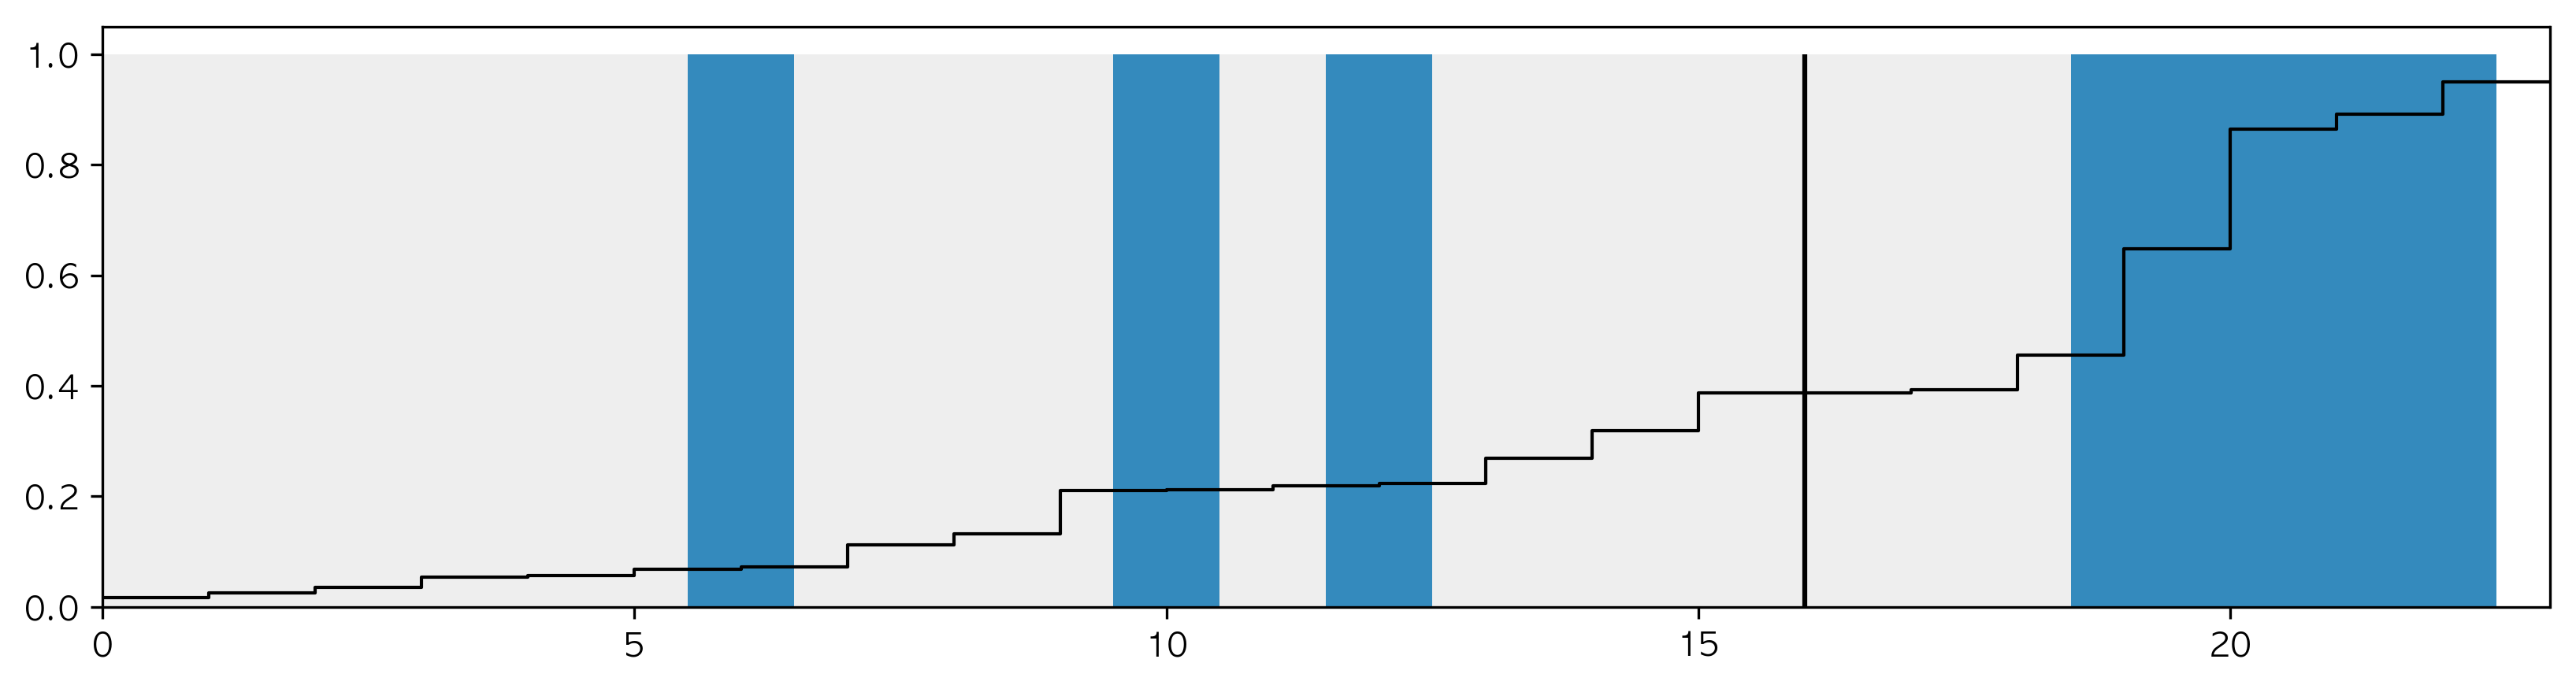

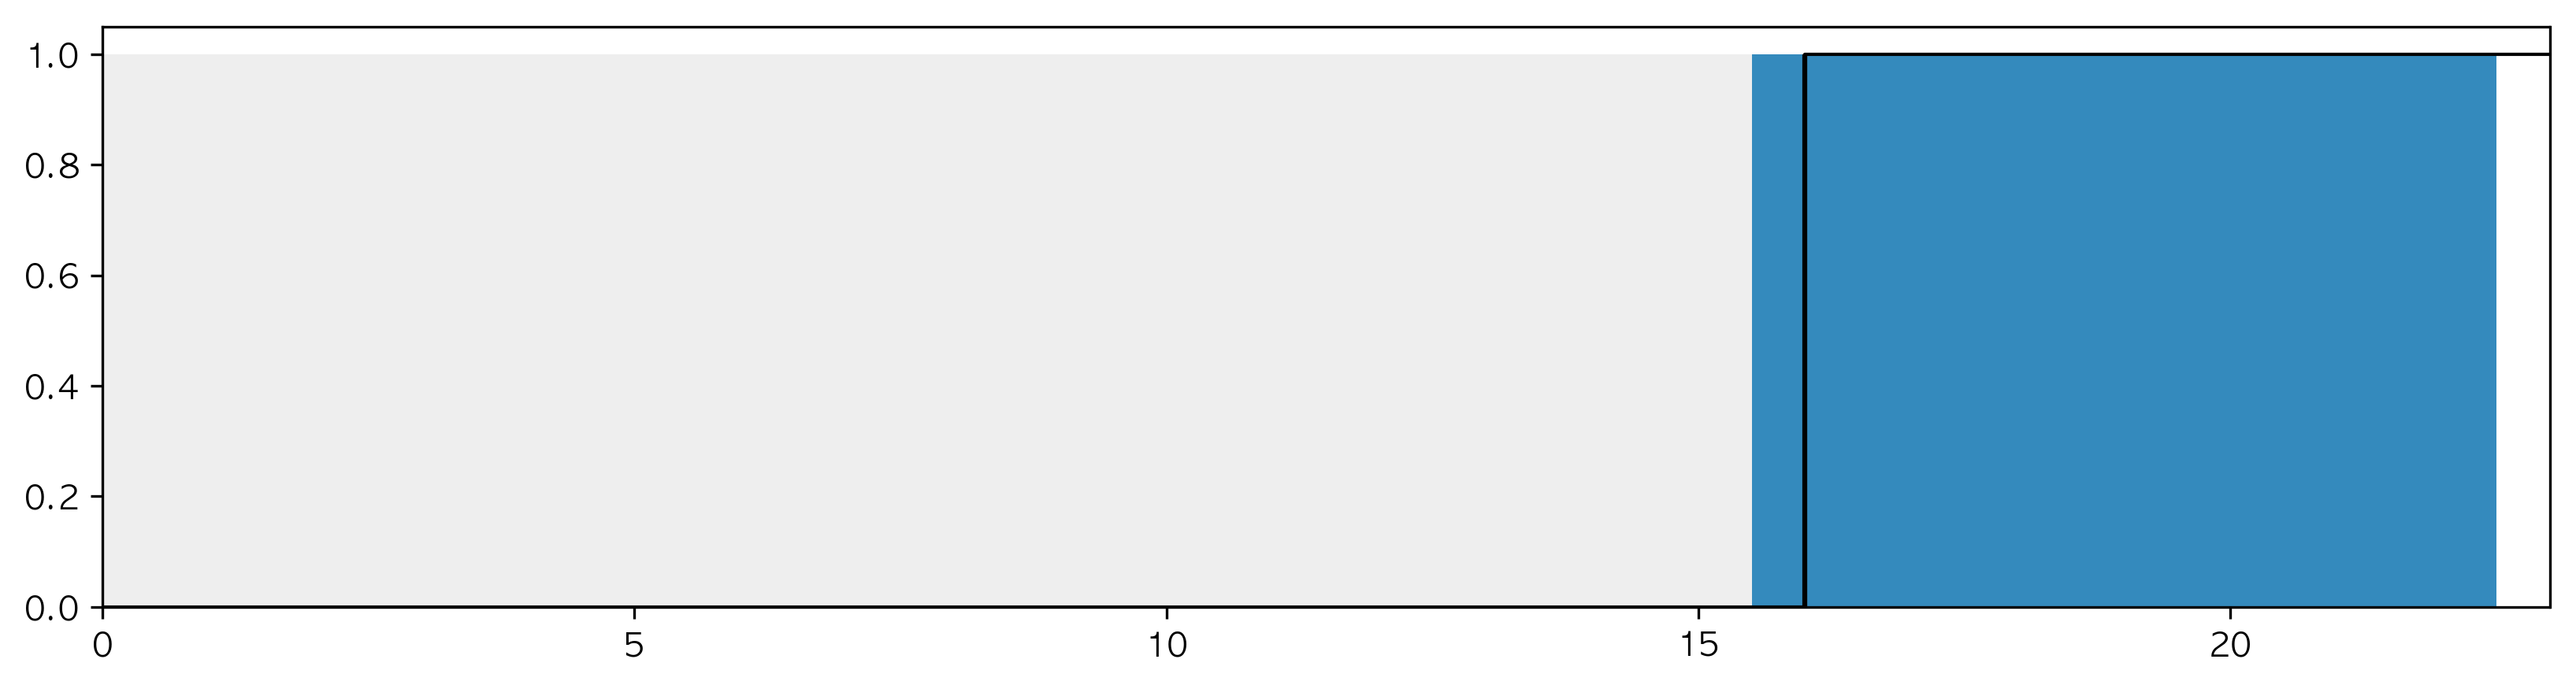

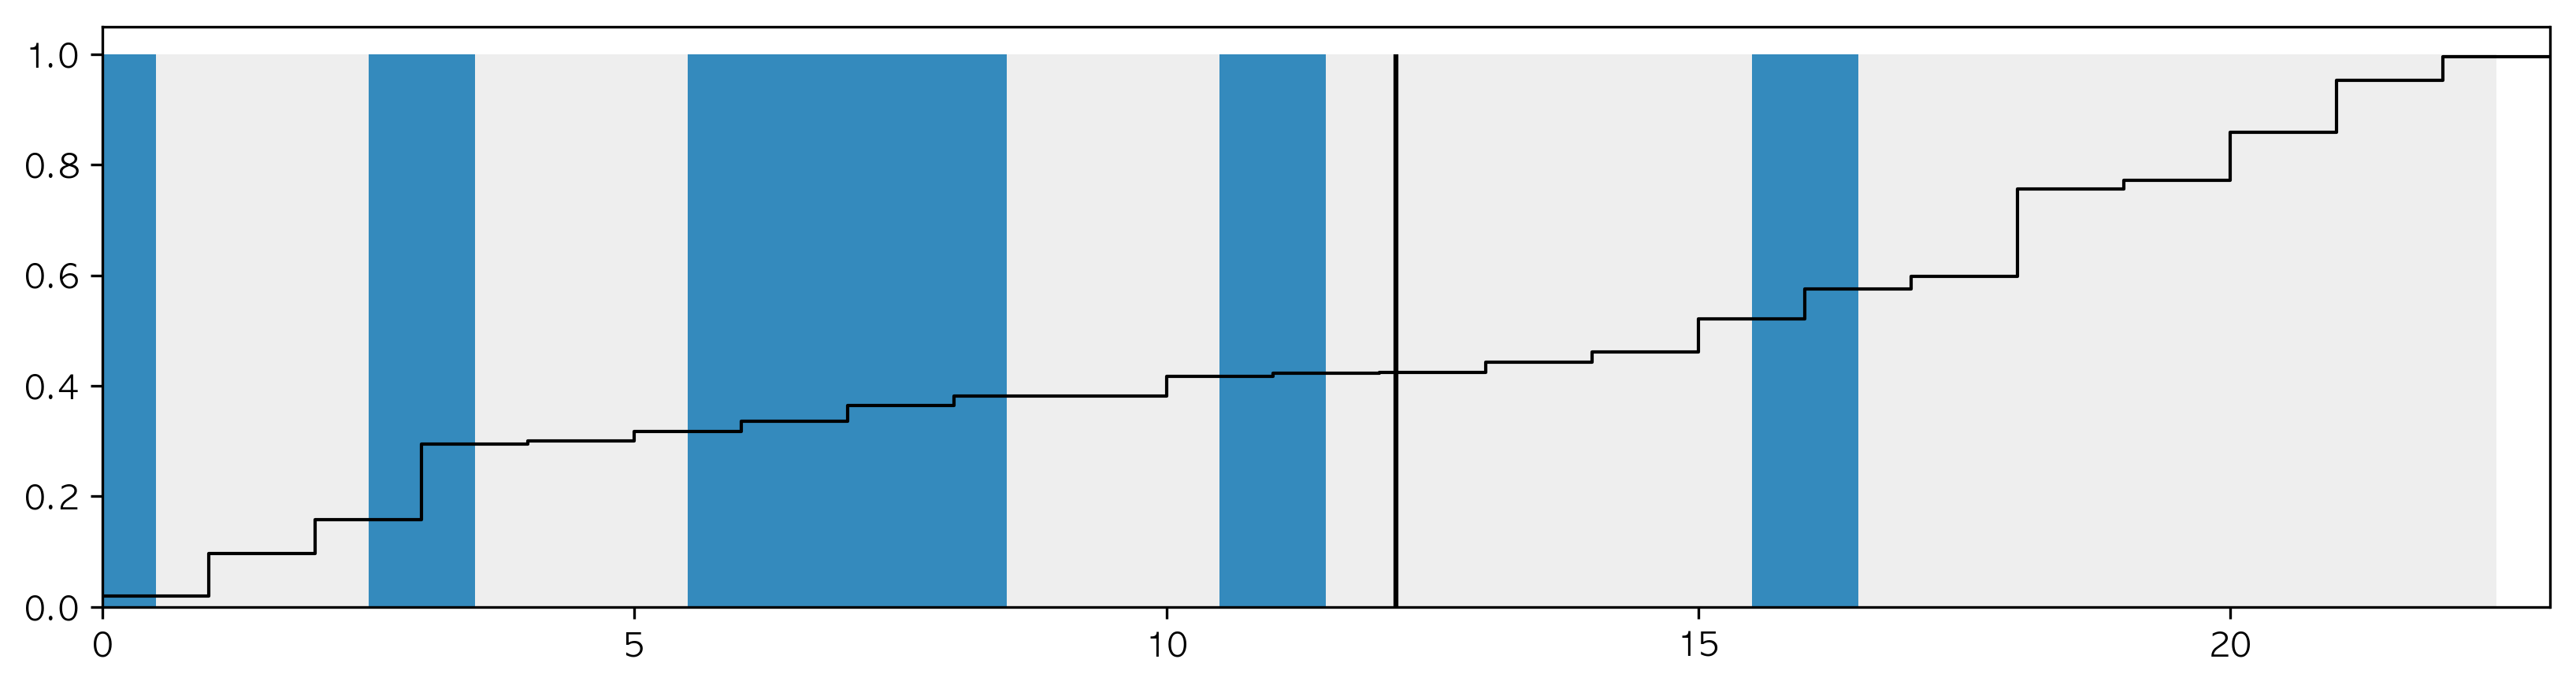

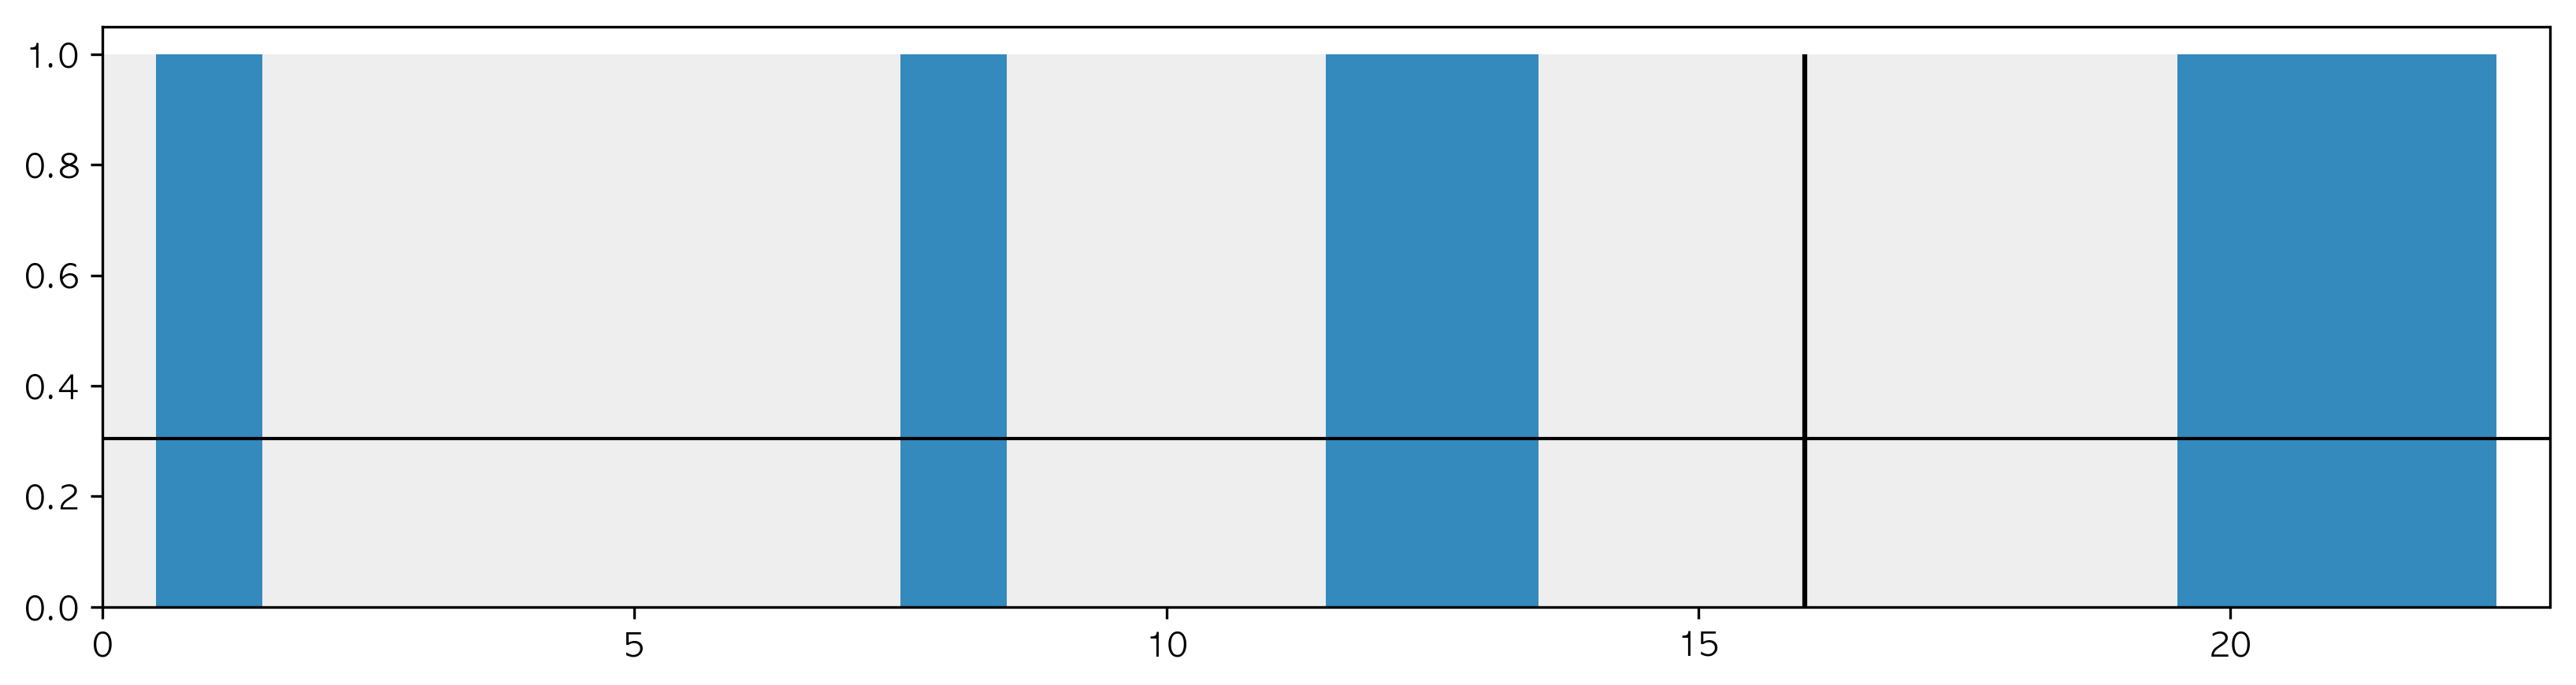

In [86]:
figsize(11, 3)

# Our temperature-dependent model
# 기온 종속적 모델
separation_plot(posterior_probability, D)
#plt.title("기온 종속적 모델")

# Perfect model
# i.e. the probability of defect is equal to if a defect occurred or not.
# 퍼펙트모델
# 즉 결함의 확률은 결함이 발생여부와 동일하다
p = D
separation_plot(p, D)
#plt.title("퍼펙트 모델")

# random predictions
# 랜덤예측모델
p = np.random.rand(23)
separation_plot(p, D)
#plt.title("랜덤 모델")

# constant model
# 상수모델
constant_prob = 7. / 23 * np.ones(23)
separation_plot(constant_prob, D)
#plt.title("상수-예측모델");

In [88]:
D

array([ 0.,  1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  1.,  1.,  0.,  0.,
        1.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  0.,  1.])